In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os
import sys
import pandas as pd
import sympy
sys.path.append('../')  

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

In [2]:
from test_data import *
from numpy.linalg import matrix_rank, svd
from itertools import product
from utils import plot_result_jacobi
from error_bounds import *
from matplotlib.colors import LinearSegmentedColormap
from jrc_analysis import *

In [3]:
#Defining colors for the plots: green = true , red = false
green=(100/255,250/255,100/255)#(0,1,0)
neutral_color = (1, 1, 1)  
red=(241/255,13/255,30/255)
cmap_green_red = LinearSegmentedColormap.from_list('RedGreen', [green,neutral_color,red], N=256)
cmap_red_green = LinearSegmentedColormap.from_list('GreenRed', [red,neutral_color,green], N=256)

We want to get a threshold and error bound for analysing a analytic or polynomial PDE as unique. We can reuse the functions from the SFranco method.

## Easy examples: $u_1 = x^2 + t^2$ and $u_2 = exp(x-at)$

In [4]:
n_samples=50
T,X,t,x = create_data_2d(T_start=-2, T_end=2, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)
np.random.seed(3)
a=np.random.randn()
x_sp = sympy.Symbol('x')
t_sp = sympy.Symbol('t')

#not unique
"""
u = X**2 + T**2
ux = 2*X
ut = 2*T
utx = 0*T
uxx = 2*np.ones(X.shape)
formula = x_sp**2+t_sp**2
"""

#not unqiue
u = np.exp(X-a*T)
formula = sympy.exp(x_sp-a*t_sp)
ux = u
ut = -a*u
utx = -a*u
uxx = u

"""
#analytic unique
u=(X + T)*np.arccos(1/np.cosh(a*T))
ut = a*(T + X)*np.sinh(T*a)/(np.sqrt(1 - 1/np.cosh(T*a)**2)*np.cosh(T*a)**2) + np.arccos(1/np.cosh(T*a))
ux = np.arccos(1/np.cosh(T*a))
utx = a*np.sinh(T*a)/(np.sqrt(1 - 1/np.cosh(T*a)**2)*np.cosh(T*a)**2)
uxx = np.zeros(X.shape)
formula = (x_sp + t_sp)*sympy.acos(1/sympy.cosh(a*t_sp))
"""
print("Formula: ", formula)
print(f"a {a}")
dt=t[1]-t[0]
dx=x[1]-x[0]

Formula:  exp(-1.78862847343032*t + x)
a 1.7886284734303186


#### Compare the error on finite differences on the Jacobian of $g = ( u | u_x)$

In [5]:
#Compute the derivatives
fd_order=2
ut_fd, utx_fd,ux_fd, uxx_fd = get_derivatives(u,dt,dx,fd_order,drop_endpoints=True,remove_endpoints=False)

#Filter out the boundary values
filter_func = utx_fd
ut_fd,ut = drop_endpoints(ut_fd,ut,filter_func)
utx_fd,utx = drop_endpoints(utx_fd,utx,filter_func)
ux_fd,ux = drop_endpoints(ux_fd,ux,filter_func)
uxx_fd,uxx = drop_endpoints(uxx_fd,uxx,filter_func)

X_filtered = drop_endpoints(X,X,filter_func)[0]
T_filtered = drop_endpoints(T,T,filter_func)[0]

##### Compare the upper bounds for different derivatives and the Jacobian

###### Without noise

Lets calculate an upper bound for the different derivatives

In [6]:
#Check  upper bound on derivatives
eps=1e-15
Cut, Cux, Cuxx, Cutx= get_Cut_Cux_Cuxx_Cutx(formula,X,T,fd_order)
bound_ut = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=Cut,Cxi=1.0,h=dt)
bound_ux = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=Cux,Cxi=1.0,h=dx)
bound_uxx = upper_bound_central_differences(eps,fd_order,order_derivative=2,Cu=Cuxx,Cxi=1.0,h=dx)
bound_utx = upper_bound_central_differences(bound_ut,fd_order,order_derivative=1,Cu=Cutx,Cxi=1.0,h=dx)

print(f" |ut_fd - ut| \t= {infinity_norm((ut_fd-ut).flatten()):.3e} <= {bound_ut:.3e}")
print(f" |ux_fd - ux| \t= {infinity_norm((ux_fd-ux).flatten()):.3e} <= {bound_ux:.3e}")
print(f" |uxx_fd - uxx|\t= {infinity_norm((uxx_fd-uxx).flatten()):.3e} <= {bound_uxx:.3e}")
print(f" |utx_fd - utx|\t= {infinity_norm((utx_fd-utx).flatten()):.3e} <= {bound_utx:.3e}")

 |ut_fd - ut| 	= 2.636e+01 <= 3.374e+01
 |ux_fd - ux| 	= 7.194e+00 <= 9.214e+00
 |uxx_fd - uxx|	= 3.596e+00 <= 1.843e+01
 |utx_fd - utx|	= 3.927e+01 <= 3.472e+02


Check wether upper bound is correct:
|JG-JG_fd|= 2.554e-01 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 5.931e-02 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 1.377e-02 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 7.086e-01 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 1.645e-01 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 3.821e-02 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 1.966e+00 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 4.565e-01 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 1.060e-01 <= 3.494e+02


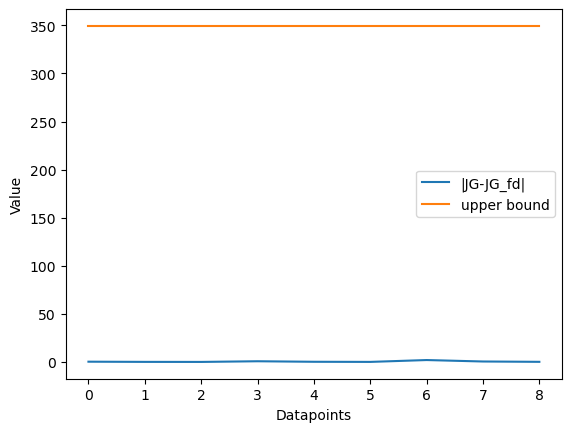

In [7]:
# Check upper bound on Jacobian
space_range = int(ut.shape[0]/10-1)
time_range = int(ut.shape[1]/10-1)
jacobians =[]
upperbounds=[]
for i in range(space_range):
    for j in range(time_range):
        x_i, t_j = i * 10 + 10, j * 10 + 10
        jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
        jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)

        jacobian_diff = np.linalg.norm(jacobian_fd -jacobian)
        nr_datapoints=1
        upperbound = np.sqrt(bound_ut**2+bound_ux**2 + bound_uxx**2+bound_utx**2)

        jacobians.append(jacobian_diff)
        upperbounds.append(upperbound)

        print("Check wether upper bound is correct:")
        print(f"|JG-JG_fd|= {jacobian_diff:.3e} <= {upperbound:.3e}")

plt.plot(jacobians,label="|JG-JG_fd|")
plt.plot(upperbounds, label="upper bound")
plt.xlabel("Datapoints")
plt.ylabel("Value")
plt.legend()
plt.show()

Noise level 0
 |ut_fd - ut| 	= 2.636e+01 <= 3.374e+01
 |ux_fd - ux| 	= 7.194e+00 <= 9.214e+00
 |uxx_fd - uxx|	= 3.596e+00 <= 1.843e+01
 |utx_fd - utx|	= 3.927e+01 <= 3.472e+02
Upper bound 3.494e+02


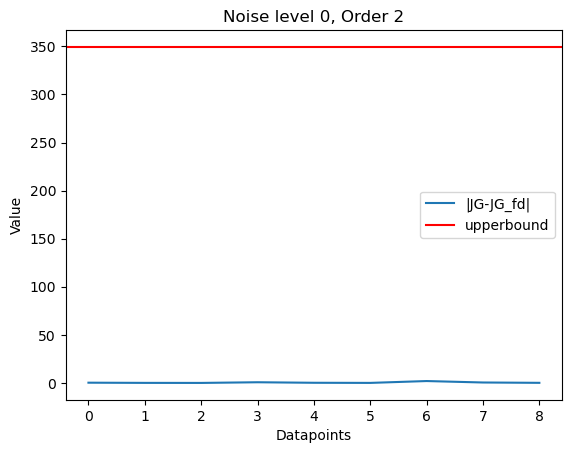

Noise level 1e-10
 |ut_fd - ut| 	= 2.636e+01 <= 3.374e+01
 |ux_fd - ux| 	= 7.194e+00 <= 9.214e+00
 |uxx_fd - uxx|	= 3.596e+00 <= 1.843e+01
 |utx_fd - utx|	= 3.927e+01 <= 3.472e+02
Upper bound 3.494e+02


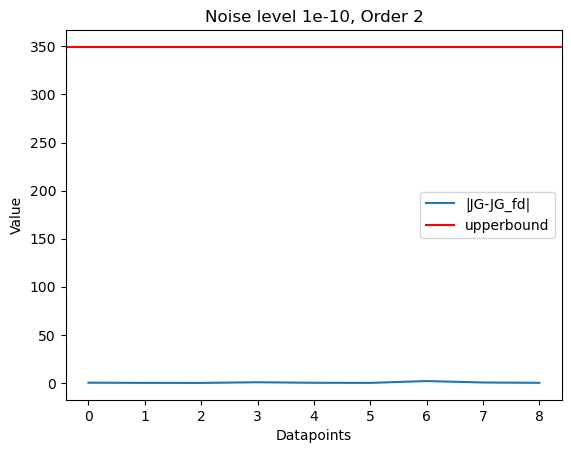

Noise level 1e-09
 |ut_fd - ut| 	= 2.636e+01 <= 3.374e+01
 |ux_fd - ux| 	= 7.194e+00 <= 9.214e+00
 |uxx_fd - uxx|	= 3.596e+00 <= 1.843e+01
 |utx_fd - utx|	= 3.927e+01 <= 3.472e+02
Upper bound 3.494e+02


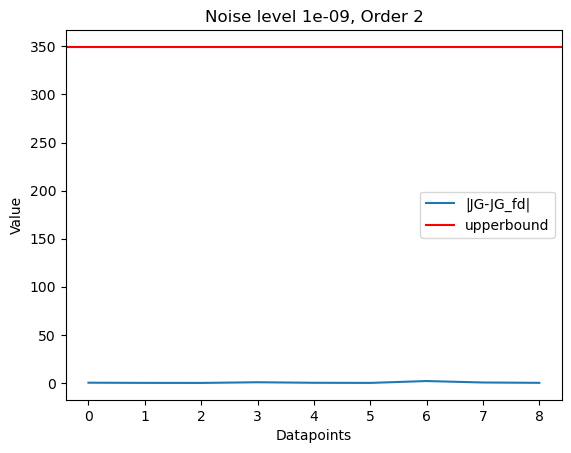

Noise level 1e-08
 |ut_fd - ut| 	= 2.636e+01 <= 3.374e+01
 |ux_fd - ux| 	= 7.194e+00 <= 9.214e+00
 |uxx_fd - uxx|	= 3.597e+00 <= 1.843e+01
 |utx_fd - utx|	= 3.927e+01 <= 3.472e+02
Upper bound 3.494e+02


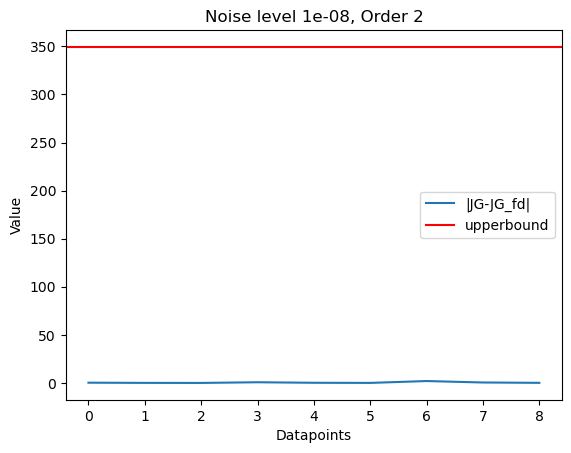

Noise level 1e-07
 |ut_fd - ut| 	= 2.636e+01 <= 3.375e+01
 |ux_fd - ux| 	= 7.193e+00 <= 9.216e+00
 |uxx_fd - uxx|	= 3.562e+00 <= 1.851e+01
 |utx_fd - utx|	= 3.927e+01 <= 3.472e+02
Upper bound 3.494e+02


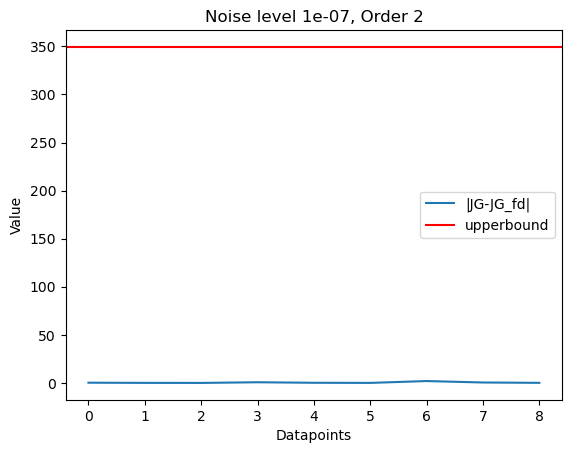

Noise level 1e-06
 |ut_fd - ut| 	= 2.636e+01 <= 3.377e+01
 |ux_fd - ux| 	= 7.196e+00 <= 9.232e+00
 |uxx_fd - uxx|	= 3.626e+00 <= 1.913e+01
 |utx_fd - utx|	= 3.925e+01 <= 3.474e+02
Upper bound 3.497e+02


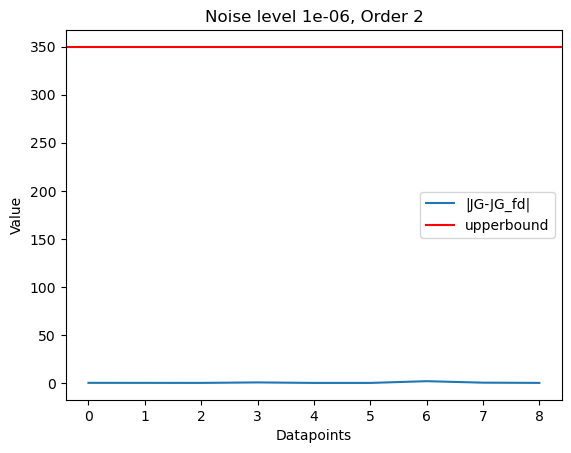

Noise level 1e-05
 |ut_fd - ut| 	= 2.643e+01 <= 3.396e+01
 |ux_fd - ux| 	= 7.162e+00 <= 9.385e+00
 |uxx_fd - uxx|	= 5.712e+00 <= 2.514e+01
 |utx_fd - utx|	= 3.912e+01 <= 3.493e+02
Upper bound 3.519e+02


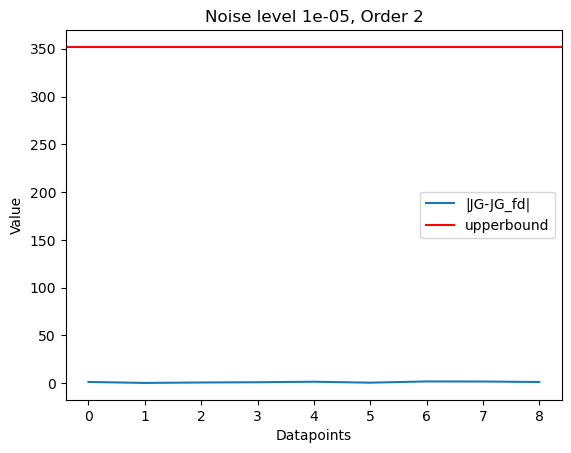

Noise level 0.0001
 |ut_fd - ut| 	= 2.684e+01 <= 3.573e+01
 |ux_fd - ux| 	= 7.072e+00 <= 1.081e+01
 |uxx_fd - uxx|	= 4.052e+01 <= 8.080e+01
 |utx_fd - utx|	= 3.968e+01 <= 3.667e+02
Upper bound 3.773e+02


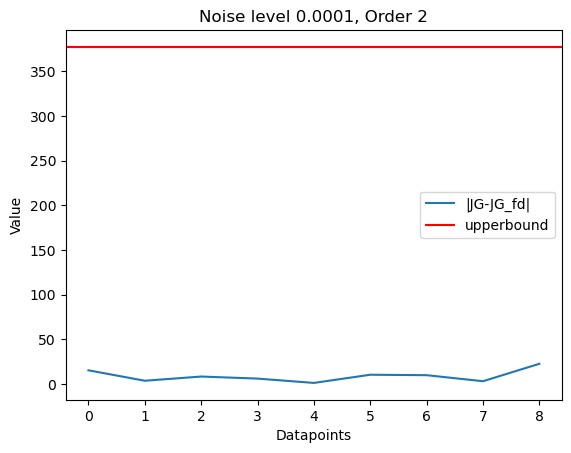

Noise level 0.001
 |ut_fd - ut| 	= 3.109e+01 <= 5.487e+01
 |ux_fd - ux| 	= 1.215e+01 <= 2.611e+01
 |uxx_fd - uxx|	= 4.290e+02 <= 6.809e+02
 |utx_fd - utx|	= 1.167e+02 <= 5.542e+02
Upper bound 8.800e+02


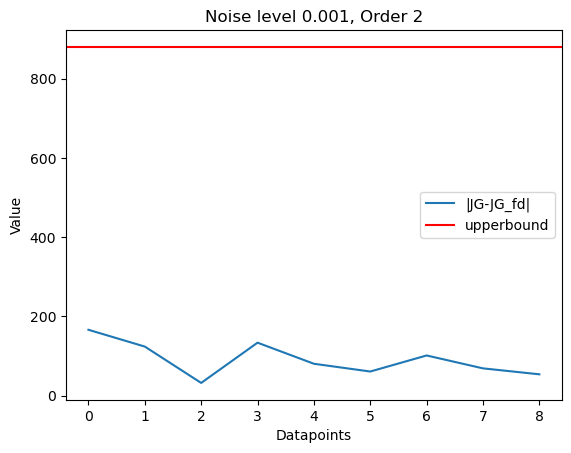

Noise level 0.01
 |ut_fd - ut| 	= 1.615e+02 <= 3.107e+02
 |ux_fd - ux| 	= 1.321e+02 <= 2.308e+02
 |uxx_fd - uxx|	= 4.195e+03 <= 8.703e+03
 |utx_fd - utx|	= 1.095e+03 <= 3.061e+03
Upper bound 9.233e+03


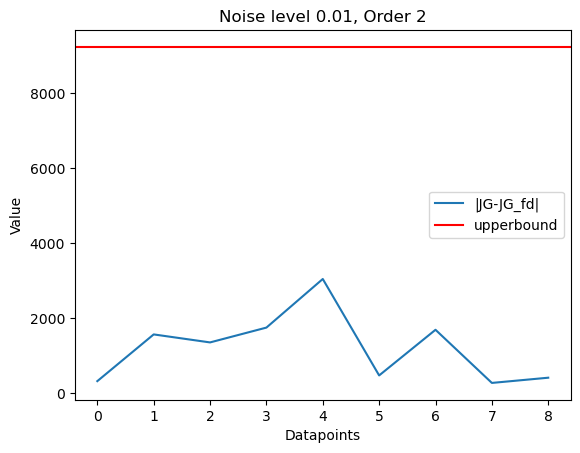

In [8]:
#Check upper bound on jacobian with noise
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
unorm2=np.sqrt(np.mean(np.square(u)))

for noise_level in noise_levels: 
    var = noise_level * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    print(f"Noise level {noise_level}")
    #Calculate upper bounds
    eps = infinity_norm(u-u_noise)
    bound_ut = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=Cut ,Cxi=1.0,h=dt)
    bound_ux = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=Cux,Cxi=1.0,h=dx)
    bound_uxx = upper_bound_central_differences(eps,fd_order,order_derivative=2,Cu=Cuxx,Cxi=1.0,h=dx)
    bound_utx = upper_bound_central_differences(bound_ut,fd_order,order_derivative=1,Cu=Cutx,Cxi=1.0,h=dx)
    
    #Calculate derivatives
    ut_fd, utx_fd,ux_fd, uxx_fd= get_derivatives(u_noise,dt,dx,fd_order)
    
    print(f" |ut_fd - ut| \t= {infinity_norm((ut_fd-ut).flatten()):.3e} <= {bound_ut:.3e}")
    print(f" |ux_fd - ux| \t= {infinity_norm((ux_fd-ux).flatten()):.3e} <= {bound_ux:.3e}")
    print(f" |uxx_fd - uxx|\t= {infinity_norm((uxx_fd-uxx).flatten()):.3e} <= {bound_uxx:.3e}")
    print(f" |utx_fd - utx|\t= {infinity_norm((utx_fd-utx).flatten()):.3e} <= {bound_utx:.3e}")
    
    jacobians =[]
    #Calculate upper bound which stays constant for all data points(only changes in noise level)
    nr_datapoints=1
    upperbound = np.sqrt(bound_ut**2+bound_ux**2 + bound_uxx**2+bound_utx**2)
    print(f"Upper bound {upperbound:.3e}")
    for i in range(space_range):
        for j in range(time_range):
            #Compute differenc between true Jacobian and finite difference Jacobian
            x_i, t_j = i * 10 + 10, j * 10 + 10
            jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
            jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
            jacobian_diff = np.linalg.norm(jacobian_fd -jacobian)    
            jacobians.append(jacobian_diff)
    
            #print("Check wether upper bound is correct:")
            #print(f"|JG-JG_fd|= {jacobian_diff:.3e} <= {upperbound:.3e}")
    plt.title(f"Noise level {noise_level}, Order {fd_order}")
    plt.plot(jacobians,label="|JG-JG_fd|")
    plt.axhline(y=upperbound, color='r', linestyle='-',label="upperbound")
    plt.xlabel("Datapoints")
    plt.ylabel("Value")
    plt.legend()
    filename = f"Images/noise_{noise_level}_order_{fd_order}.png"
    plt.savefig(filename)
    plt.show()

Compare Jacobians and singular values

In [9]:
space_range = int(ut.shape[1]/10-2)
time_range = int(ut.shape[0]/10-2)

#For saving results
svs = np.zeros([space_range, time_range])
svs_fd = np.zeros([space_range, time_range])
upper_bounds = np.zeros([space_range, time_range])
lower_bounds = np.zeros([space_range, time_range])

ut_fd, utx_fd,ux_fd, uxx_fd = get_derivatives(u,dt,dx,fd_order)

for i in range(space_range):
    for j in range(time_range):
        x_i, t_j = i * 10 + 10, j * 10 + 10
        jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
        jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
        

        sv = svd(jacobian, compute_uv=False)
        sv_fd = svd(jacobian_fd, compute_uv=False)
        sv_min,sv_min_fd =sv  [-1],sv_fd[-1]
        sv_max,sv_max_fd =sv[0],sv_fd[0]

        #Save the results 
        svs[i,j] = sv_min/sv_max
        svs_fd[i,j] =sv_min_fd/sv_max_fd
        jacobian_diff=np.linalg.norm(jacobian_fd -jacobian)
        upper_bound_jacobian = get_upper_bound_jacobian(1e-16,fd_order,Cut,Cux,Cuxx,Cutx,dt,dx)
        print("Jacobian diff ", jacobian_diff, "upper_bound_jacobian",upper_bound_jacobian)
        
        C1=sv_max*1.5 #C1 => o_max
        C=sv_max*0.5 #C <= o_max
        C2=1e-4
        lower_bound = lower_bound_nonsingular_matrix(C1,C2,jacobian_diff)
        upper_bound = upper_bound_singular_matrix(C,jacobian_diff)

        lower_bound_nonexact = lower_bound_nonsingular_matrix(C1,C2,upper_bound_jacobian)
        upper_bound_nonexact = upper_bound_singular_matrix(C,upper_bound_jacobian)

        lower_bounds[i,j]=lower_bound
        upper_bounds[i,j]=upper_bound
        
        print(f" Comparison at x = {x_i}, t = {t_j} ")
        print(f" \t \t \t \t Original \t FD \t \t diff")
        print(f" Smallest singular values \t {sv_min:.3e}\t  {sv_min_fd:.3e} \t {np.abs(sv_min-sv_min_fd):.3e}")
        print(f" Biggest singular values \t {sv_max:.3e}\t  {sv_max_fd:.3e} \t {np.abs(sv_max-sv_max_fd):.3e}")
        print(f" Differences Jacobian \t \t {jacobian_diff:.3e} <= {upper_bound_jacobian:.3e}")
        print(" Bounds with jacobian difference")
        print(f" \t Lower bound for uniqueness: \t  {svs_fd[i,j]:.3e} >= {lower_bound:.3e}")
        print(f" \t Upper bound for non uniqueness:  {svs_fd[i,j]:.3e} <= {upper_bound:.3e}")
        print(" Bounds with upper bound on jacobian difference")
        print(f" \t Lower bound for uniqueness: \t  {svs_fd[i,j]:.3e} >= {lower_bound_nonexact:.3e}")
        print(f" \t Upper bound for non uniqueness:  {svs_fd[i,j]:.3e} <= {upper_bound_nonexact:.3e}")
        print(f" True ratio: \t  \t \t  {svs[i,j]:.3e} ")

Jacobian diff  0.2554043136692312 upper_bound_jacobian 349.4125662912489
 Comparison at x = 10, t = 10 
 	 	 	 	 Original 	 FD 	 	 diff
 Smallest singular values 	 3.101e-15	  3.549e-02 	 3.549e-02
 Biggest singular values 	 6.392e+01	  6.415e+01 	 2.355e-01
 Differences Jacobian 	 	 2.554e-01 <= 3.494e+02
 Bounds with jacobian difference
 	 Lower bound for uniqueness: 	  5.532e-04 >= 0.000e+00
 	 Upper bound for non uniqueness:  5.532e-04 <= 8.056e-03
 Bounds with upper bound on jacobian difference
 	 Lower bound for uniqueness: 	  5.532e-04 >= 0.000e+00
 	 Upper bound for non uniqueness:  5.532e-04 <= 1.000e+00
 True ratio: 	  	 	  4.851e-17 
Jacobian diff  0.05930792603622601 upper_bound_jacobian 349.4125662912489
 Comparison at x = 10, t = 20 
 	 	 	 	 Original 	 FD 	 	 diff
 Smallest singular values 	 7.752e-16	  8.242e-03 	 8.242e-03
 Biggest singular values 	 1.484e+01	  1.490e+01 	 5.469e-02
 Differences Jacobian 	 	 5.931e-02 <= 3.494e+02
 Bounds with jacobian difference
 	 Lo

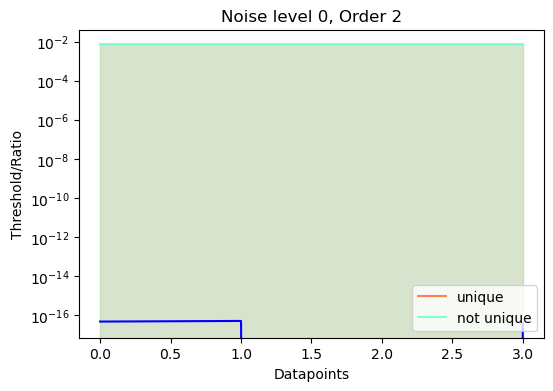

In [10]:
# Create subplots
plot_ratio_upper_lower_old(svs,lower_bounds,upper_bounds,f"Noise level {0}, Order {fd_order}")

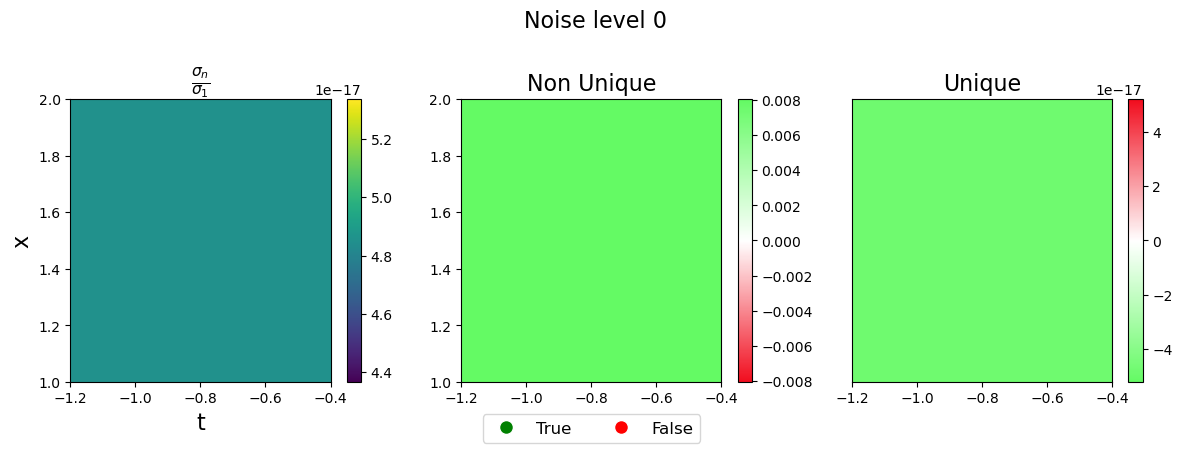

In [11]:
plot_results(upper_bounds,lower_bounds,svs,time_range,space_range,t,x,subtitle=f"Noise level {0}")

### Test different noise levels on easy examples

Noise level 0
Noise level 1e-08
Noise level 1e-05
Noise level 0.01


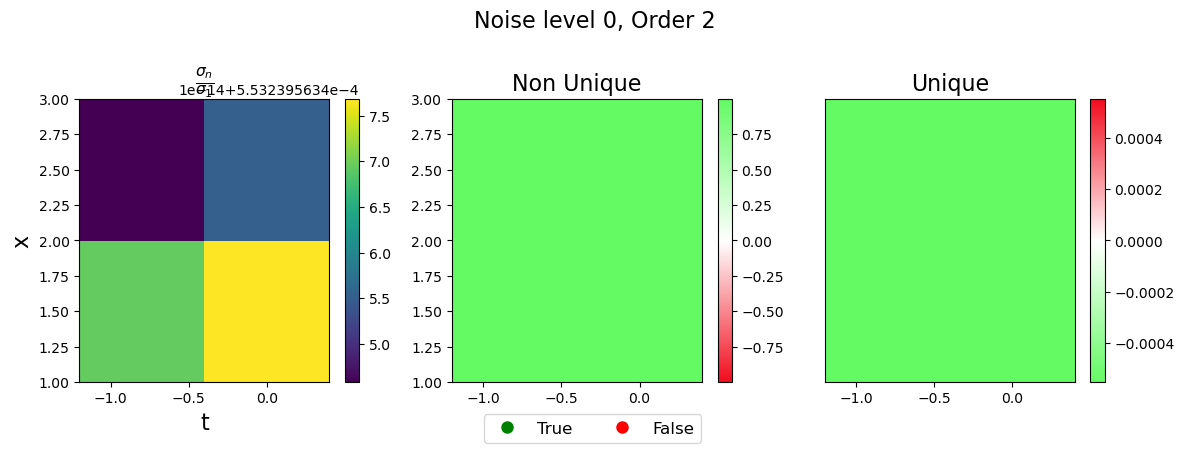

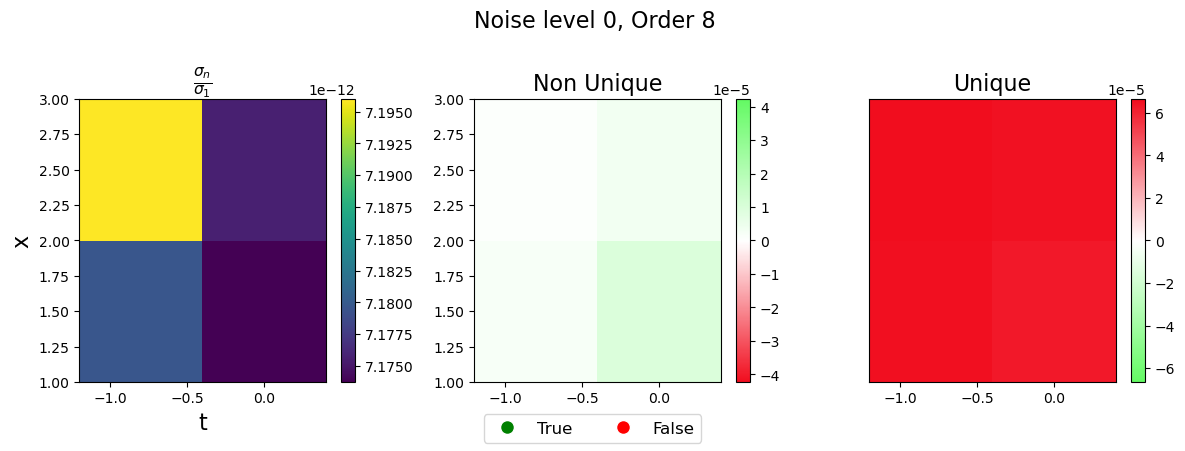

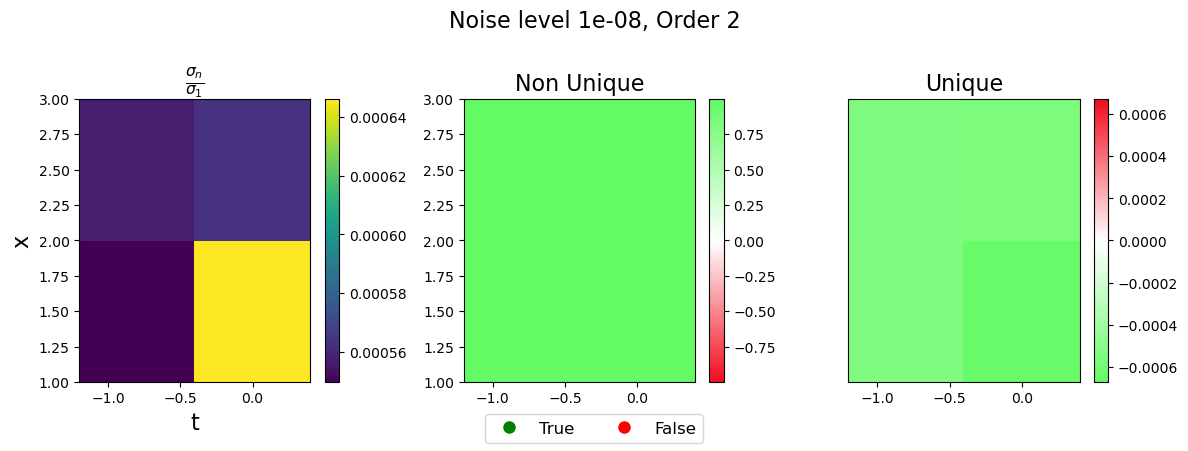

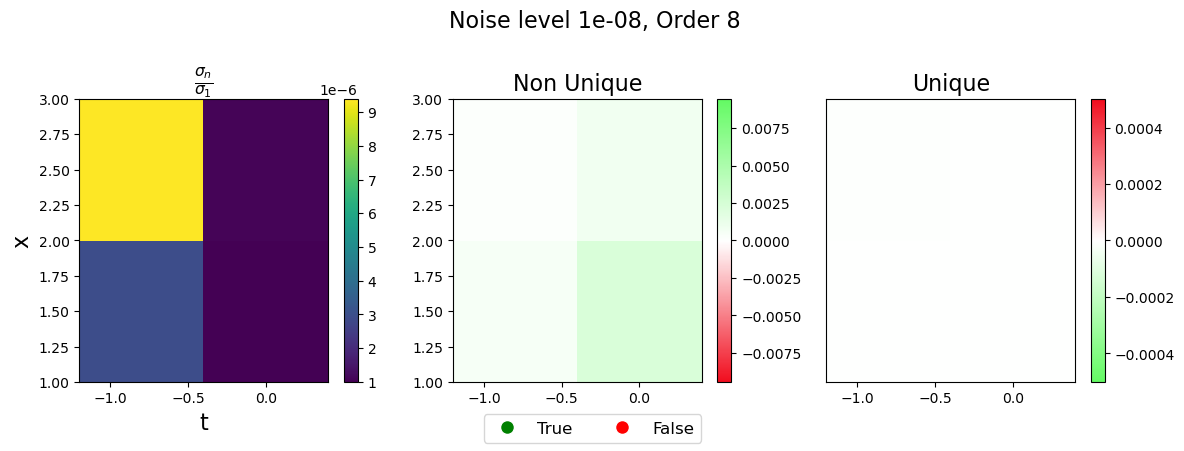

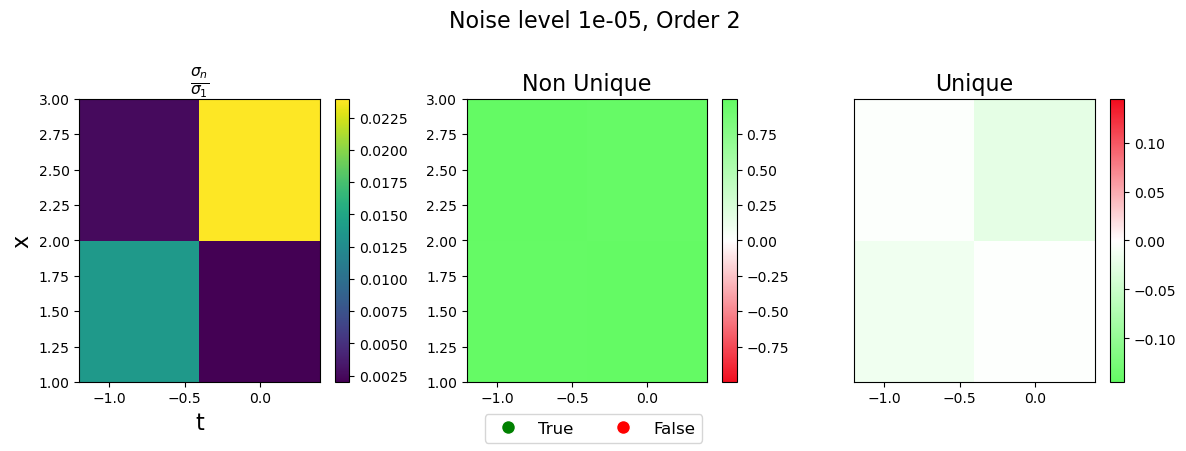

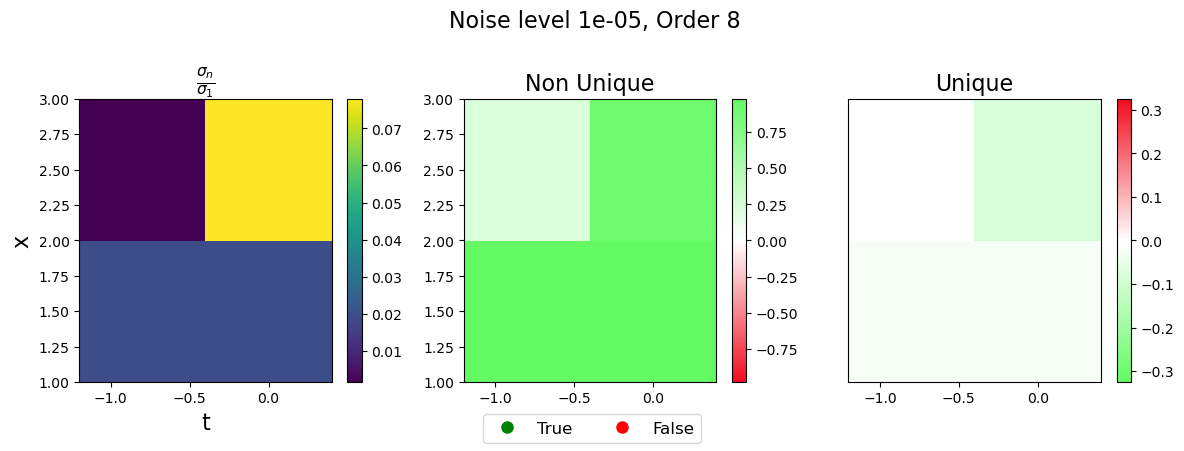

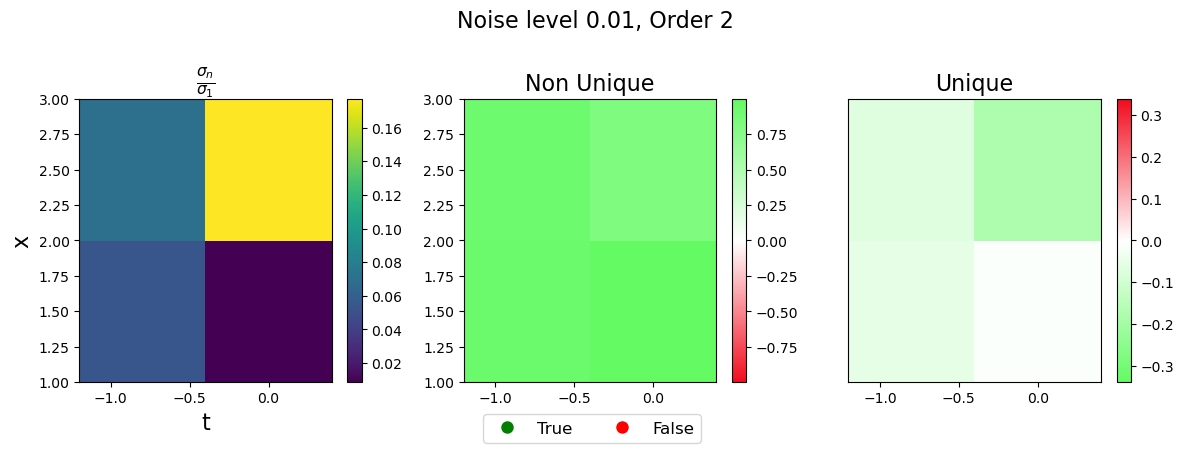

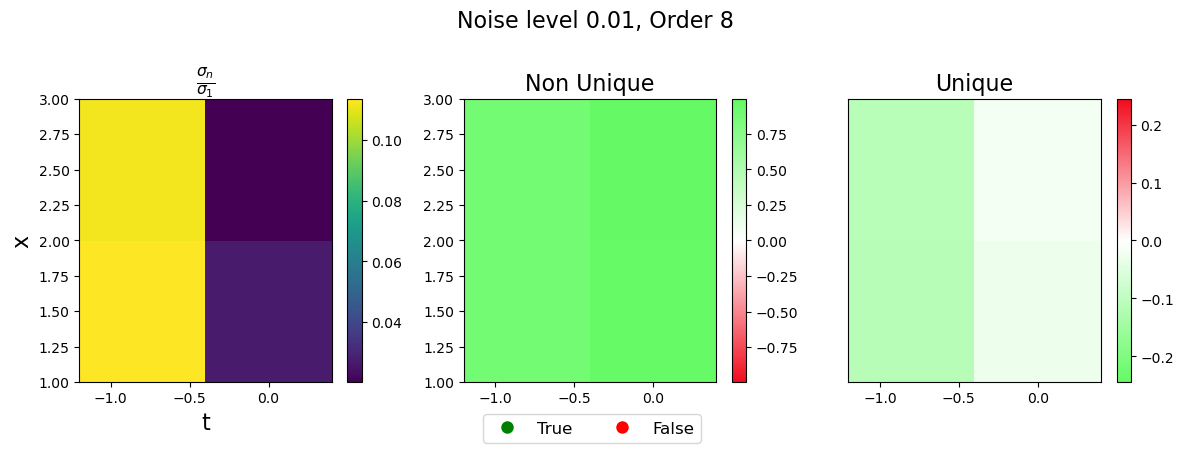

In [7]:
M=infinity_norm(u)
fd_orders=(2,8)
number_noise=10 #<=10
#noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
noise_levels = [0,1e-08,1e-05,1e-02]
orders=range(2,10,2)
unorm2=np.sqrt(np.mean(np.square(u)))
C_upper_bounds_deriv_fd_order0 = get_Cut_Cux_Cuxx_Cutx(formula,X,T,fd_orders[0])
C_upper_bounds_deriv_fd_order1 = get_Cut_Cux_Cuxx_Cutx(formula,X,T,fd_orders[1])

for noise_level in noise_levels:    
    
    var = noise_level * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    eps = infinity_norm(u-u_noise)
    
    print(f"Noise level {noise_level}")
    fd_orders=(2,8)
    svs, lower_bounds,upper_bounds,space_range,time_range = get_results(u_noise,C_upper_bounds_deriv_fd_order0,fd_orders[0],dt,dx,eps)
    plot_results(upper_bounds, lower_bounds,svs,time_range,space_range,t,x,subtitle=f"Noise level {noise_level}, Order {fd_orders[0]}")
    svs, lower_bounds,upper_bounds,space_range,time_range = get_results(u_noise,C_upper_bounds_deriv_fd_order1,fd_orders[1],dt,dx,eps)
    plot_results(upper_bounds, lower_bounds,svs,time_range,space_range,t,x,subtitle=f"Noise level {noise_level}, Order {fd_orders[1]}")

In [8]:
M=infinity_norm(u)
number_noise=10 #<=10
#noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
noise_levels = [0,1e-08,1e-05,1e-02]
orders=range(2,10,2)
unorm2=np.sqrt(np.mean(np.square(u)))

for noise_level in noise_levels:    
    
    var = noise_level * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    eps = infinity_norm(u-u_noise)
    
    print(f"Noise level {noise_level}")
    fd_orders=(2,8)
    svs, lower_bounds,upper_bounds,space_range,time_range = get_results(u_noise,C_upper_bounds_deriv_fd_order0,fd_orders[0],dt,dx,eps)
    print(f"Order {fd_orders[0]}")
    print(" \t omax/omin \t \t \t  lower_bounds \t \t upper_bounds")
    #Print Values
    for val_svs,val_lb, val_ub in zip(svs,lower_bounds, upper_bounds):
        print(" \t ",val_svs, " \t ", val_lb, " \t ", val_ub)
    svs, lower_bounds,upper_bounds,space_range,time_range = get_results(u_noise,C_upper_bounds_deriv_fd_order1,fd_orders[1],dt,dx,eps)
    print(f"Order {fd_orders[1]}")
    for val_svs,val_lb, val_ub in zip(svs,lower_bounds, upper_bounds):
        print(" \t ",val_svs, " \t ", val_lb, " \t ", val_ub)

Noise level 0
Order 2
 	 omax/omin 	 	 	  lower_bounds 	 	 upper_bounds
 	  [0.00055324 0.00055324 0.00055324]  	  [0. 0. 0.]  	  [1. 1. 1.]
 	  [0.00055324 0.00055324 0.00055324]  	  [0. 0. 0.]  	  [1. 1. 1.]
 	  [0.00055324 0.00055324 0.00055324]  	  [0. 0. 0.]  	  [1. 1. 1.]
Order 8
 	  [7.17972326e-12 7.17374401e-12 7.17880560e-12]  	  [6.59070080e-05 6.33952724e-05 5.25788504e-05]  	  [2.27883095e-06 9.81365694e-06 4.22630130e-05]
 	  [7.19599416e-12 7.17570249e-12 7.17529292e-12]  	  [6.63928493e-05 6.54874974e-05 6.15886987e-05]  	  [8.21398379e-07 3.53728874e-06 1.52331978e-05]
 	  [7.20097023e-12 7.18531629e-12 7.17895893e-12]  	  [6.65679698e-05 6.62416374e-05 6.48363184e-05]  	  [2.96071074e-07 1.27500502e-06 5.49071898e-06]
Noise level 1e-08
Order 2
 	 omax/omin 	 	 	  lower_bounds 	 	 upper_bounds
 	  [0.00055345 0.00047987 0.00032021]  	  [0. 0. 0.]  	  [1. 1. 1.]
 	  [0.00055948 0.00050396 0.00058321]  	  [0. 0. 0.]  	  [1. 1. 1.]
 	  [0.00055125 0.00055362 0.00055891]  

## Try it on different examples

In [4]:
experiment_names= ['algebraic_nonunique_kdv','algebraic_nonunique_1','analytic_unique_1','analytic_unique_2','analytic_nonunique_1']

### Perform on one experiment

In [5]:
experiment_name = experiment_names[0]
C2_param = 1e-4
fd_order=8
u,x,t,formula = experiment_data(n_samples=150,experiment_name=experiment_name)
dx=x[1]-x[0]
dt=t[1]-t[0]
print(f"Performing experiment {experiment_name} {formula} with order {fd_order}, C2 = {C2_param:.2e}")
subtitle=f"Experiment {experiment_name} {formula}, Order {fd_order}, C2_param = {C2_param:.2e}"
T,X = np.meshgrid(t,x)
C_upper_bounds_deriv = get_Cut_Cux_Cuxx_Cutx(formula,X,T,fd_order)

Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-04


In [6]:
noise_level=0
u_noise = add_noise(u,noise_level)
eps = infinity_norm(u-u_noise)
svs, lower_bounds,upper_bounds,space_range,time_range = get_results(u_noise,C_upper_bounds_deriv,fd_order,dt,dx,eps,C2_param)  

In [8]:
%load_ext autoreload
%autoreload 2

Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-04
upper bound [8112.625]
8112.625
upper bound [12.923583984375]
12.923583984375
upper bound [12.923583984375, 2218.91015625]
2218.91015625
upper bound [12.923583984375]
12.923583984375


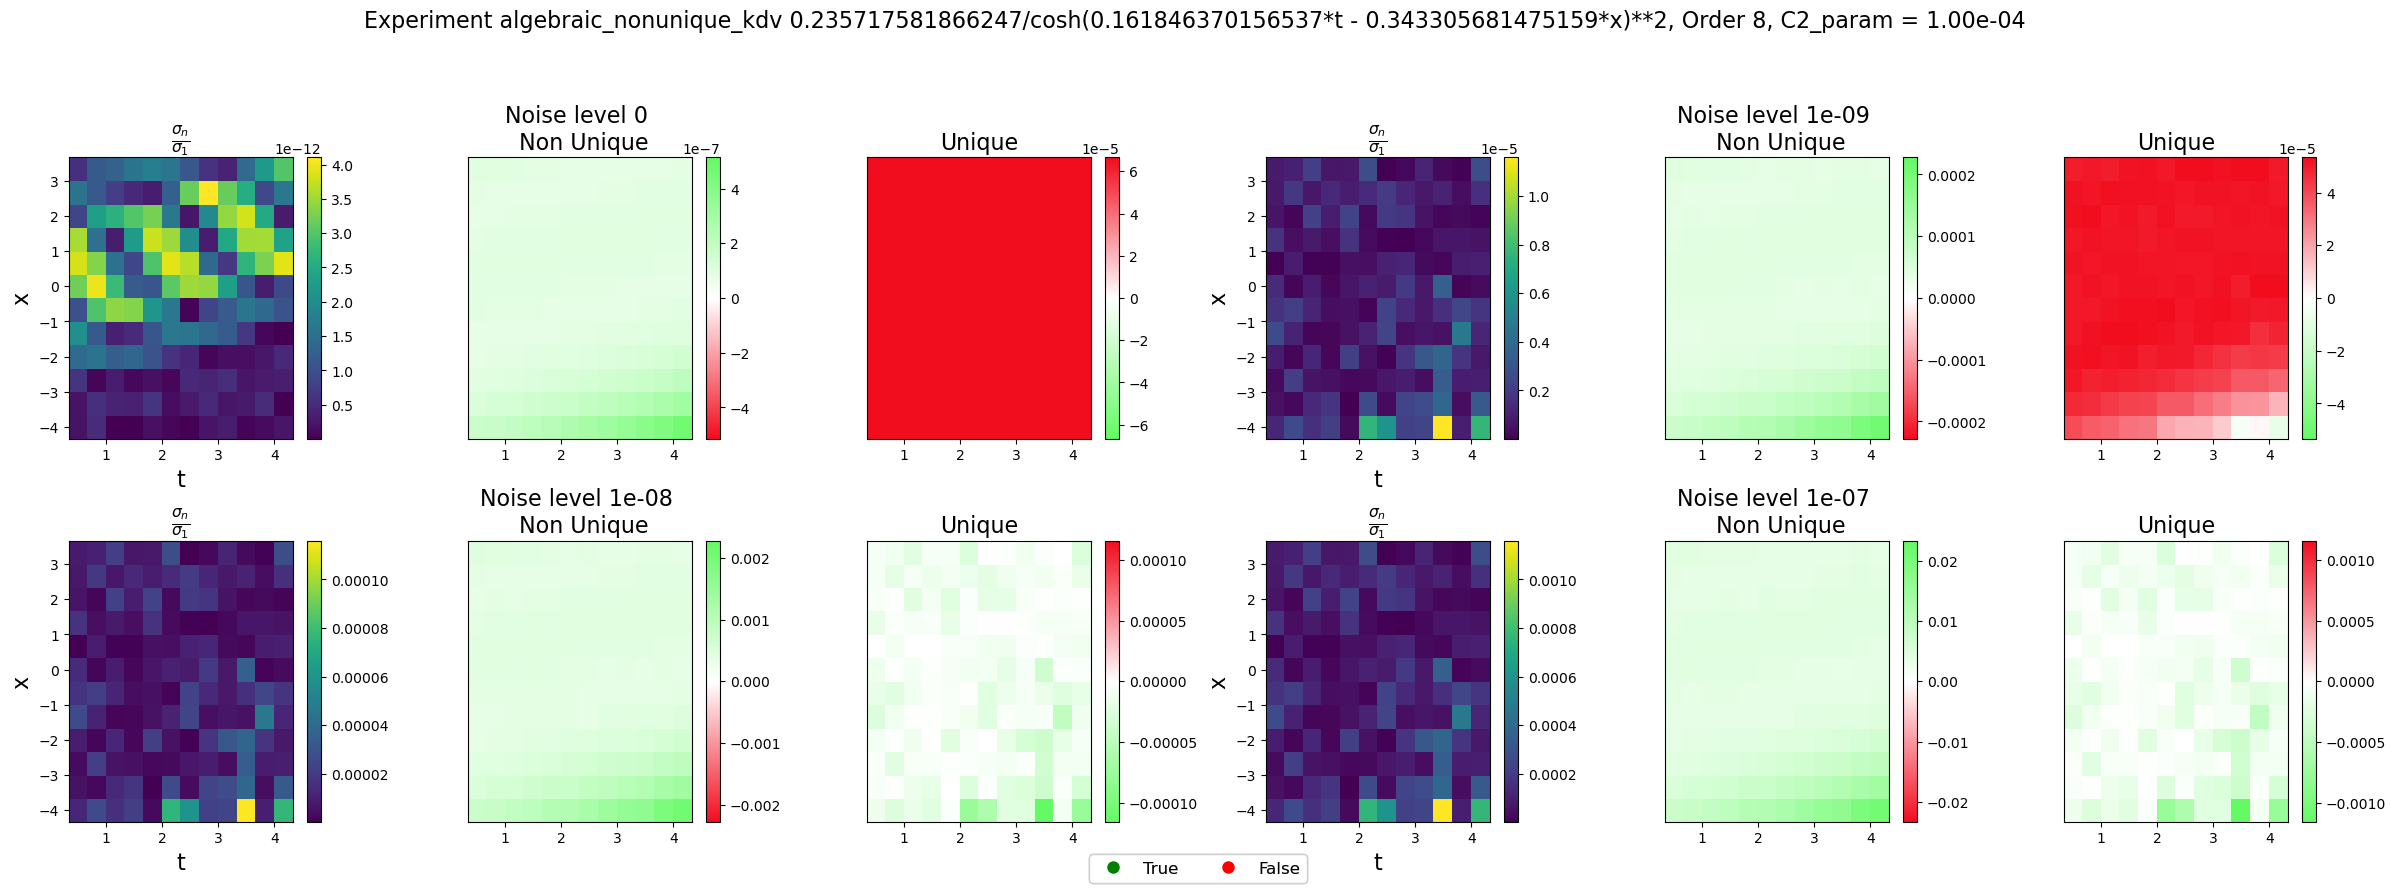

In [13]:
noise_levels = [0,1e-09,1e-08,1e-7]
experiment_name = experiment_names[0]
perform_experiment(noise_levels,fd_order,experiment_name,C2_param=C2_param)

### Perform on all experiments

Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 2, C2 = 1.00e-03
Calc with fd
Calc with fd
Calc with fd
Calc with fd
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-03
Calc with fd
Calc with fd
Calc with fd
Calc with fd
Performing experiment algebraic_nonunique_1 1/(t + x) with order 2, C2 = 1.00e-03
Calc with fd
Calc with fd
Calc with fd
Calc with fd
Performing experiment algebraic_nonunique_1 1/(t + x) with order 8, C2 = 1.00e-03
Calc with fd
Calc with fd
Calc with fd
Calc with fd
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 2, C2 = 1.00e-03
Calc with fd
Calc with fd
Calc with fd
Calc with fd
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e-03
Calc with fd
Calc with fd
Calc with fd
Calc with fd
Performing experim

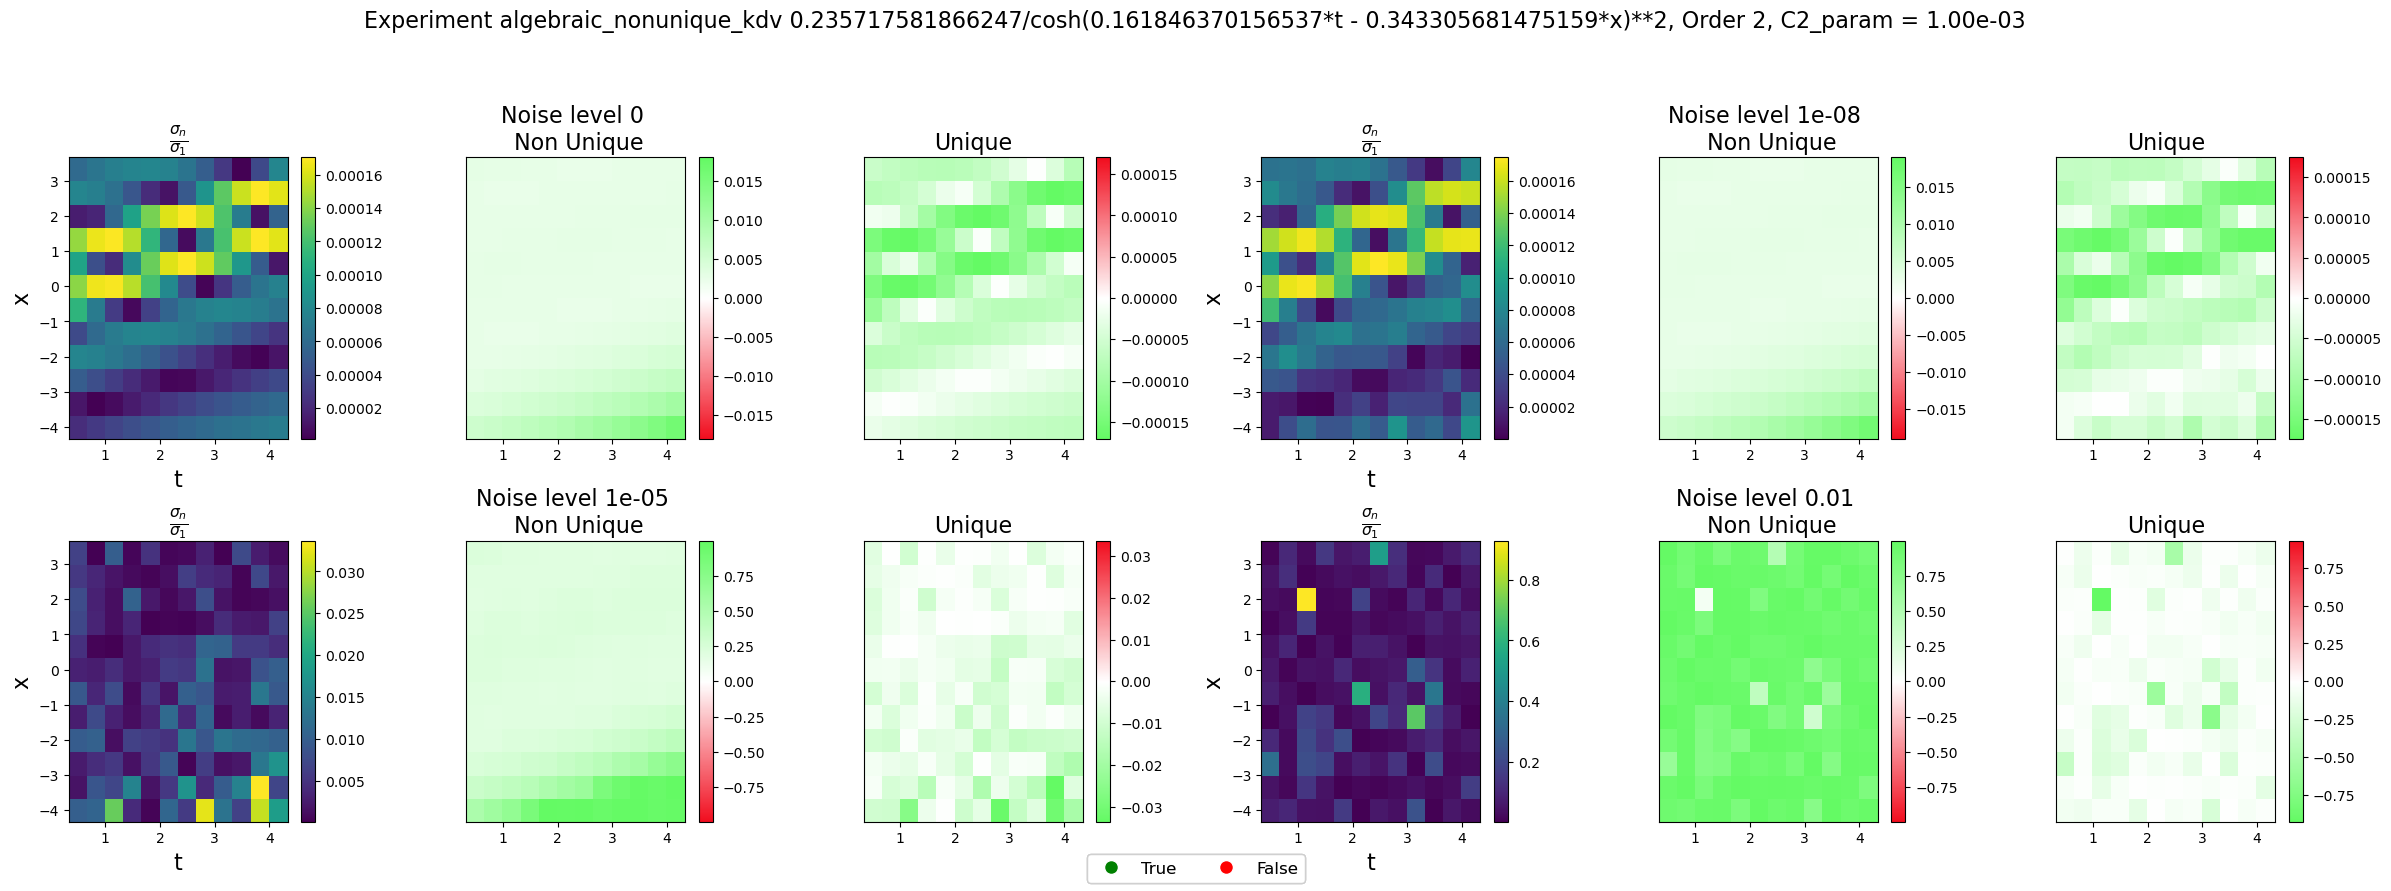

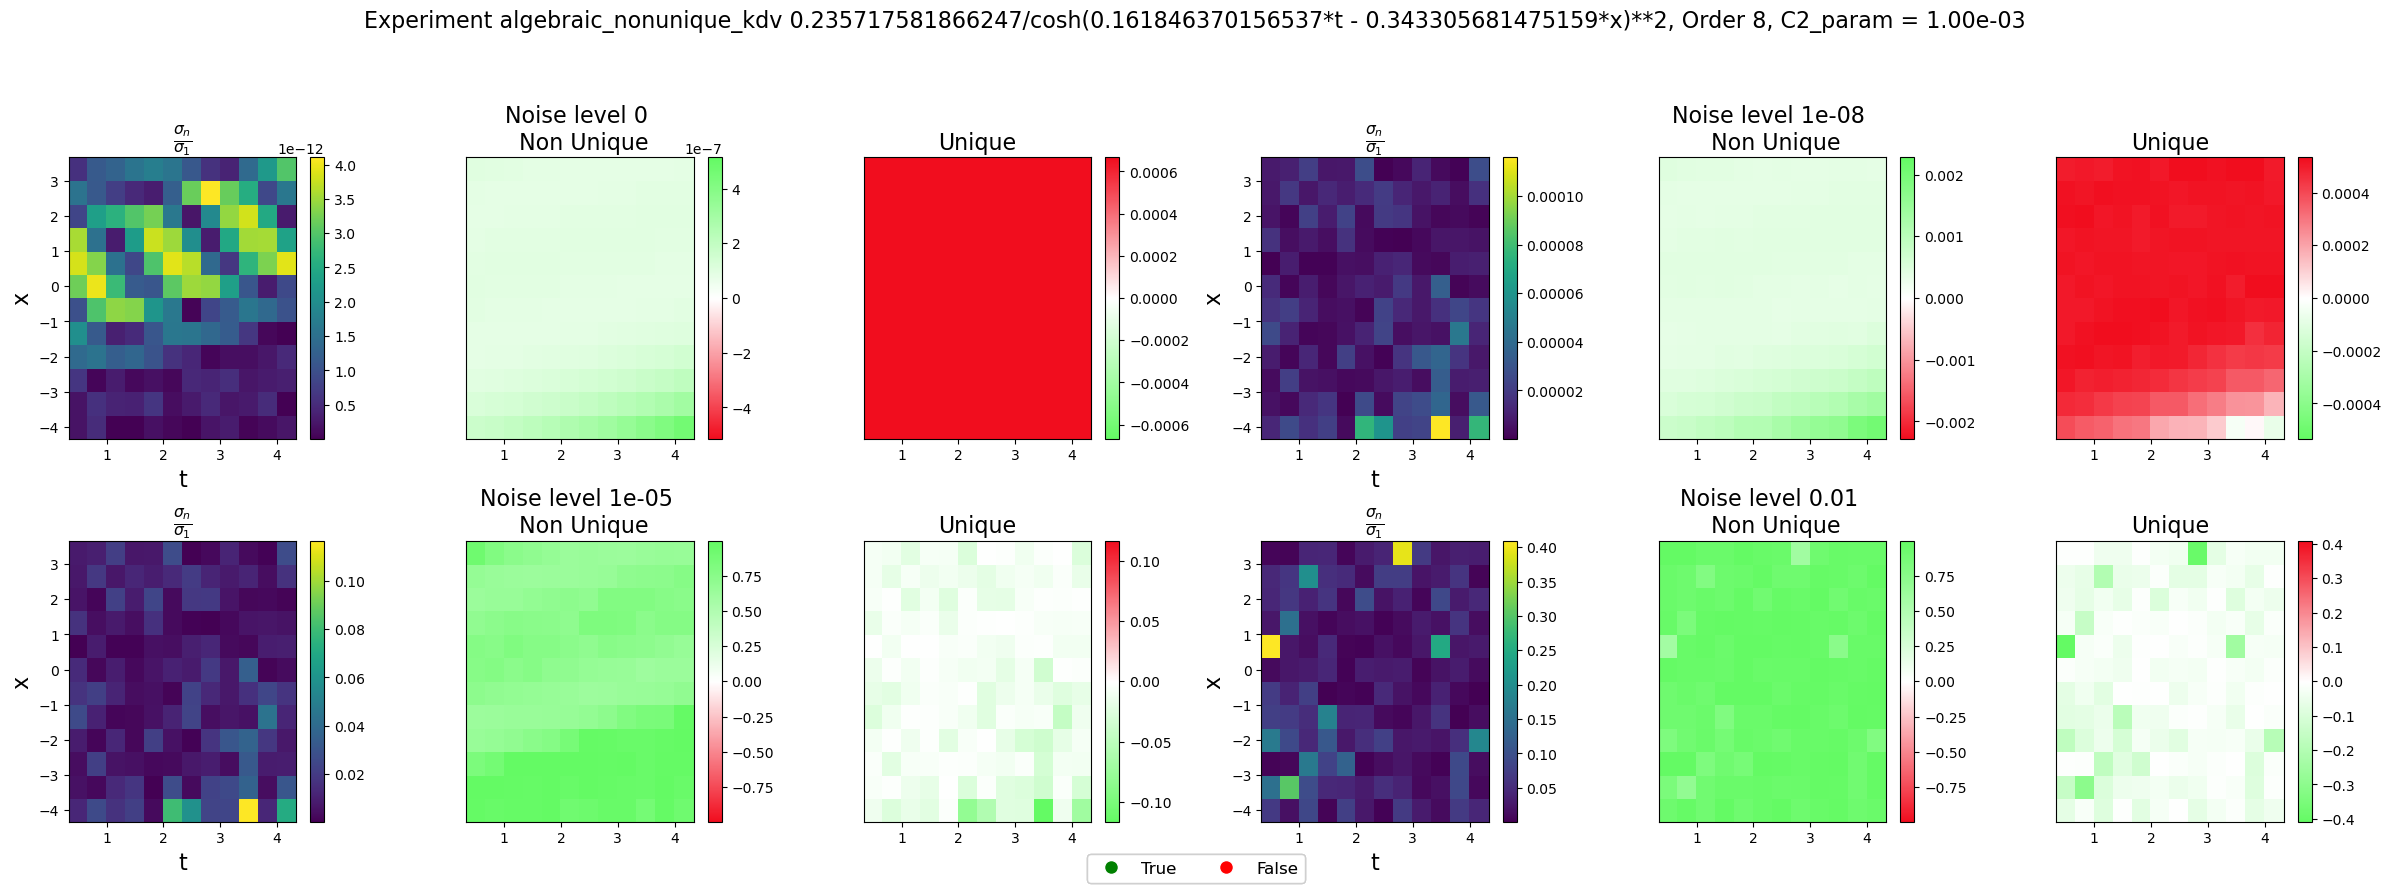

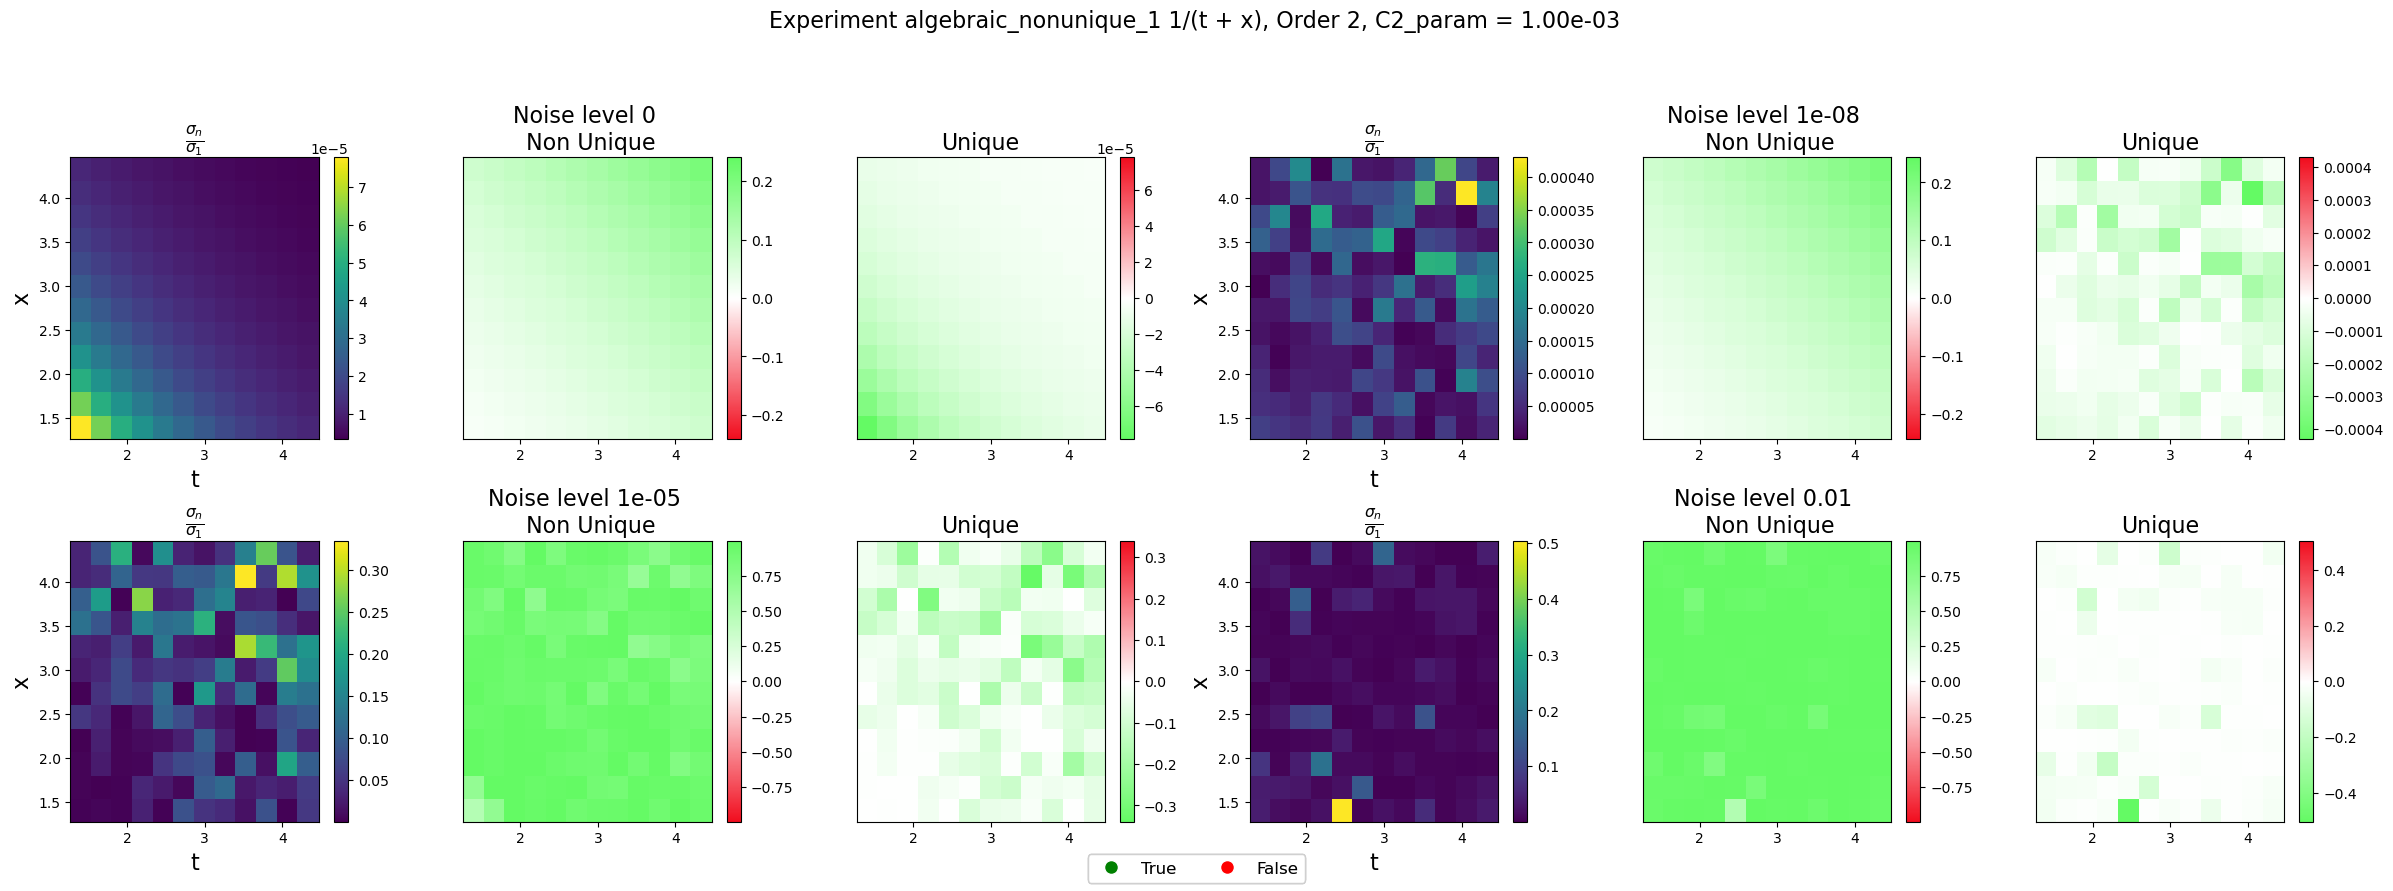

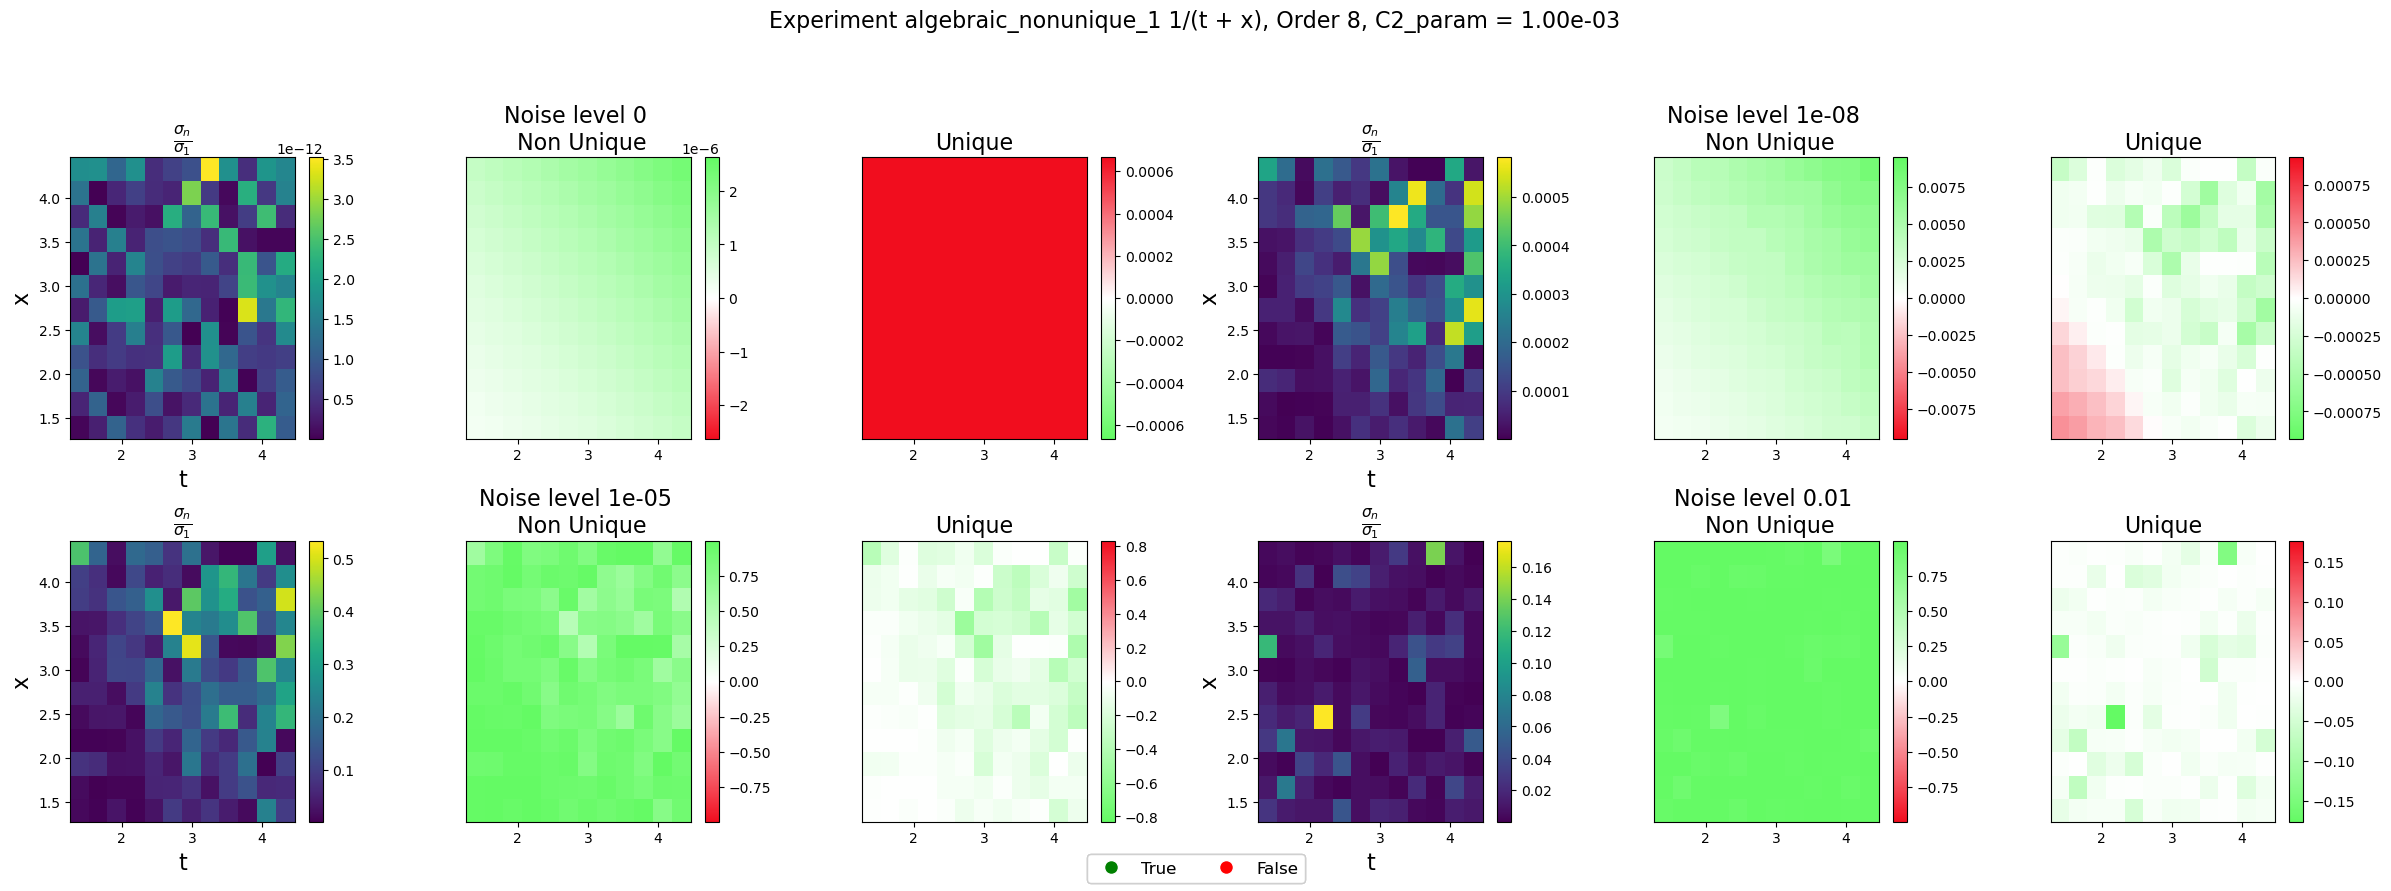

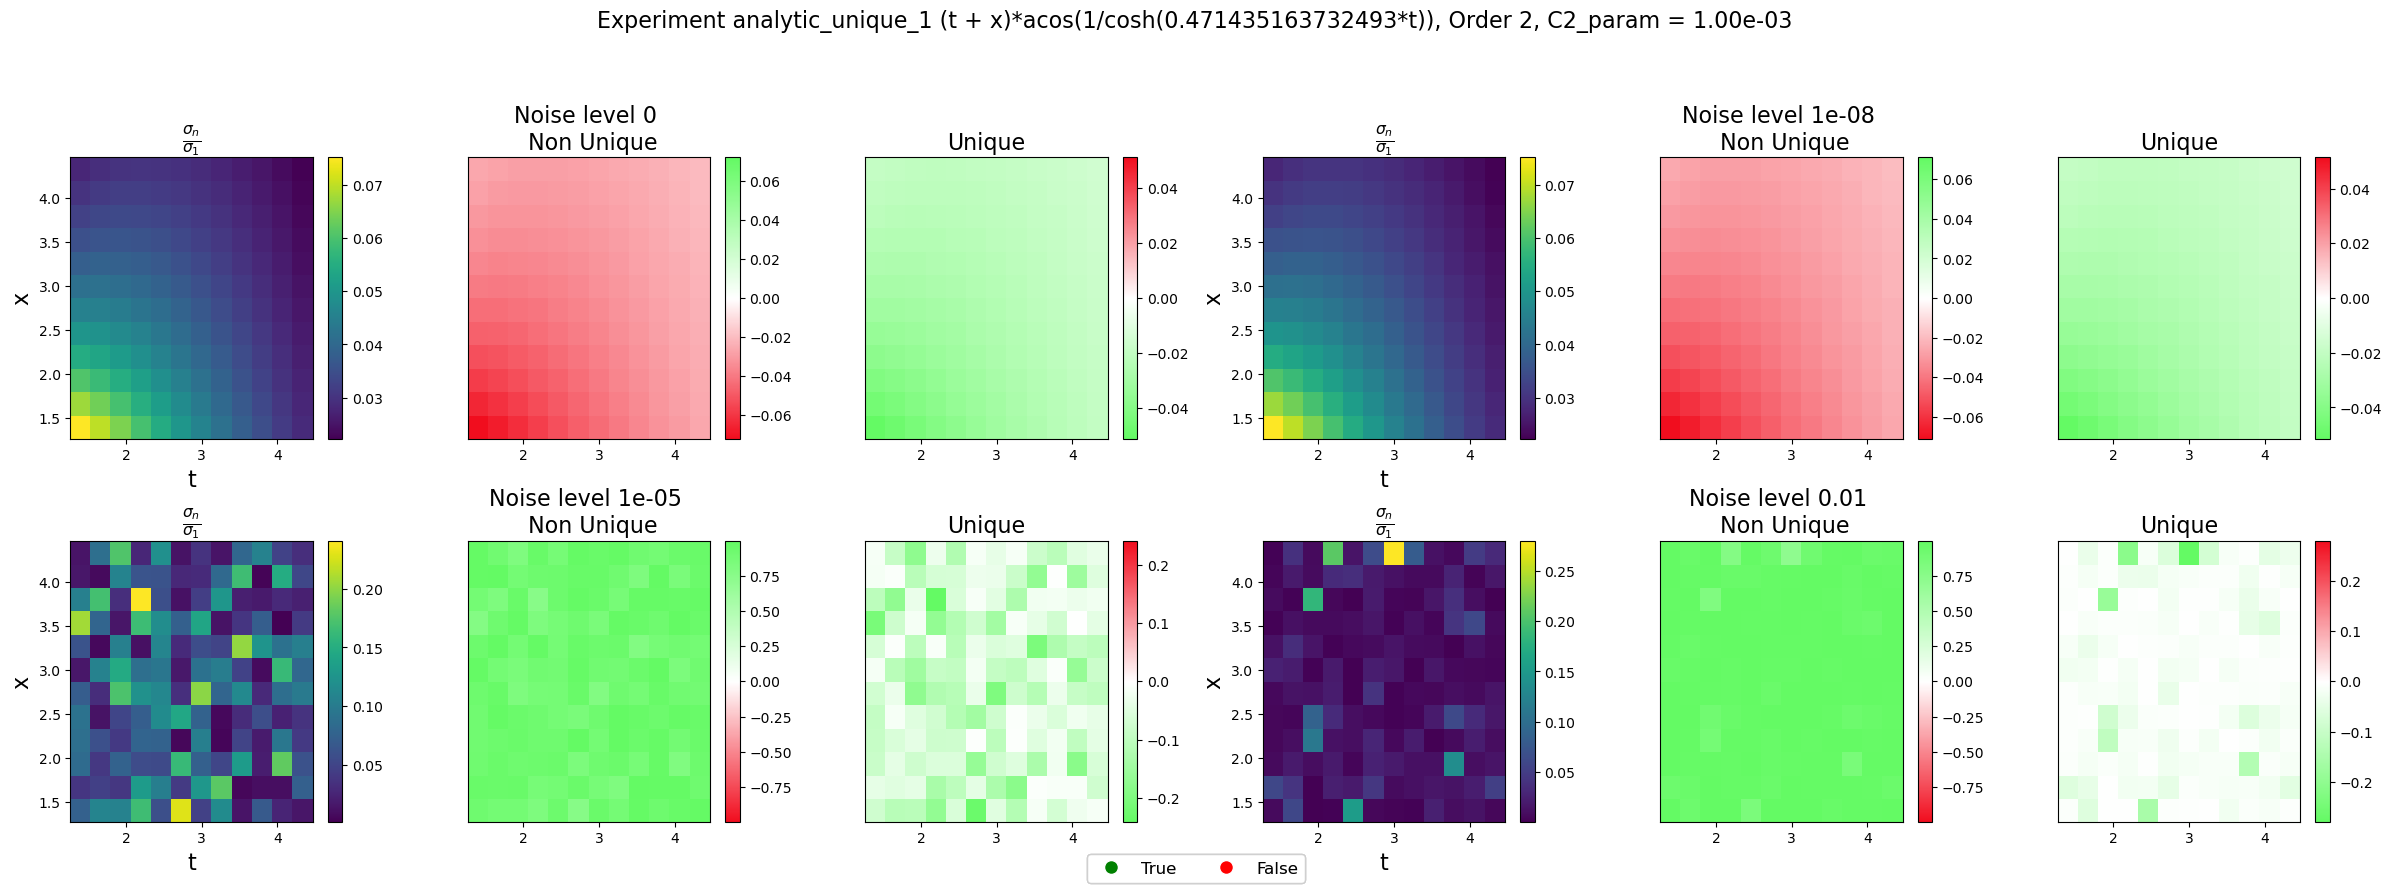

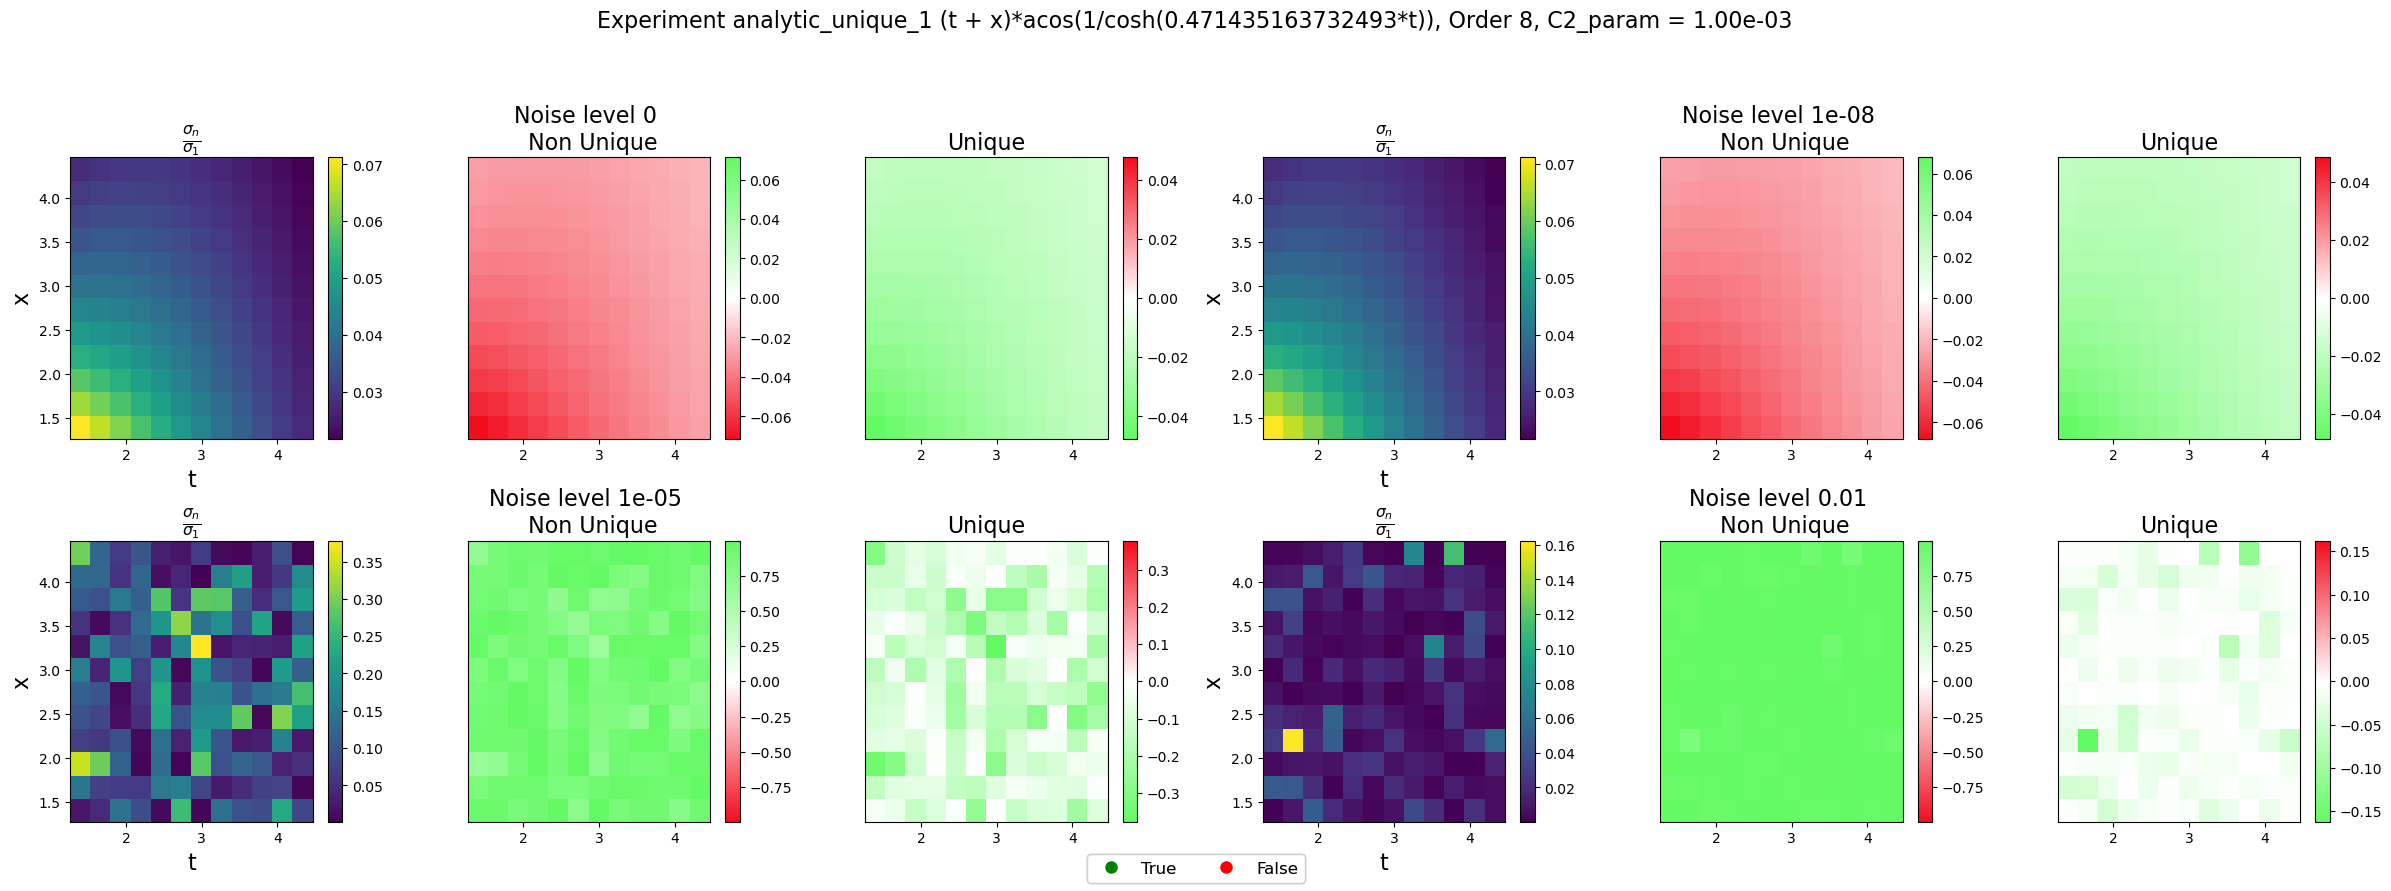

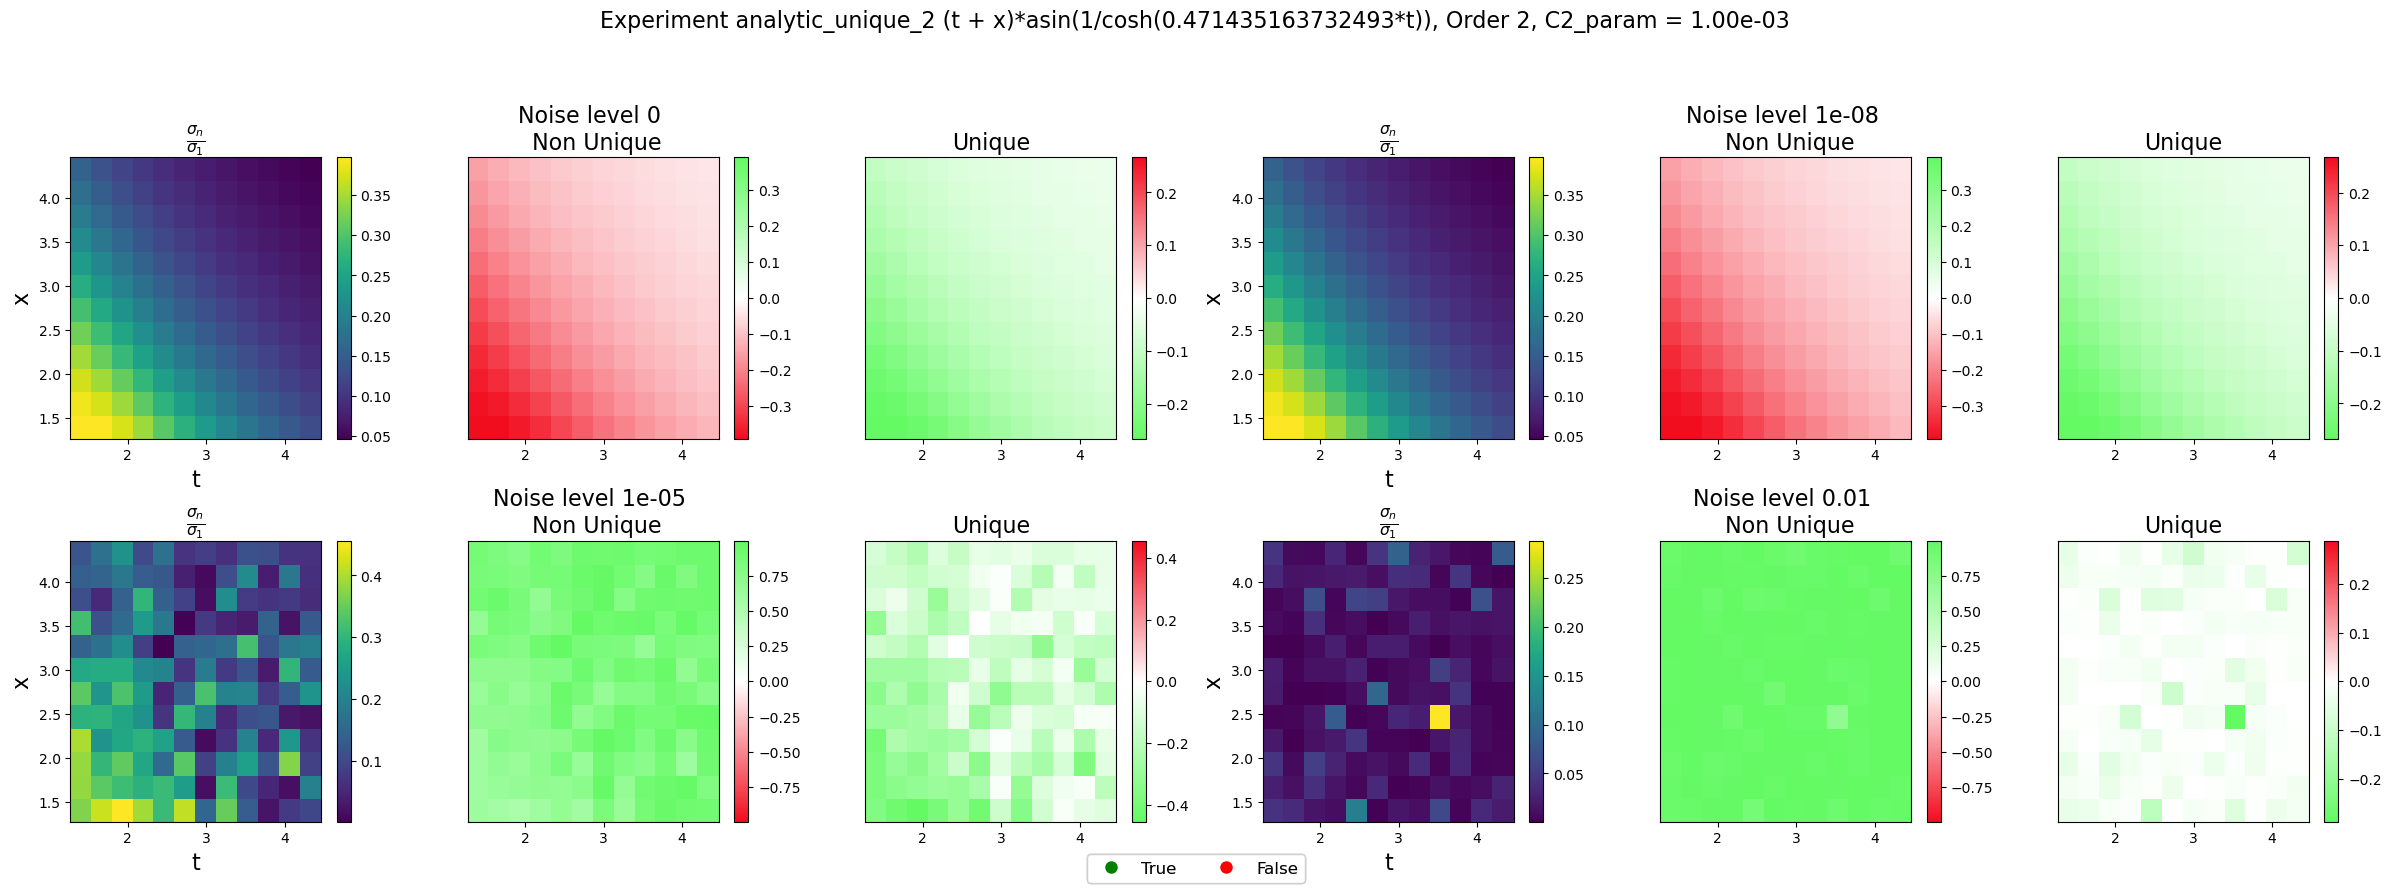

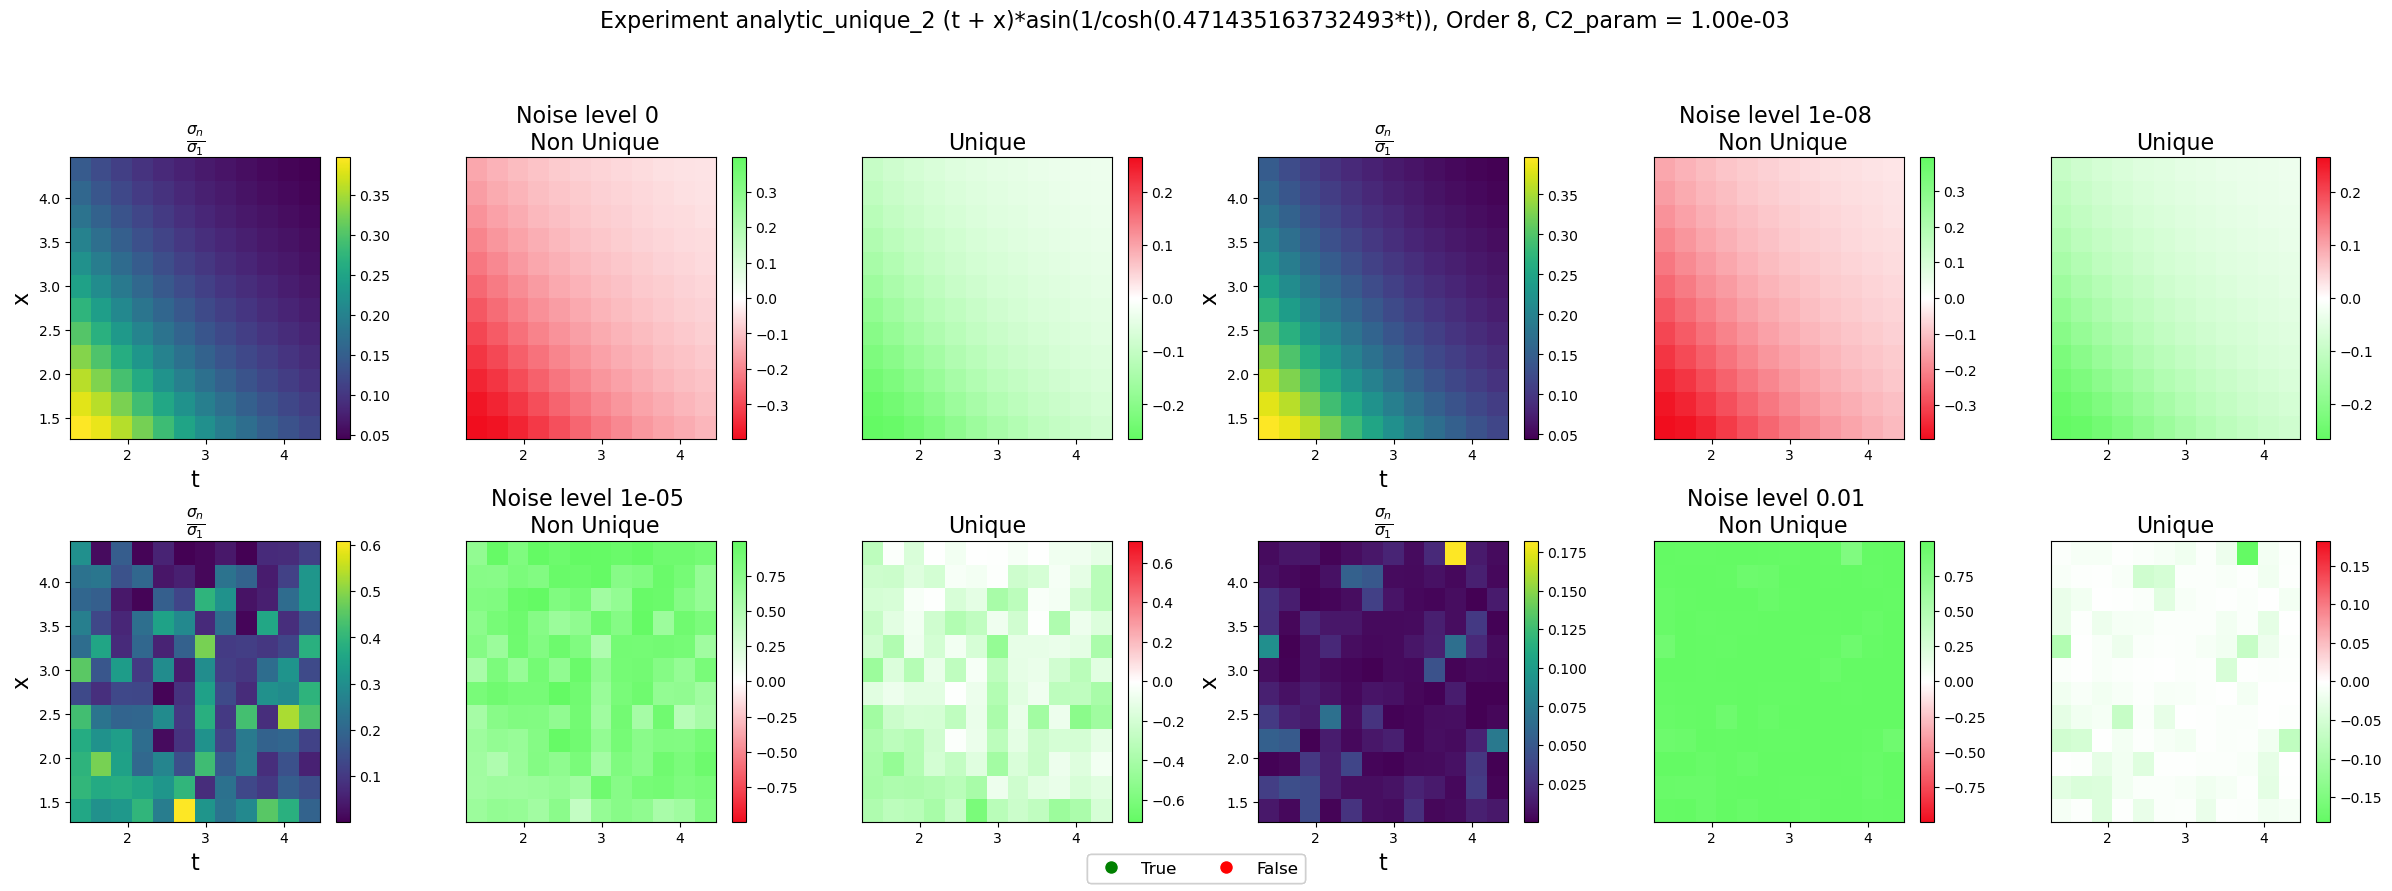

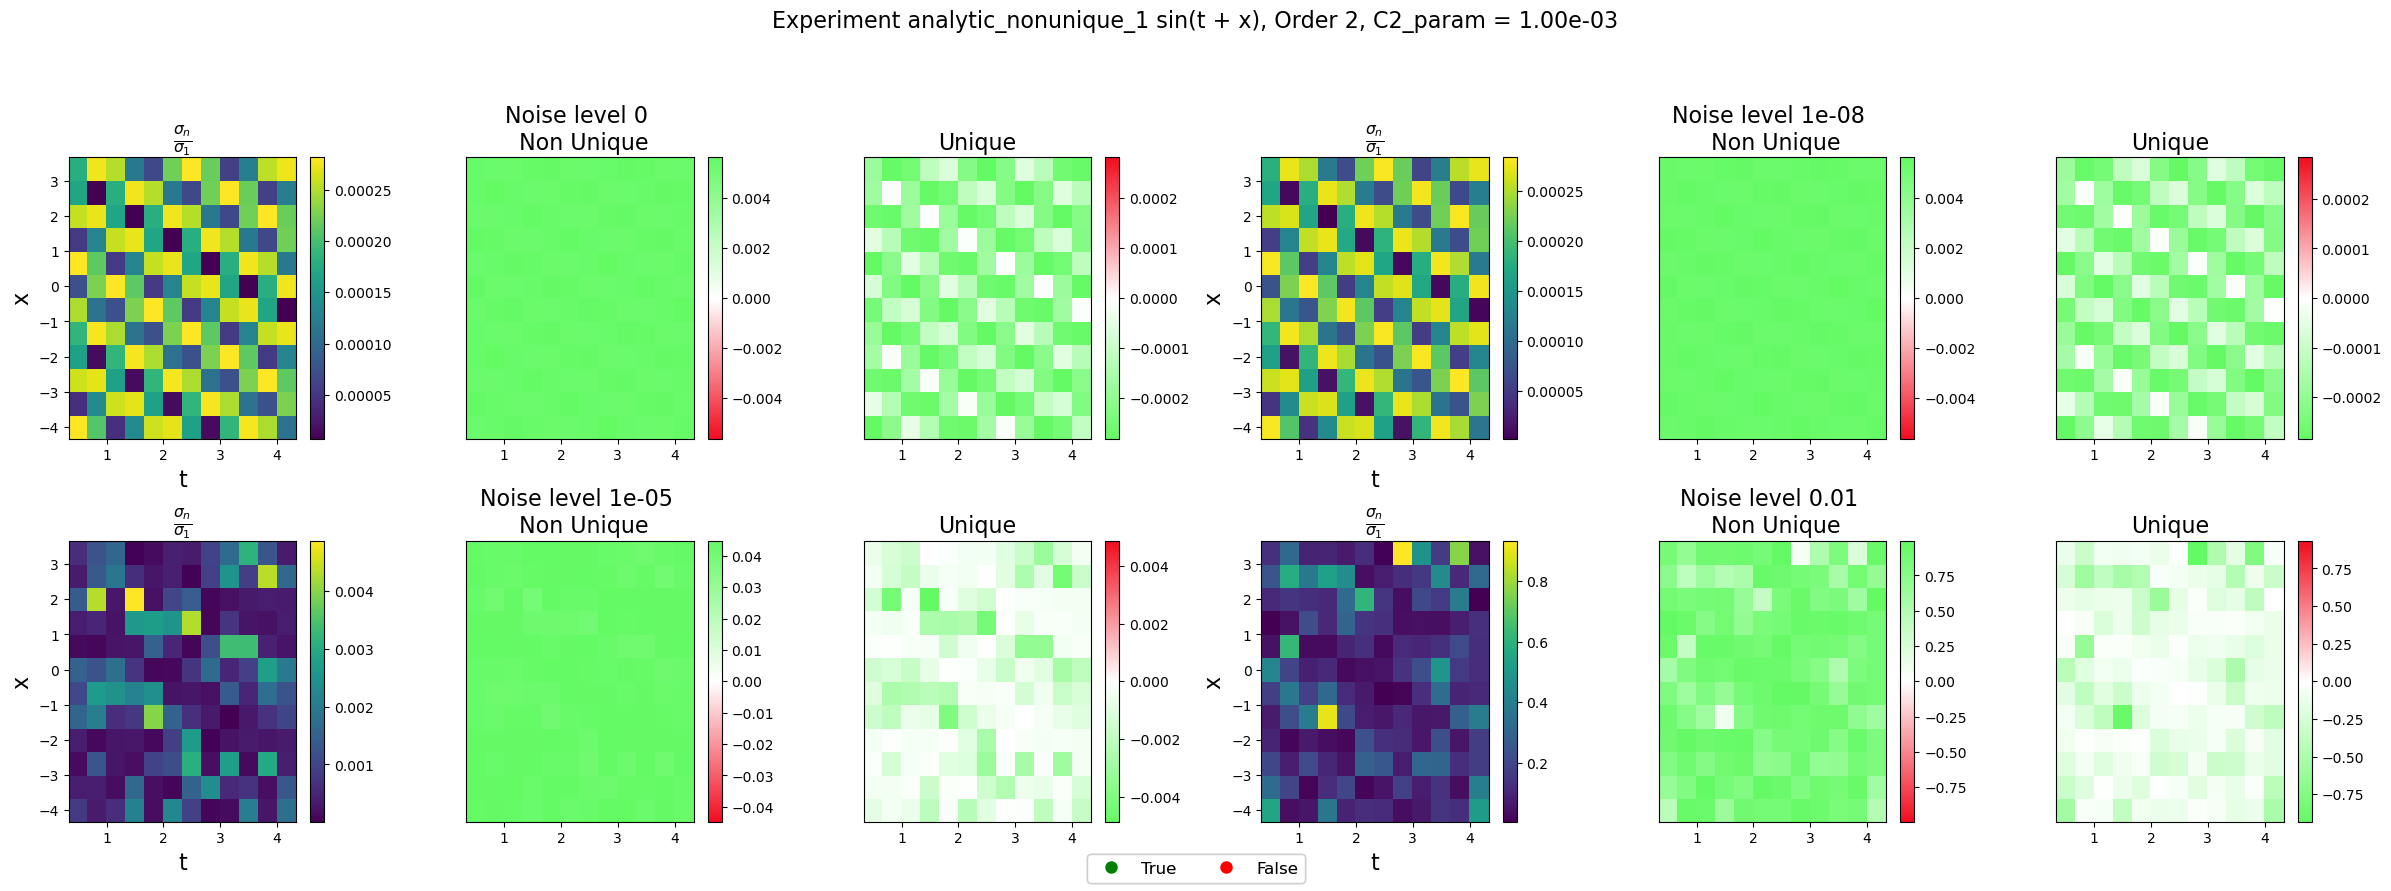

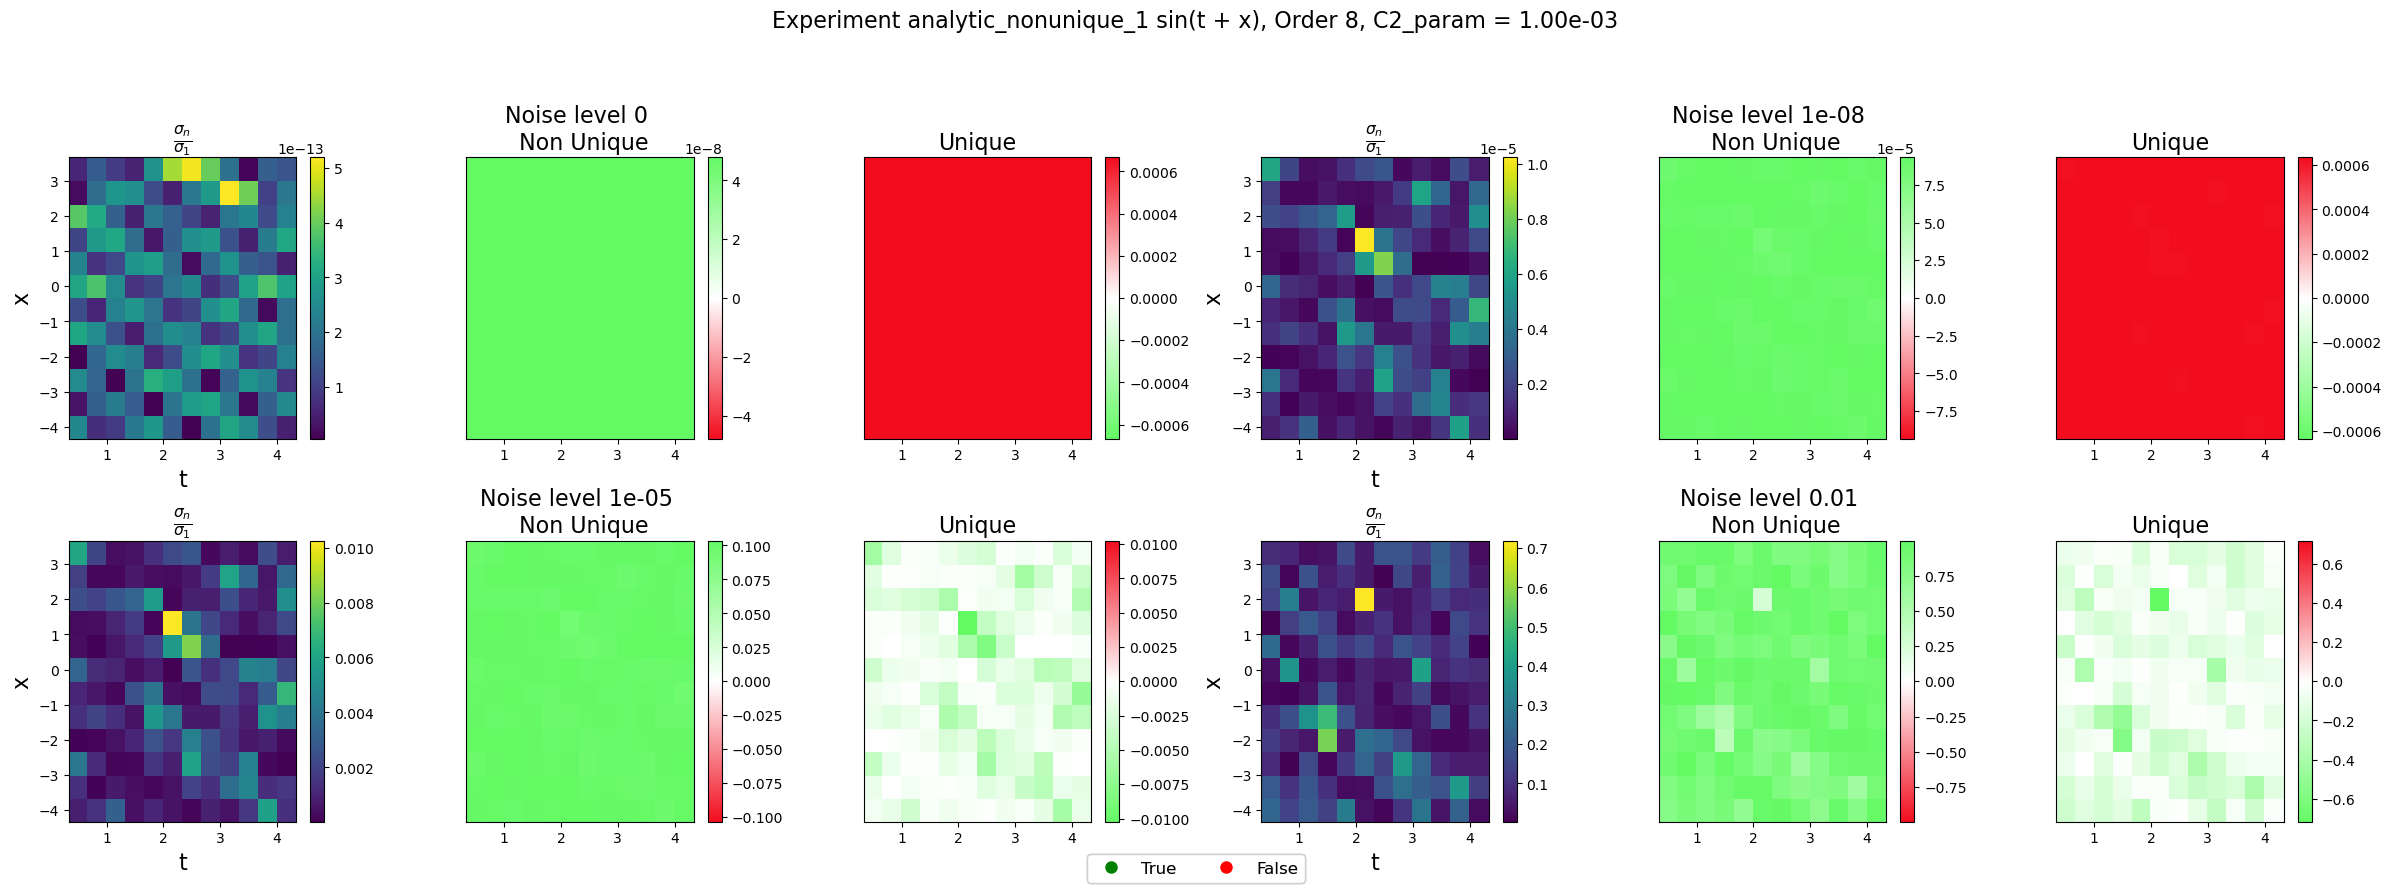

In [17]:
noise_levels = [0,1e-08,1e-05,0.01]
fd_orders=[2,8]
for experiment_name in experiment_names:
    for order in fd_orders:
        perform_experiment(noise_levels,order,experiment_name)    

## Plots paper

In [18]:
experiment_names= ['algebraic_nonunique_kdv','algebraic_nonunique_1','analytic_unique_1','analytic_unique_2','analytic_nonunique_1']
experiment_nonunique = experiment_names[1]
experiment_unique = experiment_names[3]

Performing experiment algebraic_nonunique_1 1/(t + x) with order 8, C2 = 1.00e-04


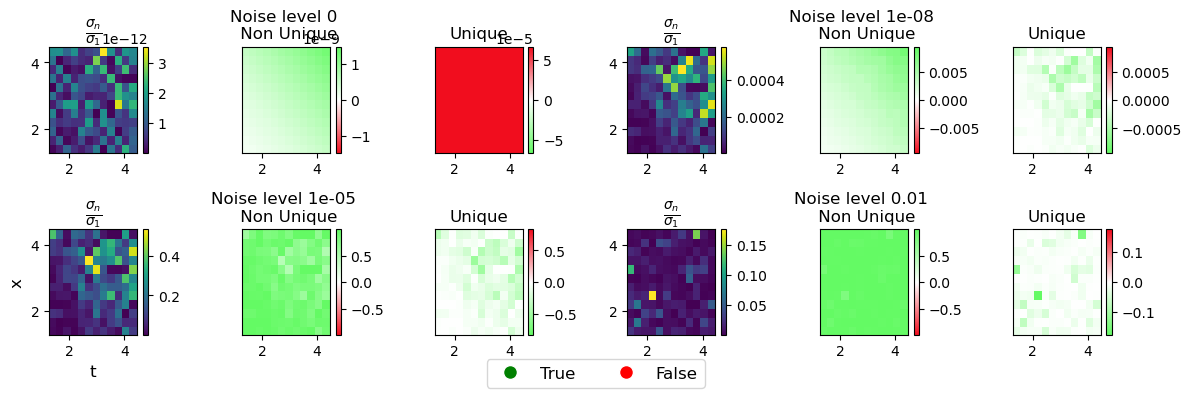

In [19]:
experiment_name = experiment_nonunique
#experiment_name = experiment_unique

tickssize = 12
labelsize = 10

u, x, t, formula = experiment_data(n_samples=150, experiment_name=experiment_name)
dx = x[1] - x[0]
dt = t[1] - t[0]
print(f"Performing experiment {experiment_name} {formula} with order {fd_order}, C2 = {C2_param:.2e}")
#subtitle = f"Experiment {experiment_name} {formula}, Order {fd_order}, C2_param = {C2_param:.2e}"
C2_param = 1e-4
T, X = np.meshgrid(t, x)
C_upper_bounds_deriv = get_Cut_Cux_Cuxx_Cutx(formula, X, T, fd_order)

fig, axes = plt.subplots(2, 6, figsize=(12, 4))

for i, noise_level in enumerate(noise_levels):

    u_noise = add_noise(u, noise_level)
    eps = infinity_norm(u - u_noise)
    
    svs, lower_bounds, upper_bounds, space_range, time_range = get_results(u_noise, C_upper_bounds_deriv, fd_order, dt, dx, eps, C2_param)   
    t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[-1] - x[0]) + x[0]

    upper_minus_svs = upper_bounds - svs
    lower_minus_svs = lower_bounds - svs
    
    max_lower_svs = np.max(np.abs(lower_minus_svs))
    max_upper_svs = np.max(np.abs(upper_minus_svs))
    max_svs = max_upper_svs

    # Plot the ratios
    c = axes[i // 2, i * 3 % 6 + 0].pcolor(t_grid, x_grid, svs)
    axes[i // 2, i * 3 % 6 + 0].set_title(r"$\frac{\sigma_n}{\sigma_1}$", fontsize=tickssize+2)
    if i==2:
        axes[i // 2, i * 3 % 6 + 0].set_ylabel('x', fontsize=tickssize)
        axes[i // 2, i * 3 % 6 + 0].set_xlabel('t', fontsize=tickssize)
    axes[i // 2, i * 3 % 6 + 0].tick_params(axis='both', which='major', labelsize=labelsize)
    cb = fig.colorbar(c, ax=axes[i // 2, i * 3 % 6])
    cb.ax.tick_params(labelsize=labelsize)

    # Plot difference to upper bound
    axes[i // 2, i * 3 % 6 + 1].set_title(f'Noise level {noise_level} \n Non Unique', fontsize=tickssize)
    c = axes[i // 2, i * 3 % 6 + 1].pcolor(t_grid, x_grid, upper_minus_svs, cmap=cmap_red_green, vmin=-max_svs, vmax=max_svs)
    axes[i // 2, i * 3 % 6 + 1].set_yticks([])
    axes[i // 2, i * 3 % 6 + 1].tick_params(axis='both', which='major', labelsize=labelsize)
    cb = fig.colorbar(c, ax=axes[i // 2, i * 3 % 6 + 1])
    cb.ax.tick_params(labelsize=labelsize)
    
    # Plot difference to lower bound
    max_svs = max_lower_svs
    axes[i // 2, i * 3 % 6 + 2].set_title('Unique', fontsize=tickssize)
    c = axes[i // 2, i * 3 % 6 + 2].pcolor(t_grid, x_grid, lower_minus_svs, cmap=cmap_green_red, vmin=-max_svs, vmax=max_svs)
    axes[i // 2, i * 3 % 6 + 2].set_yticks([])
    axes[i // 2, i * 3 % 6 + 2].tick_params(axis='both', which='major', labelsize=labelsize)
    cb = fig.colorbar(c, ax=axes[i // 2, i * 3 % 6 + 2])
    cb.ax.tick_params(labelsize=labelsize)

# Plot legend for True and False
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='True'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='False')
]

fig.legend(handles=legend_elements, loc='lower center', ncol=2, fontsize=tickssize)

# Adjust subplot layout to make room for the legends
sp = 0.8
#plt.subplots_adjust(left=None, bottom=0.3, right=None, wspace=sp, hspace=1.2)
plt.tight_layout()
plt.savefig(f"Paper/jrc_{experiment_name}_order{fd_order}.png")
plt.savefig(f"Paper/jrc_{experiment_name}_order{fd_order}.svg",format="svg")
plt.show()

### Try different C2 values for a specific example and see how it influences the result

#### Plot the pictures from before

C2 = max(1.000e+00 * sv_max,0.5*sv_min)
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e+00
C2 = max(1.000e-01 * sv_max,0.5*sv_min)
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-01
C2 = max(1.000e-03 * sv_max,0.5*sv_min)
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-03
C2 = max(1.000e-04 * sv_max,0.5*sv_min)
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-04
C2 = max(1.000e-05 * sv_max,0.5*sv_min)
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-05
C2 = max(1.000e-06 * sv_max,0.5*sv_min)
Performing experiment algebraic_nonunique_kdv

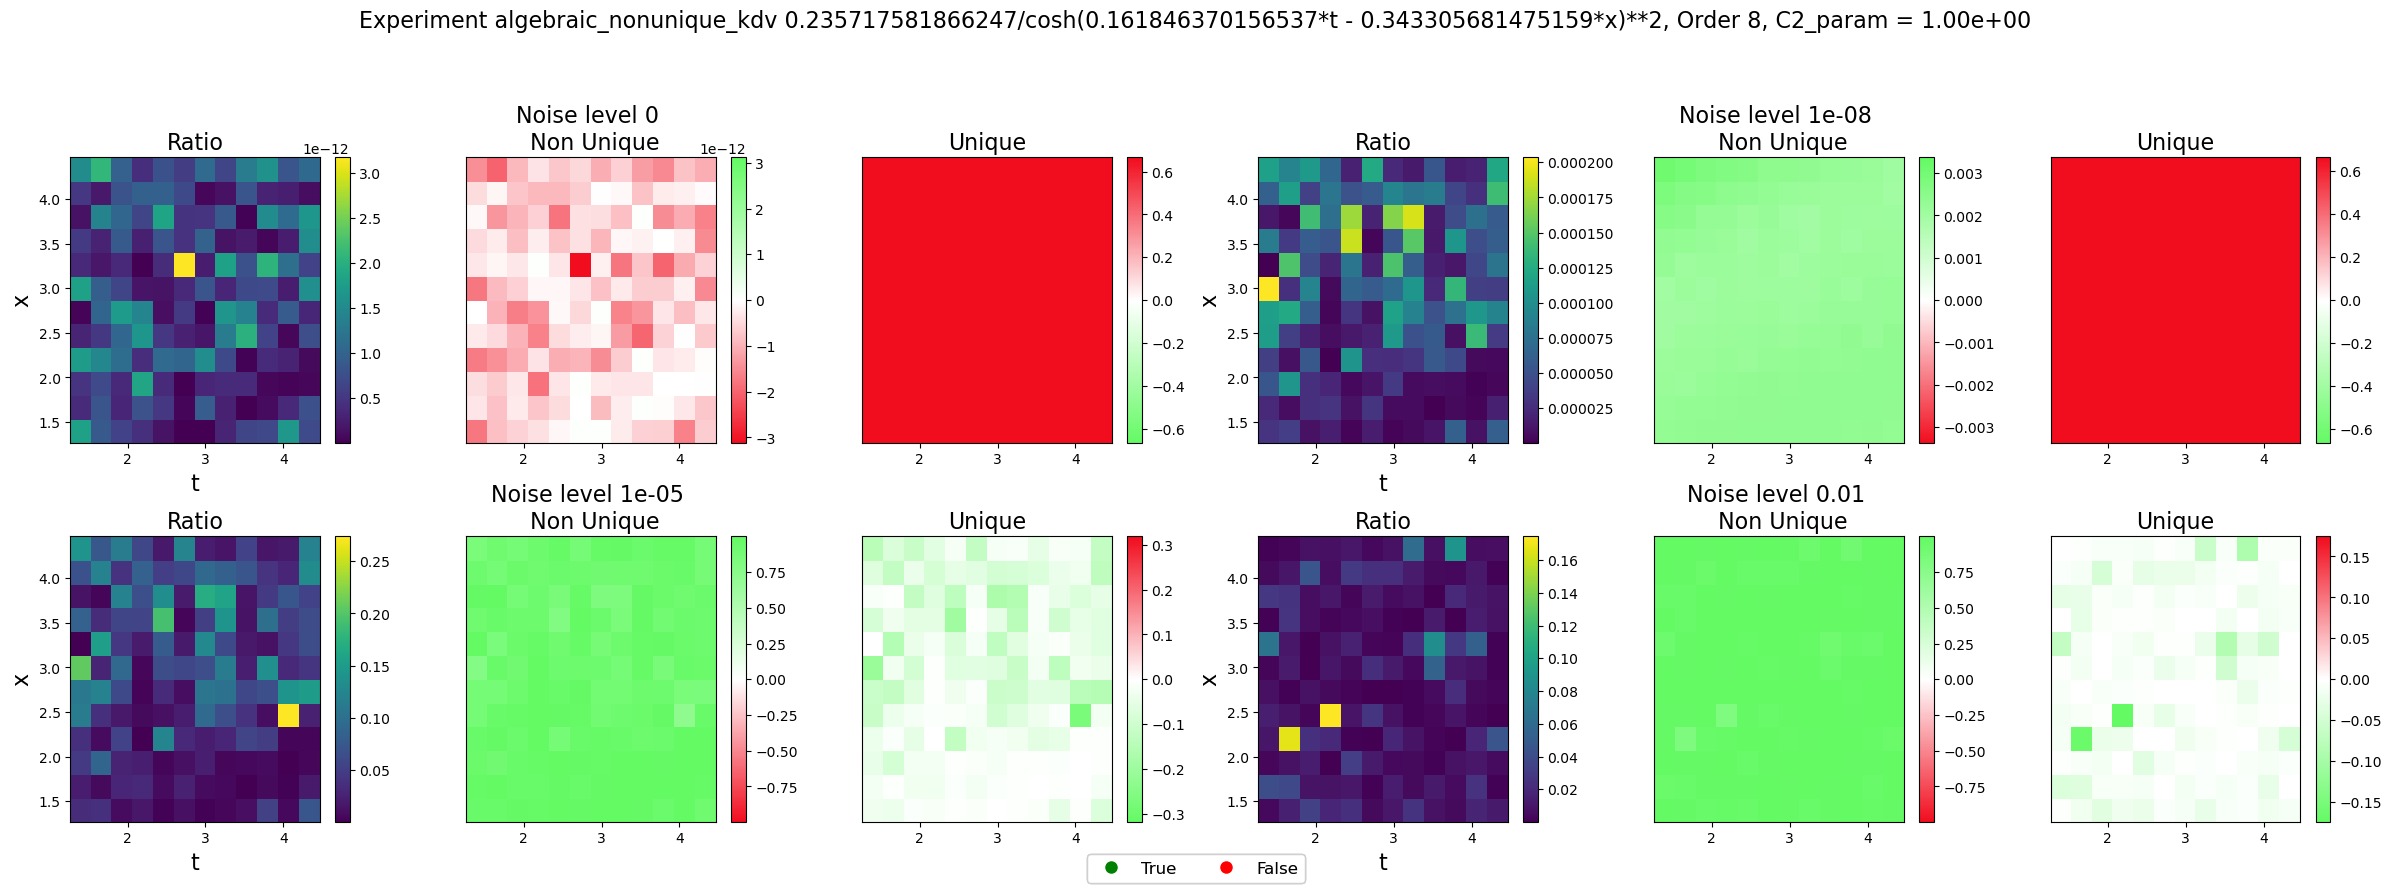

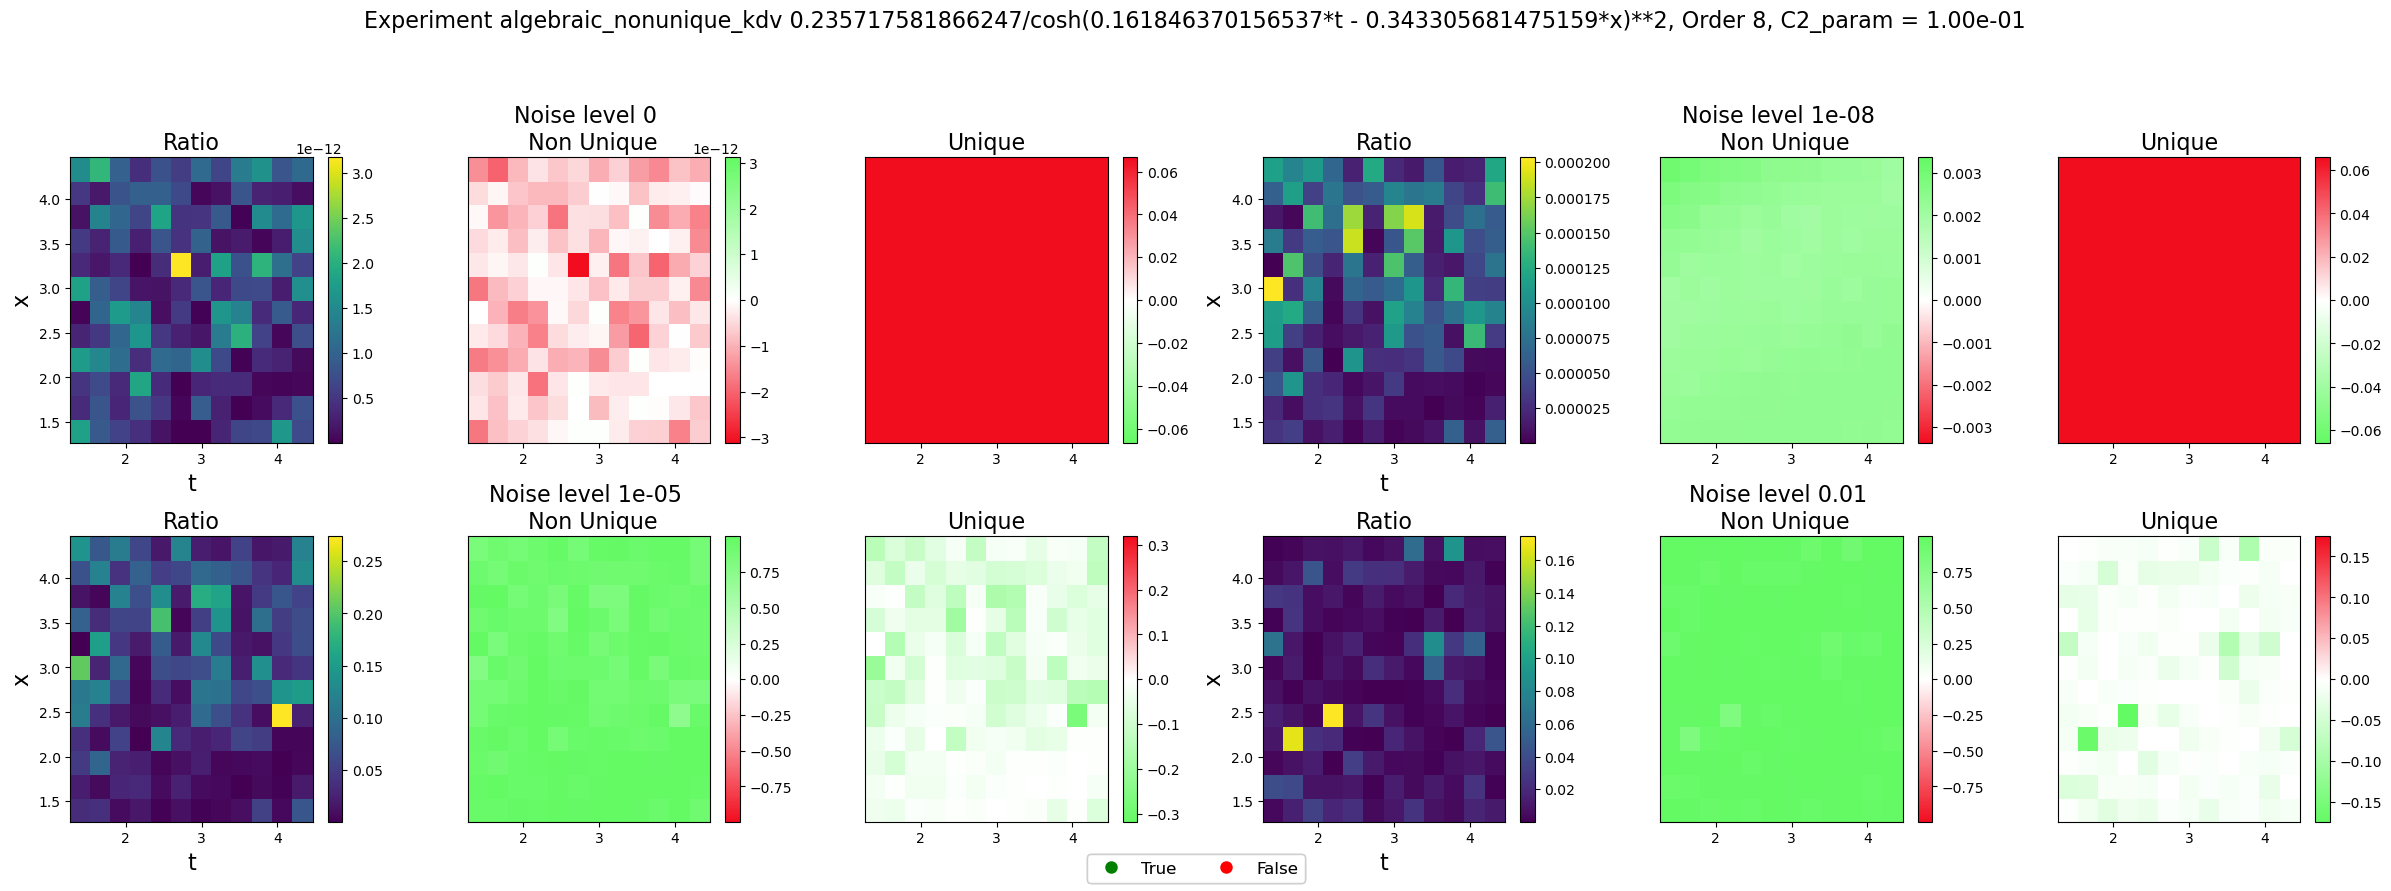

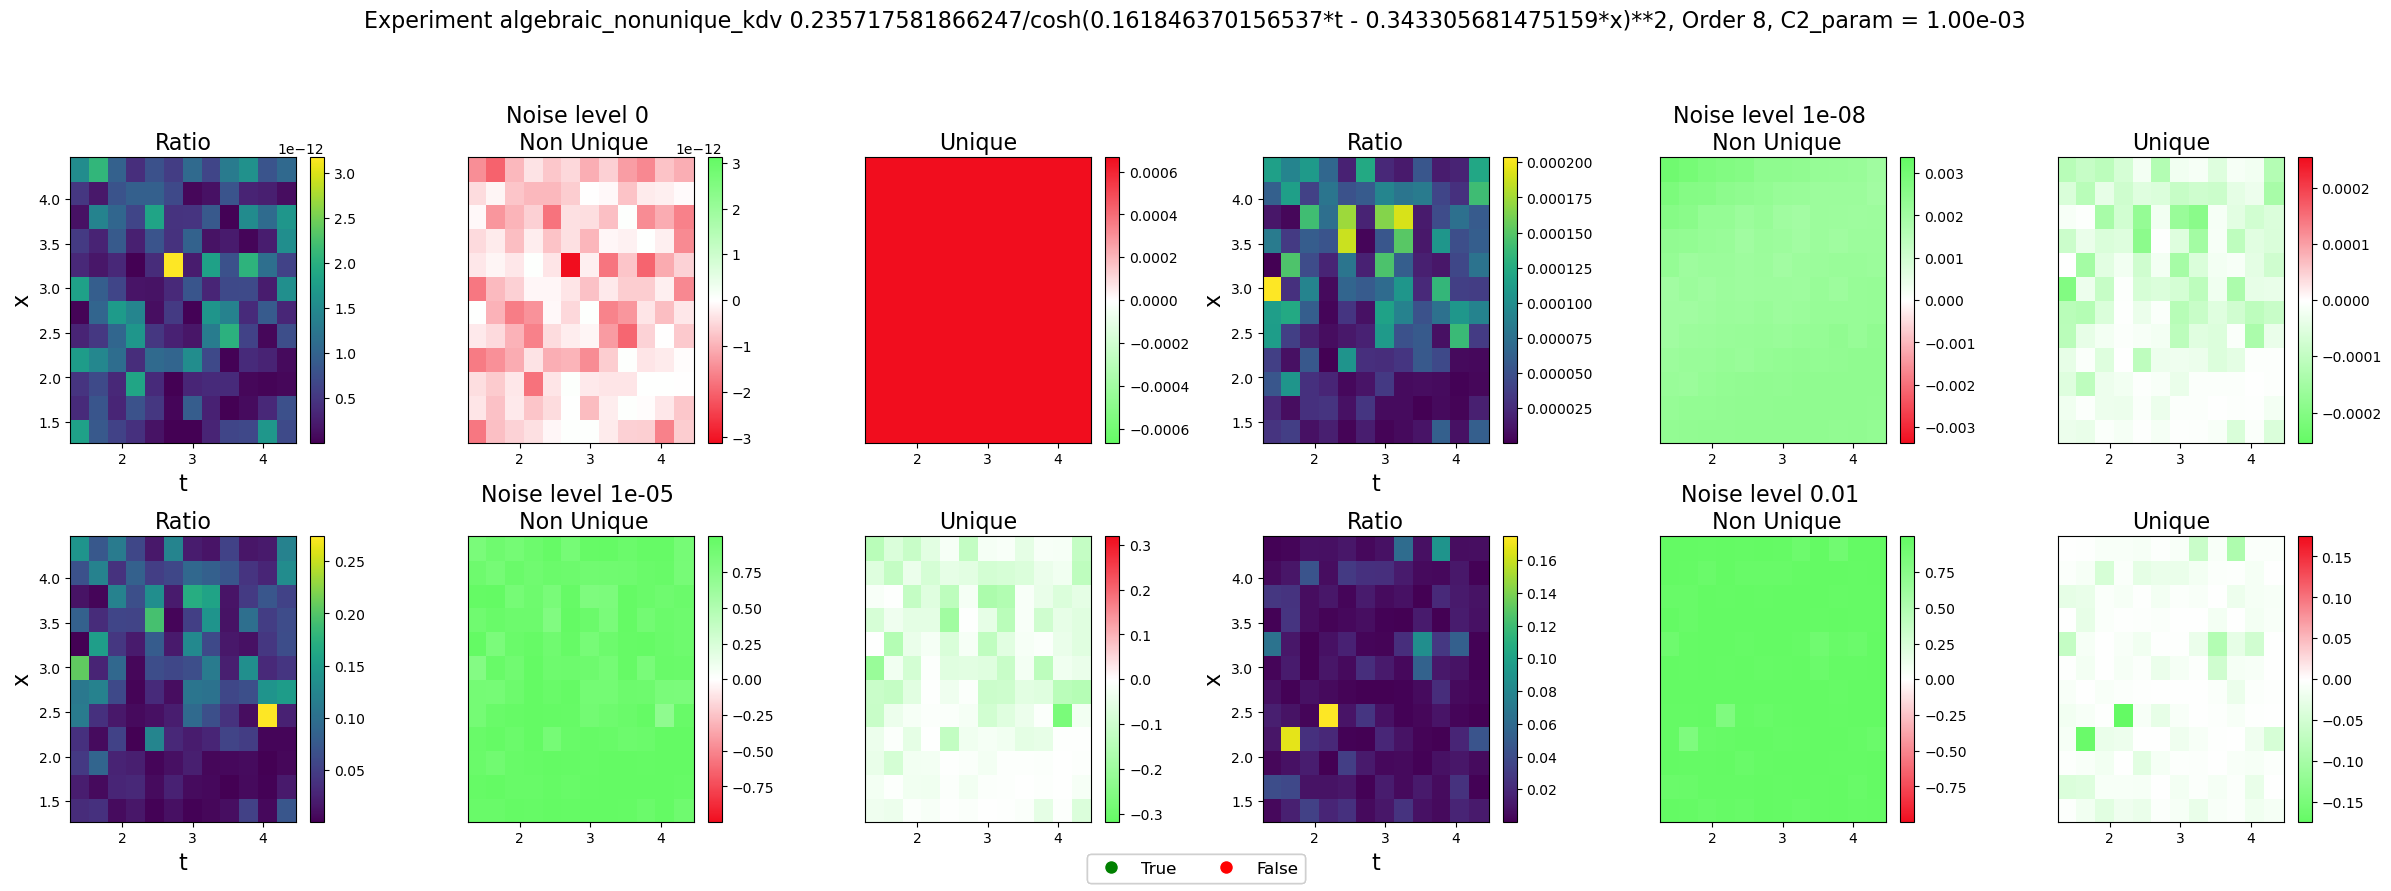

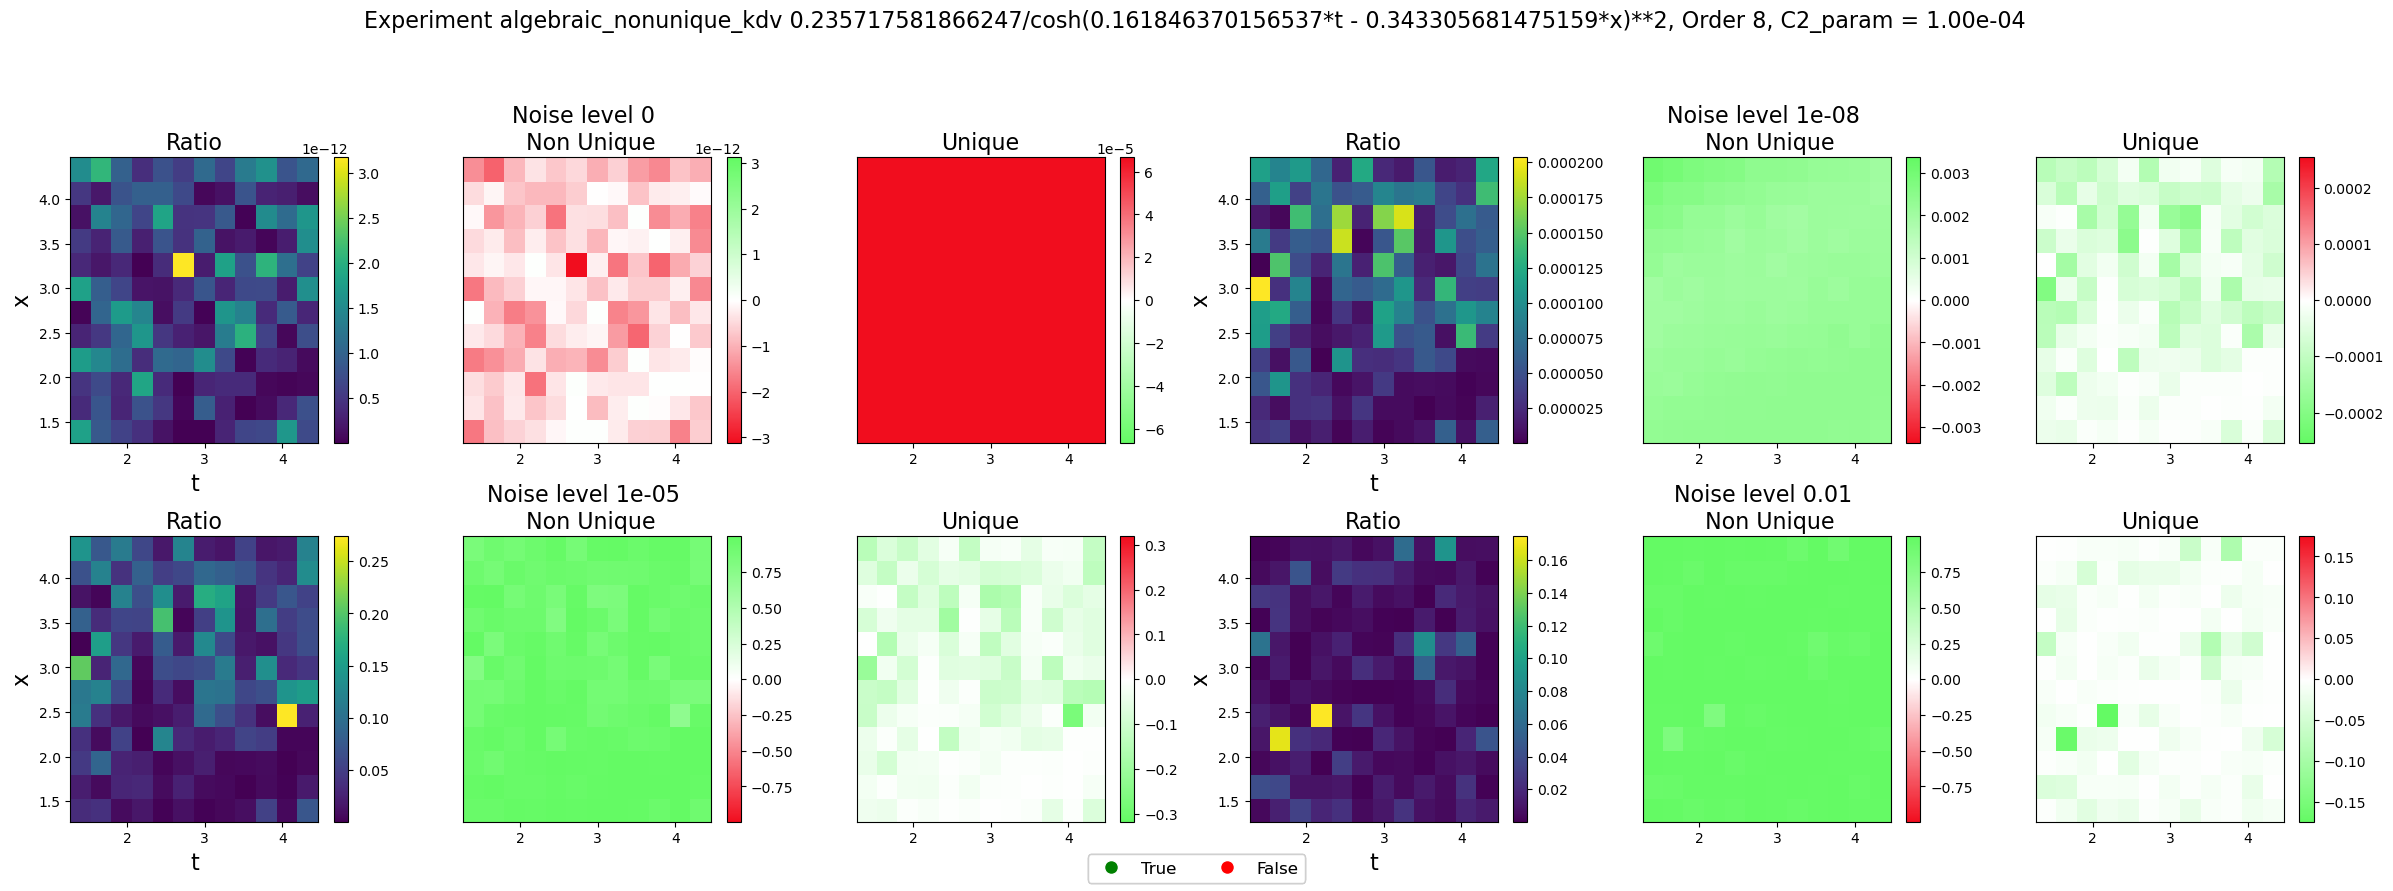

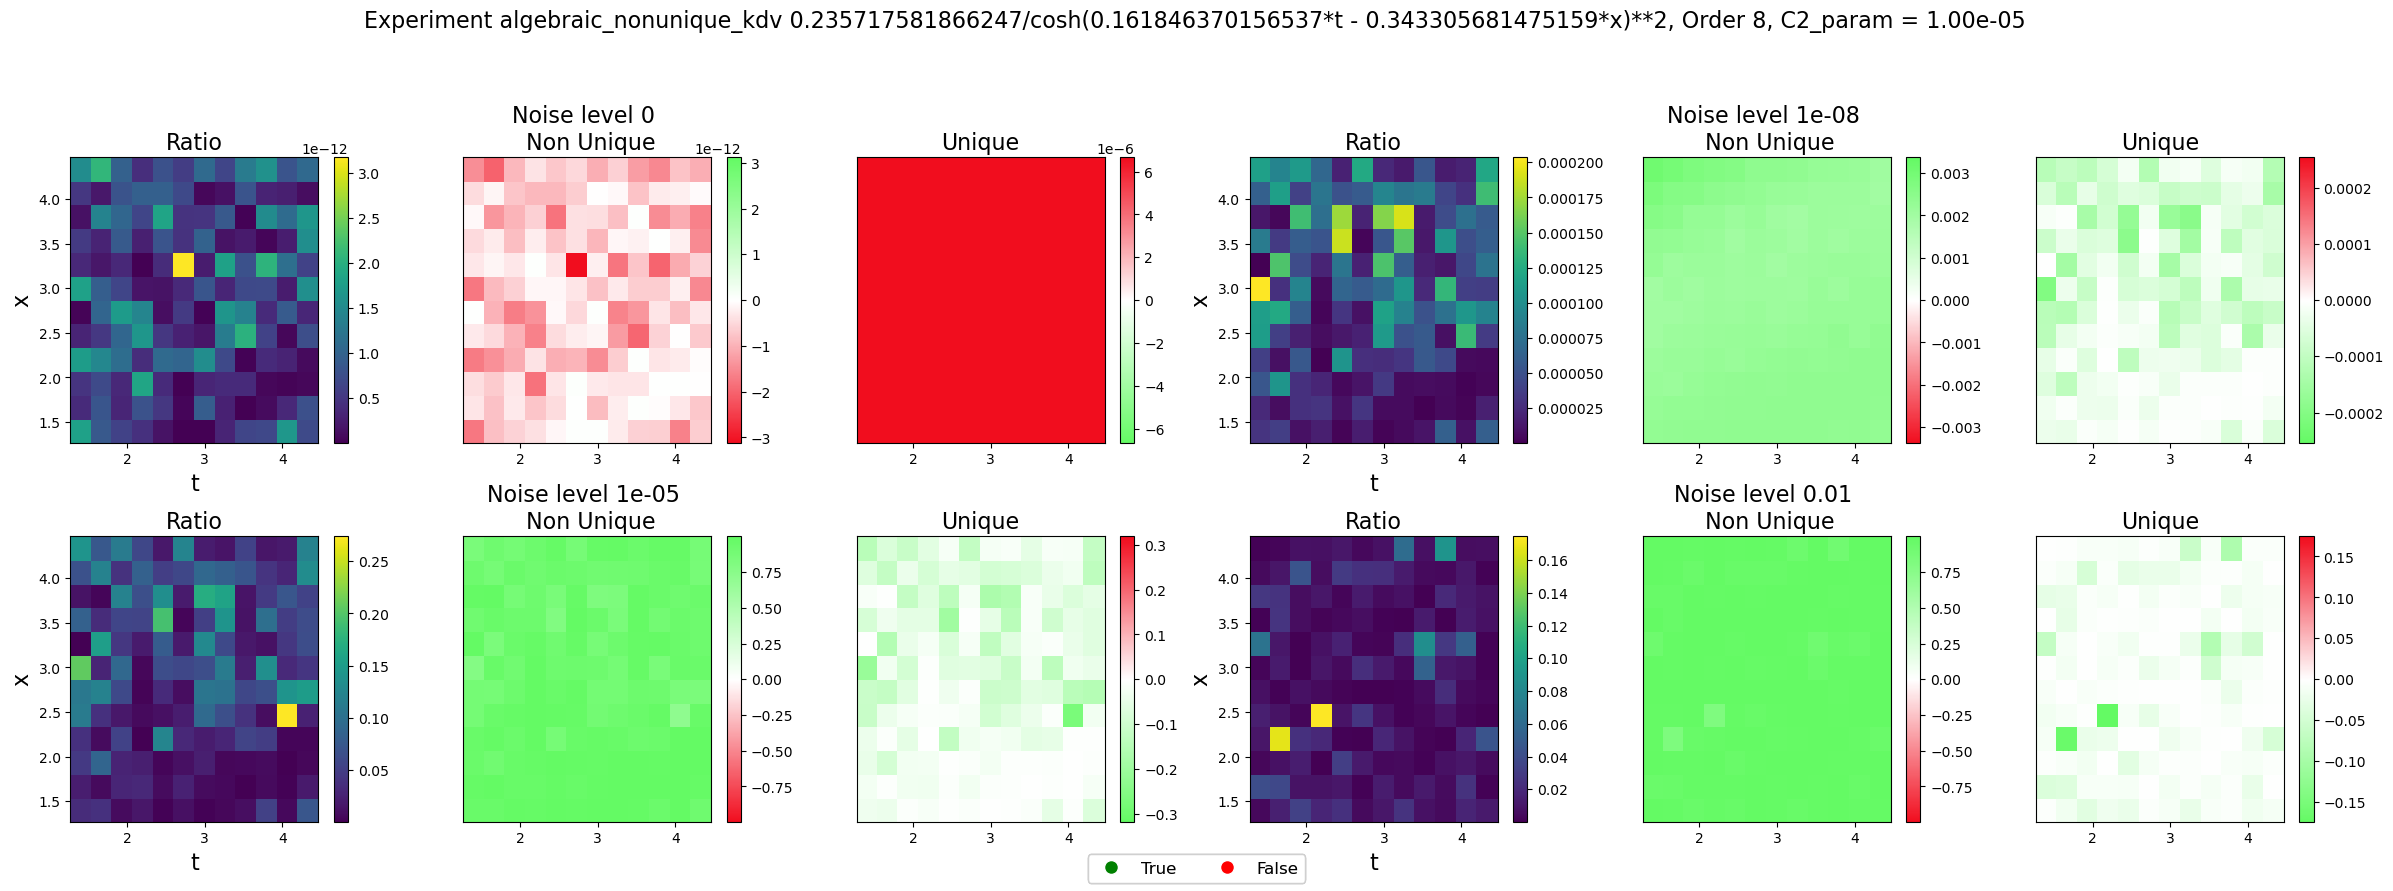

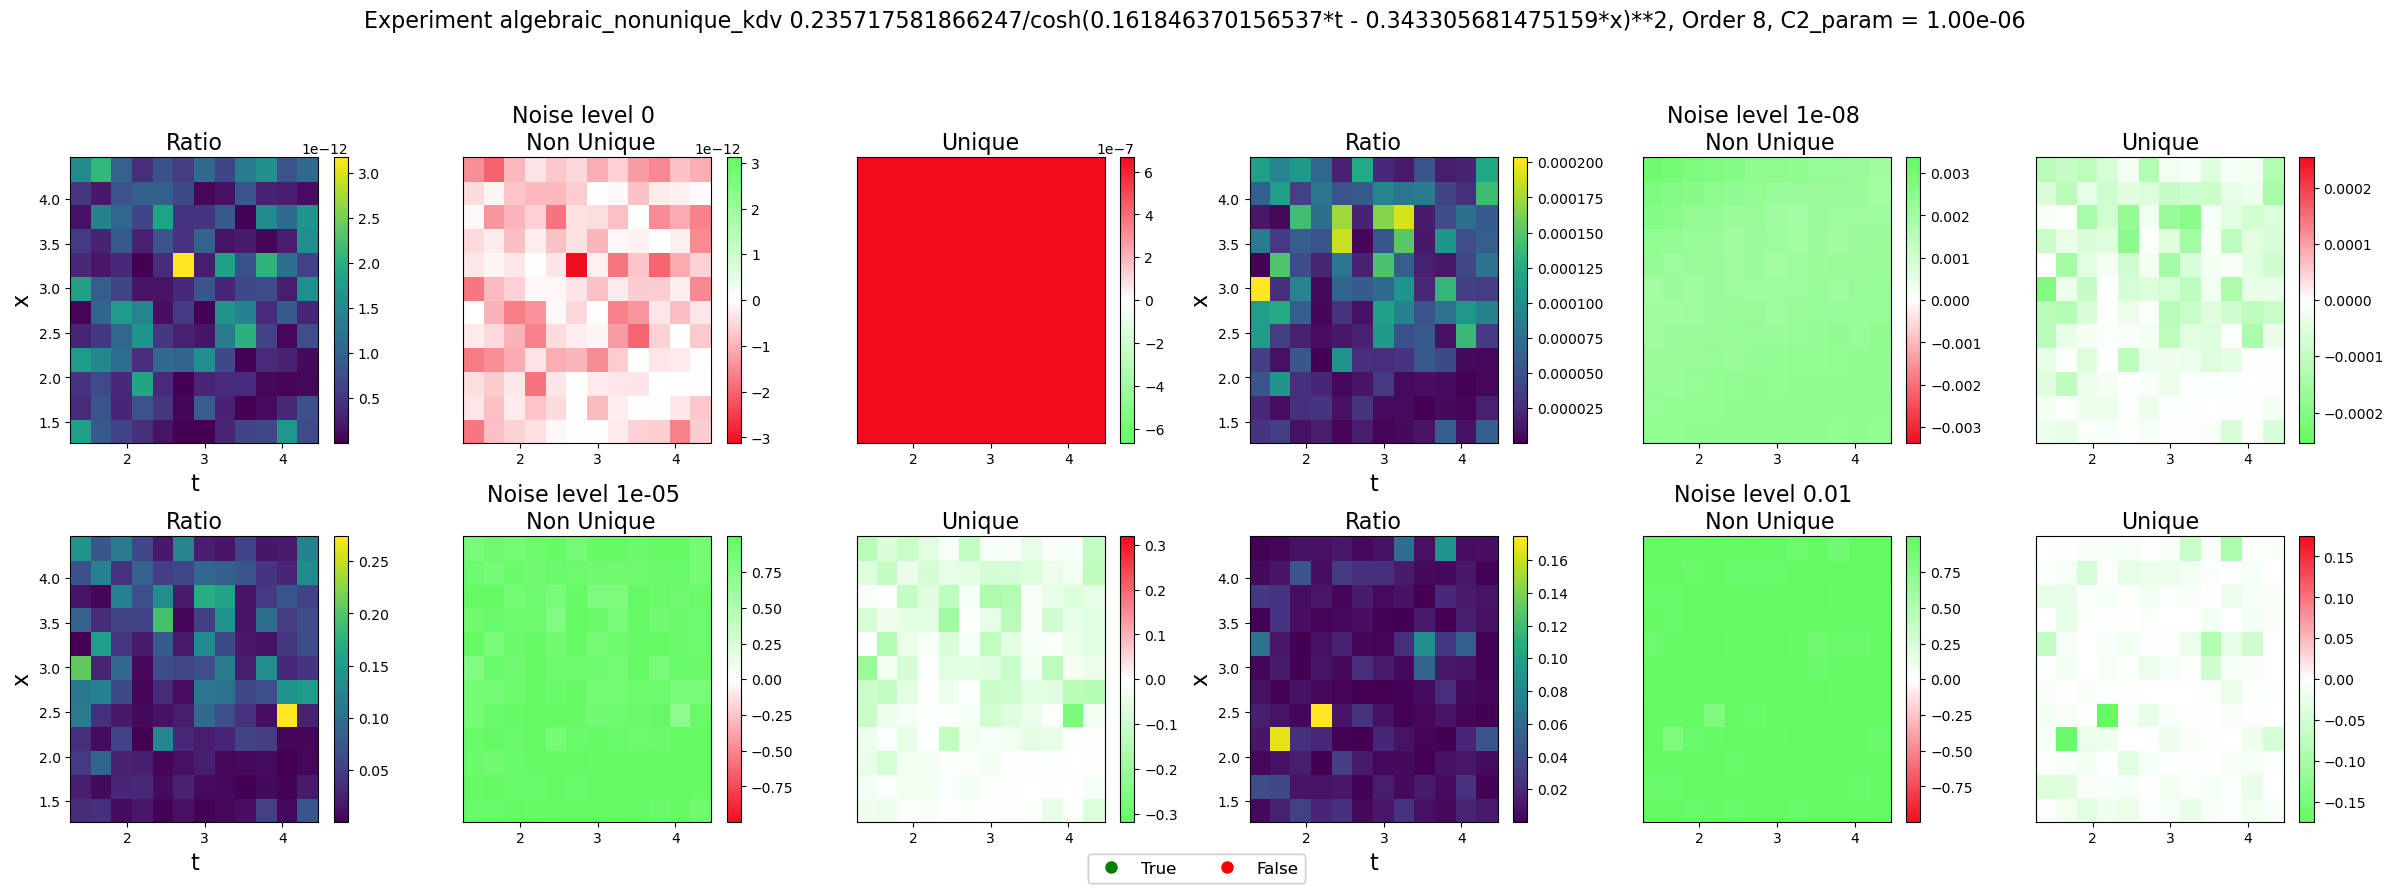

In [26]:
# Non unique example
experiment_name = experiment_names[0]
fd_orders=[8]
C2_params=[1.0,1e-1,1e-3,1e-4,1e-5,1e-6]
for C2_param in C2_params:
    print(f"C2 = max({C2_param:.3e} * sv_max,0.5*sv_min)")
    perform_experiment(noise_levels,order,experiment_name,C2_param)    

C2 = max(1.000e+00 * sv_max,0.5*sv_min)
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e+00
C2 = max(1.000e-01 * sv_max,0.5*sv_min)
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e-01
C2 = max(1.000e-03 * sv_max,0.5*sv_min)
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e-03
C2 = max(1.000e-04 * sv_max,0.5*sv_min)
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e-04
C2 = max(1.000e-05 * sv_max,0.5*sv_min)
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e-05
C2 = max(1.000e-06 * sv_max,0.5*sv_min)
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e-06


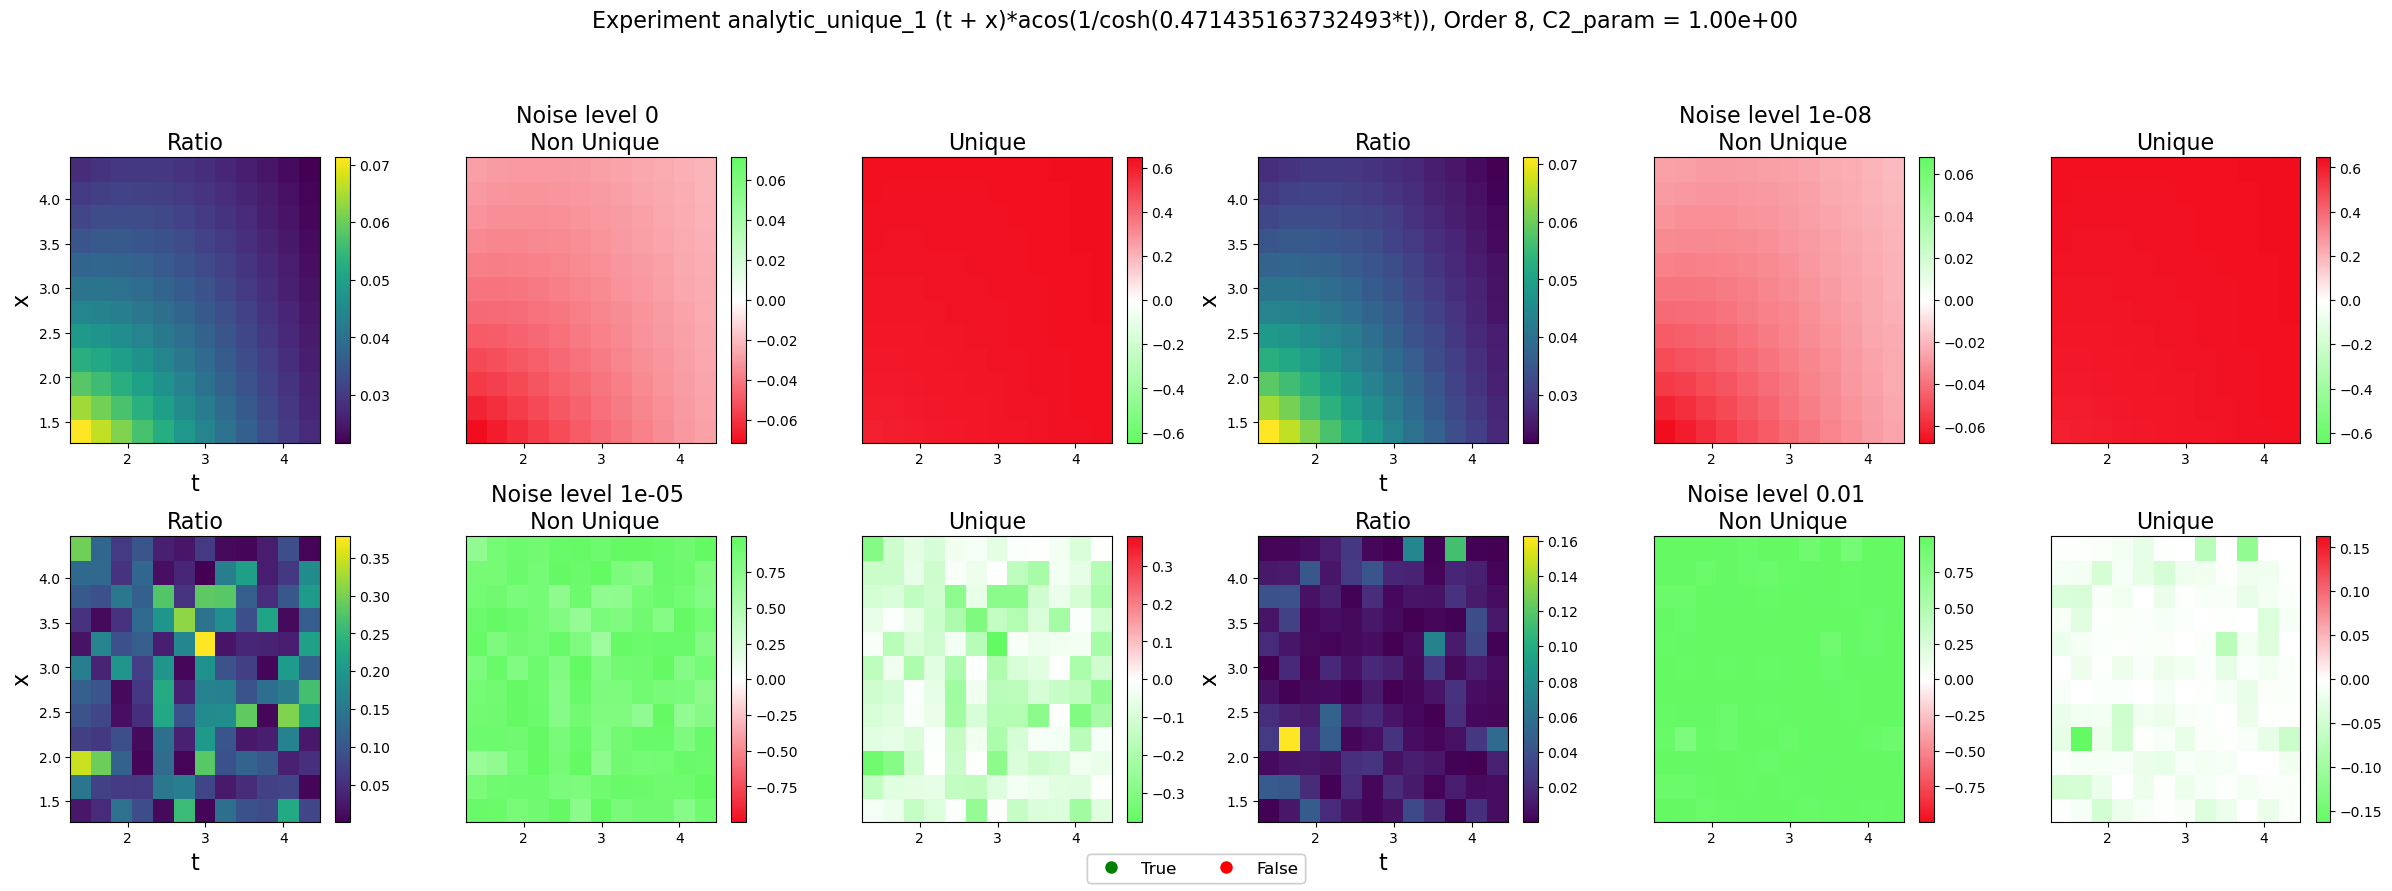

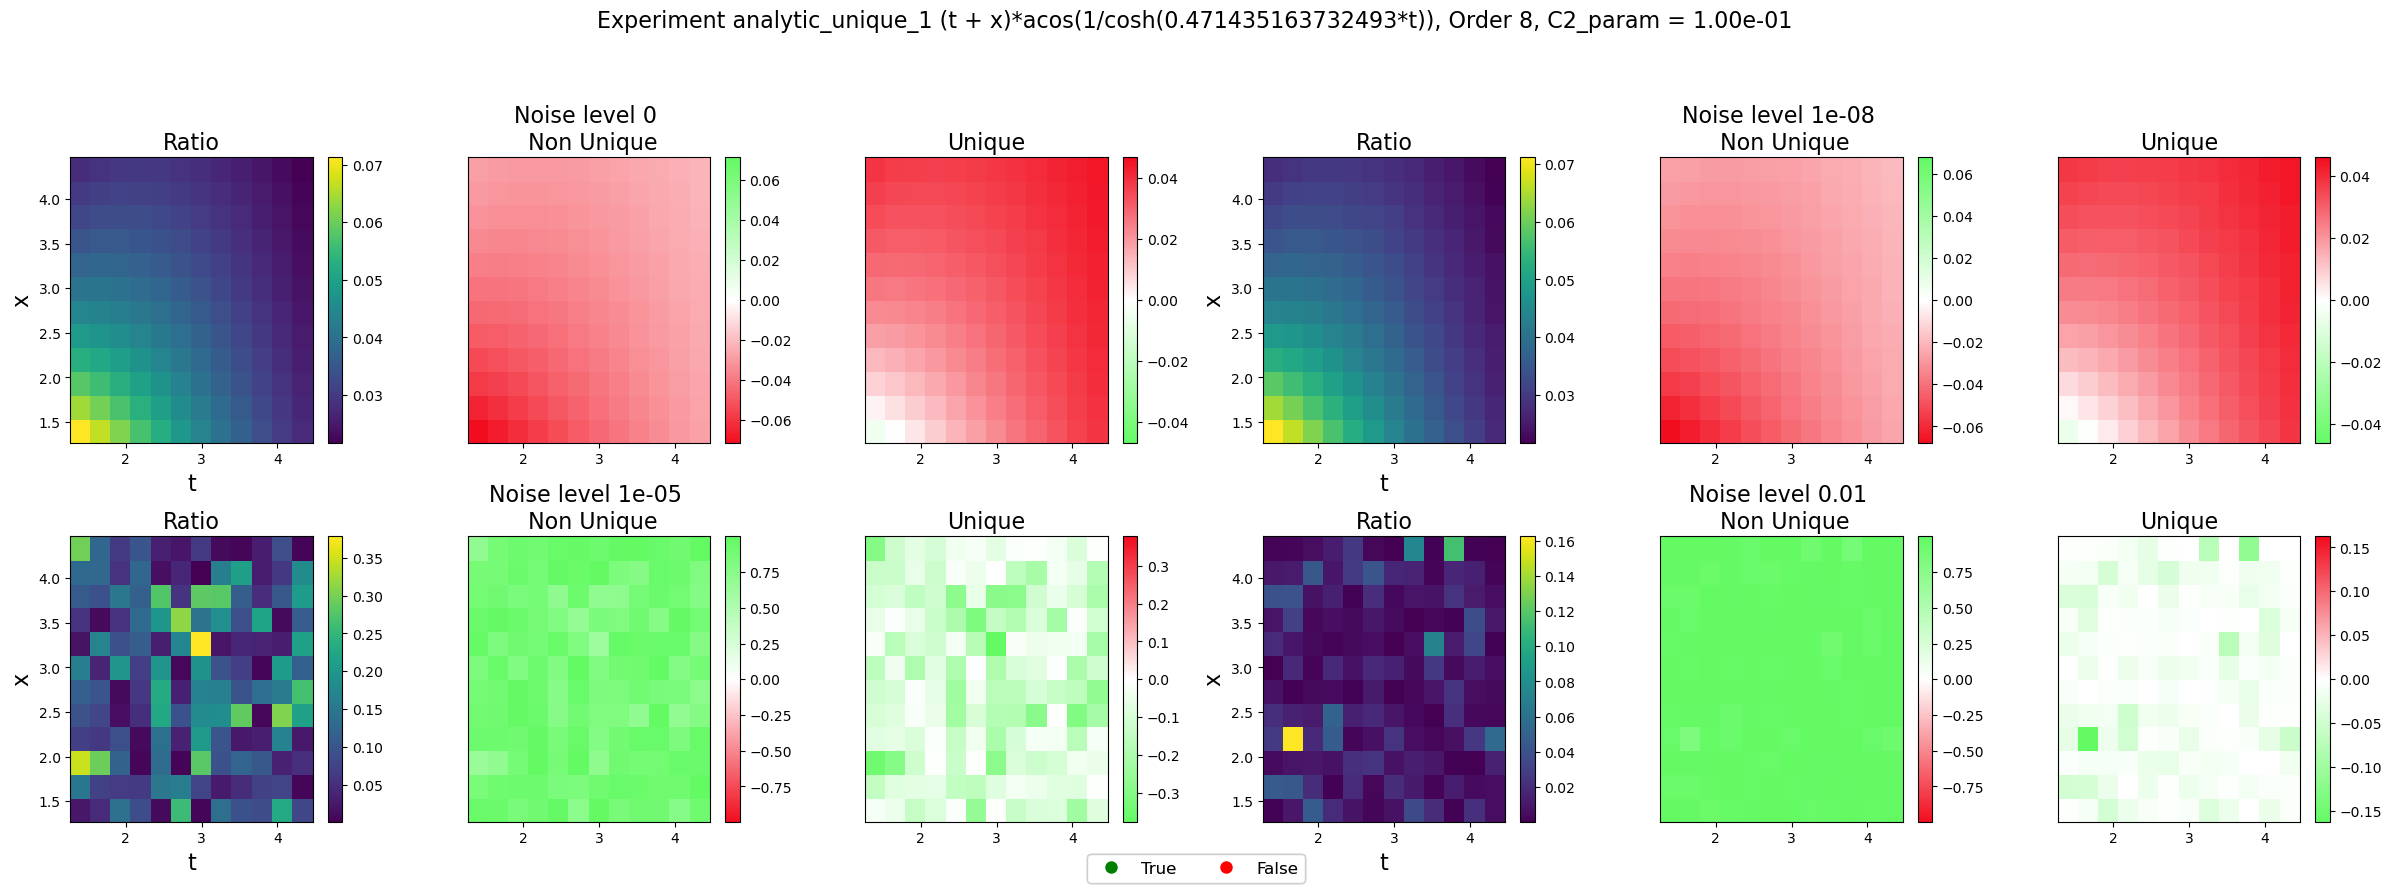

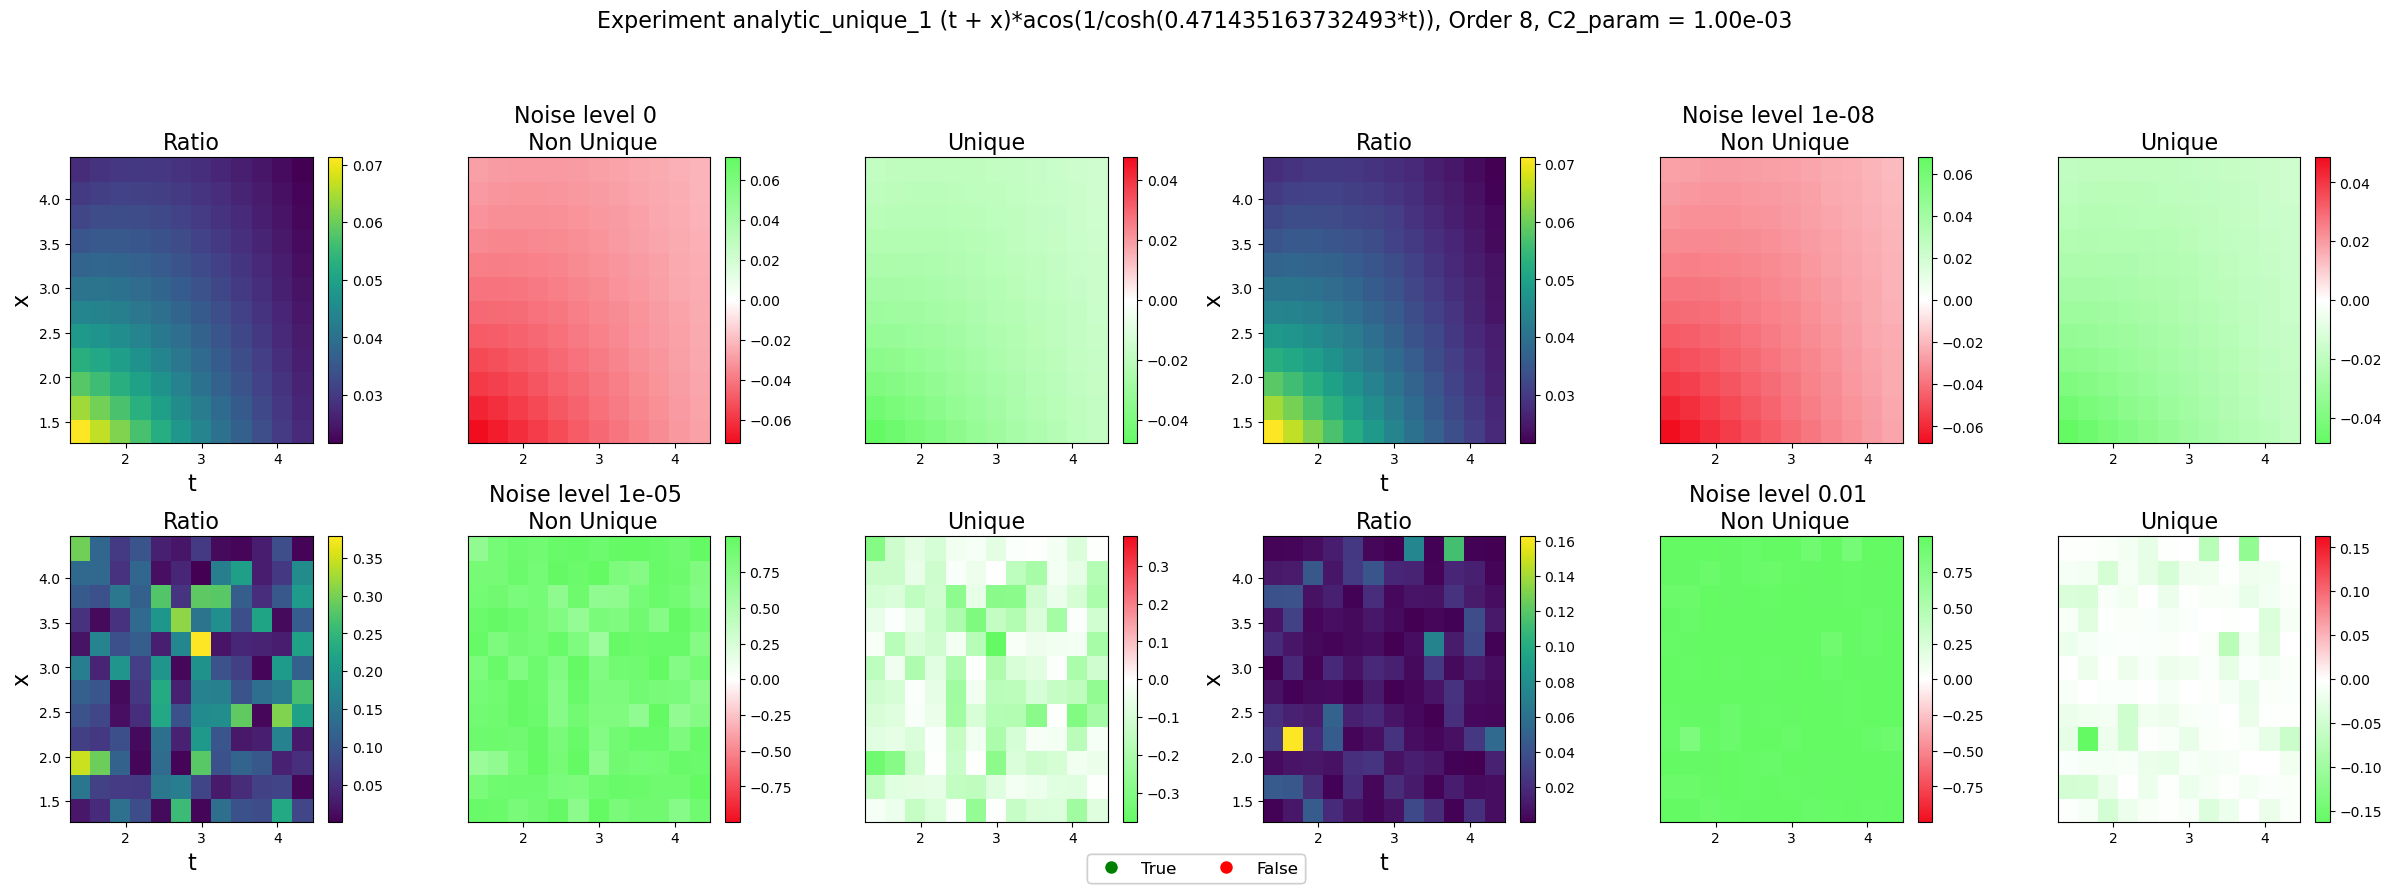

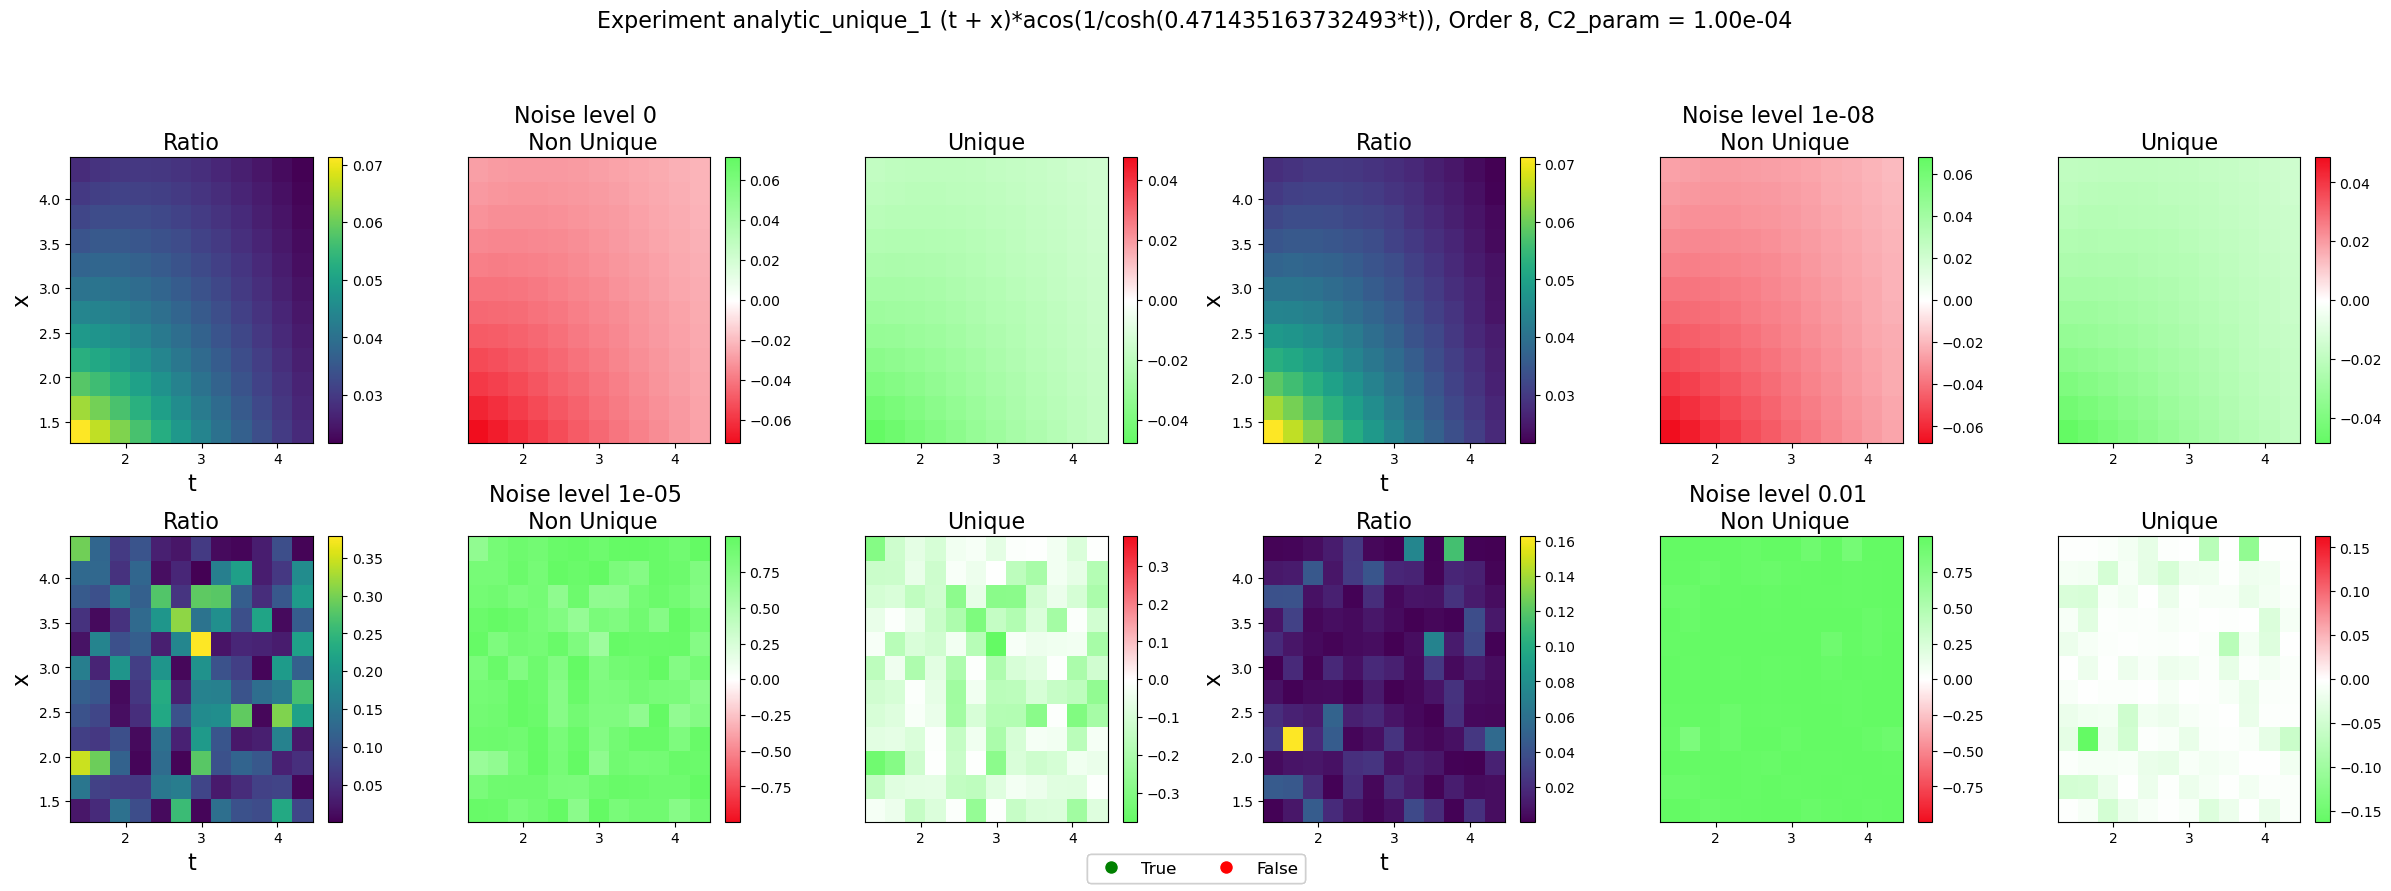

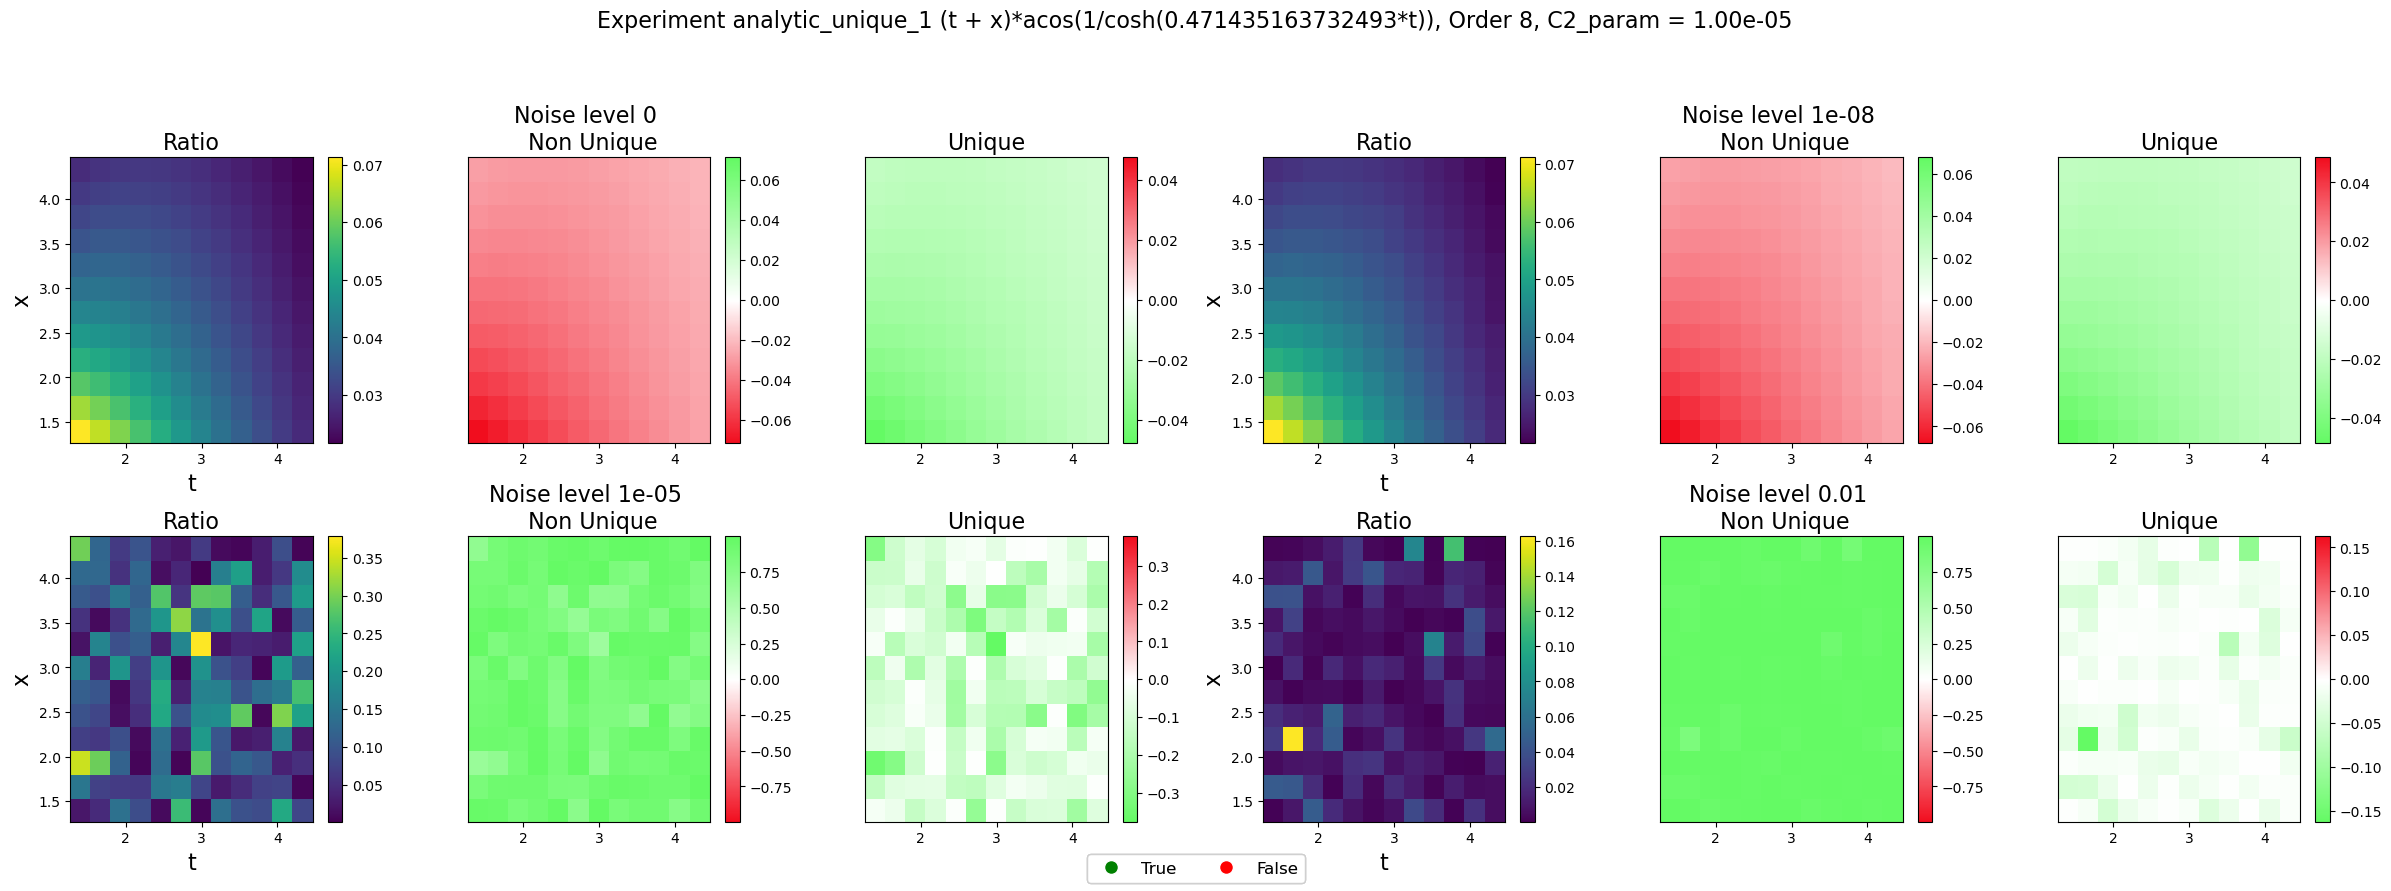

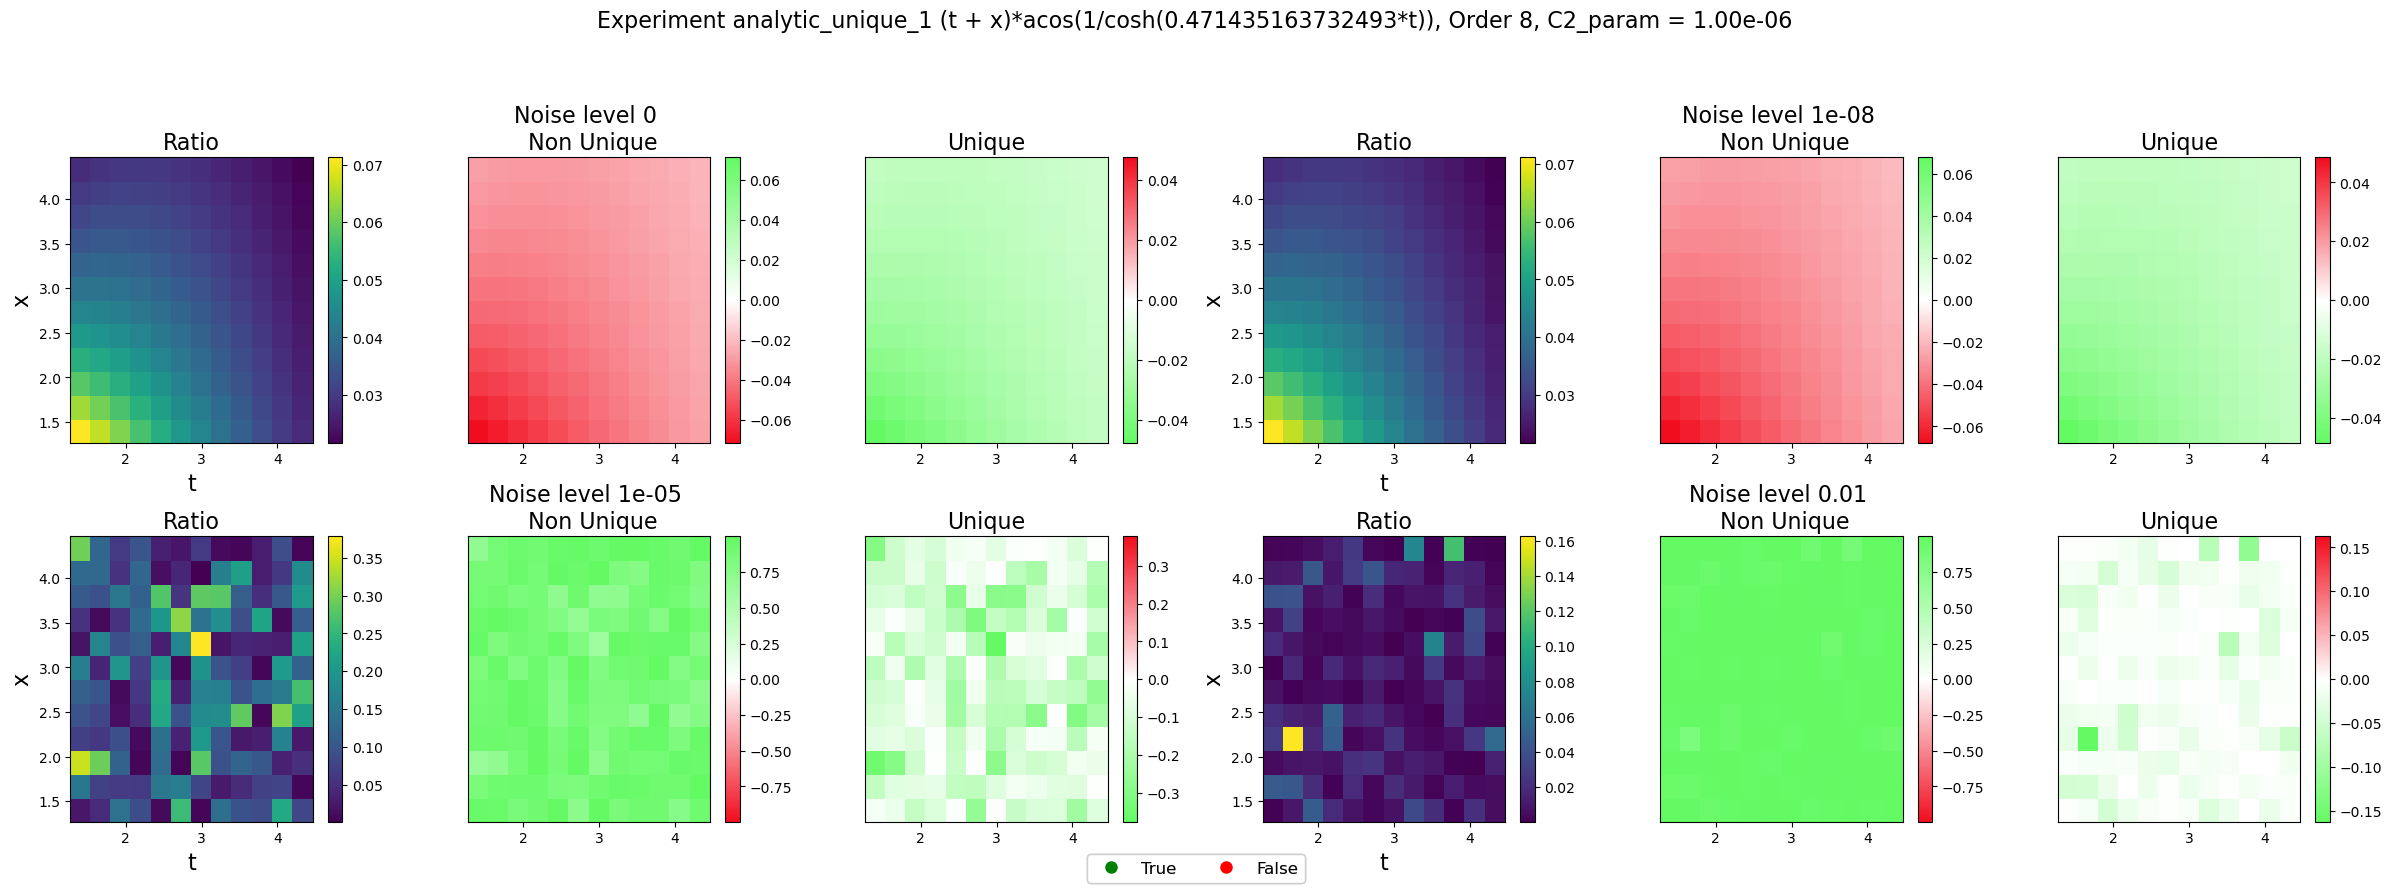

In [27]:
# Unique example
experiment_name = experiment_names[2]
for C2_param in C2_params:
    print(f"C2 = max({C2_param:.3e} * sv_max,0.5*sv_min)")
    perform_experiment(noise_levels,order,experiment_name,C2_param)    

#### Plot how often the problem is correctly classified for specific C2

In [20]:
C2_params=[1.0,0.5,0.25,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
fd_order=8

In [21]:
# Non unique example
experiment_name = experiment_names[1]
true_class = "non unique"

In [22]:
results = get_results_C2(C2_params,noise_levels,fd_order,experiment_name,true_class)

Performing experiment algebraic_nonunique_1 1/(t + x) with order 8
C2 = max(1.000e+00 * sv_max,0.5*sv_min)
C2 = max(5.000e-01 * sv_max,0.5*sv_min)
C2 = max(2.500e-01 * sv_max,0.5*sv_min)
C2 = max(1.000e-01 * sv_max,0.5*sv_min)
C2 = max(1.000e-02 * sv_max,0.5*sv_min)
C2 = max(1.000e-03 * sv_max,0.5*sv_min)
C2 = max(1.000e-04 * sv_max,0.5*sv_min)
C2 = max(1.000e-05 * sv_max,0.5*sv_min)
C2 = max(1.000e-06 * sv_max,0.5*sv_min)


In [23]:
df_analysis = get_df_analysis(results)

In [42]:
check_classification_max_correct_noise_level(df_analysis,C2_params,results)

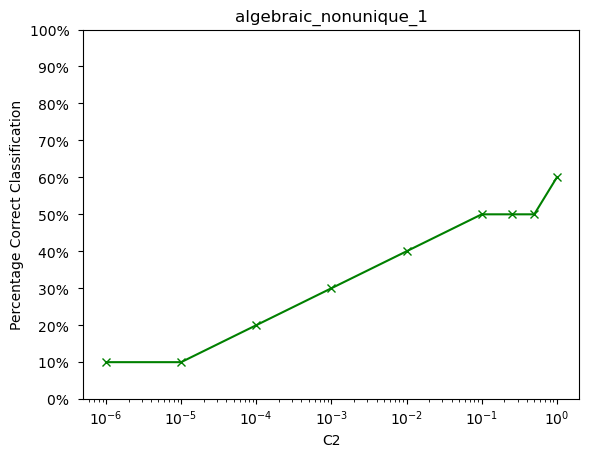

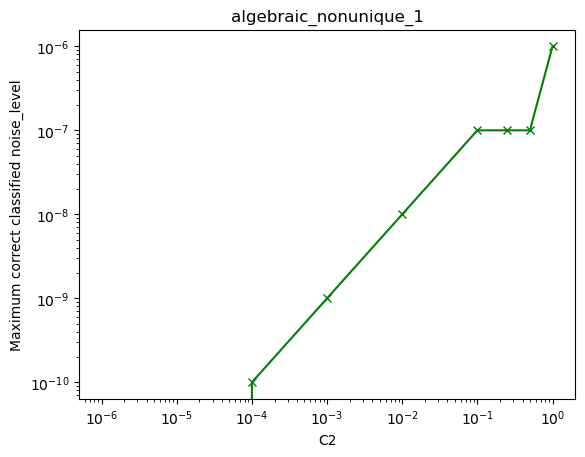

In [43]:
plot_results_C2(experiment_name,df_analysis,noise_levels)
plot_results_C2_noise_level(experiment_name,df_analysis,noise_levels)

In [10]:
# Unique example
experiment_name = experiment_names[2]
true_class = "unique"

In [9]:
C2_params=[1.0,0.5,0.25]
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
fd_order=8

In [20]:
#We want C2<= sv_min 
#Get true sv_min and sv_max
u,x,t,formula = experiment_data(n_samples=150,experiment_name=experiment_name)
eps=0
C2_param=1e-4
T,X = np.meshgrid(t,x)
C_upper_bounds_deriv = get_Cut_Cux_Cuxx_Cutx(formula,X,T,fd_order)
dx=x[1]-x[0]
dt=t[1]-t[0]
svs, lower_bounds,upper_bounds,space_range,time_range =  get_results(u,C_upper_bounds_deriv,fd_order,dt,dx,eps,C2_param)

sv_min, 1.294e-01
C2 6.472e-02
sv_min, 1.298e-01
C2 6.489e-02
sv_min, 1.272e-01
C2 6.360e-02
sv_min, 1.226e-01
C2 6.129e-02
sv_min, 1.166e-01
C2 5.828e-02
sv_min, 1.097e-01
C2 5.483e-02
sv_min, 1.023e-01
C2 5.113e-02
sv_min, 9.469e-02
C2 4.734e-02
sv_min, 8.714e-02
C2 4.357e-02
sv_min, 7.978e-02
C2 3.989e-02
sv_min, 7.273e-02
C2 3.636e-02
sv_min, 6.604e-02
C2 3.302e-02
sv_min, 5.978e-02
C2 2.989e-02
sv_min, 1.229e-01
C2 6.146e-02
sv_min, 1.241e-01
C2 6.207e-02
sv_min, 1.224e-01
C2 6.121e-02
sv_min, 1.186e-01
C2 5.928e-02
sv_min, 1.132e-01
C2 5.661e-02
sv_min, 1.069e-01
C2 5.346e-02
sv_min, 1.000e-01
C2 5.002e-02
sv_min, 9.289e-02
C2 4.644e-02
sv_min, 8.569e-02
C2 4.285e-02
sv_min, 7.862e-02
C2 3.931e-02
sv_min, 7.180e-02
C2 3.590e-02
sv_min, 6.530e-02
C2 3.265e-02
sv_min, 5.919e-02
C2 2.960e-02
sv_min, 1.170e-01
C2 5.848e-02
sv_min, 1.189e-01
C2 5.946e-02
sv_min, 1.179e-01
C2 5.897e-02
sv_min, 1.148e-01
C2 5.739e-02
sv_min, 1.101e-01
C2 5.503e-02
sv_min, 1.043e-01
C2 5.216e-02
sv_min, 

In [21]:
svs

array([[0.07125978, 0.06645097, 0.06158517, 0.05685648, 0.052342  ,
        0.04807005, 0.04404866, 0.04027739, 0.03675212, 0.0334669 ,
        0.03041464, 0.02758734, 0.02497616],
       [0.06424838, 0.0607942 , 0.05703145, 0.05319425, 0.04939899,
        0.04570723, 0.04215388, 0.03876003, 0.03553886, 0.03249838,
        0.02964277, 0.02697321, 0.02448834],
       [0.0581837 , 0.05579884, 0.0529396 , 0.04985459, 0.04668124,
        0.0435016 , 0.04036865, 0.03731891, 0.03437857, 0.03156657,
        0.02889631, 0.02637664, 0.02401263],
       [0.05290904, 0.05137023, 0.04925251, 0.04680311, 0.04416806,
        0.04144074, 0.03868555, 0.0359496 , 0.03326861, 0.03066994,
        0.02817435, 0.02579708, 0.0235487 ],
       [0.04829756, 0.04742923, 0.04592111, 0.04400951, 0.04184085,
        0.03951331, 0.0370977 , 0.03464797, 0.0322065 , 0.029807  ,
        0.02747602, 0.02523403, 0.02309626],
       [0.04424603, 0.04390947, 0.04290312, 0.0414471 , 0.03968288,
        0.03770891, 0.03559

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
results = get_results_C2(C2_params,noise_levels,fd_order,experiment_name,true_class)

Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8
C2 = max(1.000e+00 * sv_max,0.5*sv_min)
C2 1.816e+00
C2 1.953e+00
C2 2.066e+00
C2 2.156e+00
C2 2.227e+00
C2 2.281e+00
C2 2.322e+00
C2 2.351e+00
C2 2.371e+00
C2 2.384e+00
C2 2.391e+00
C2 2.394e+00
C2 2.393e+00
C2 1.913e+00
C2 2.042e+00
C2 2.146e+00
C2 2.229e+00
C2 2.292e+00
C2 2.339e+00
C2 2.373e+00
C2 2.397e+00
C2 2.411e+00
C2 2.419e+00
C2 2.422e+00
C2 2.421e+00
C2 2.417e+00
C2 2.010e+00
C2 2.131e+00
C2 2.228e+00
C2 2.302e+00
C2 2.358e+00
C2 2.398e+00
C2 2.425e+00
C2 2.442e+00
C2 2.452e+00
C2 2.455e+00
C2 2.453e+00
C2 2.448e+00
C2 2.441e+00
C2 2.108e+00
C2 2.221e+00
C2 2.310e+00
C2 2.376e+00
C2 2.424e+00
C2 2.457e+00
C2 2.477e+00
C2 2.488e+00
C2 2.492e+00
C2 2.490e+00
C2 2.484e+00
C2 2.476e+00
C2 2.465e+00
C2 2.206e+00
C2 2.312e+00
C2 2.392e+00
C2 2.450e+00
C2 2.491e+00
C2 2.516e+00
C2 2.530e+00
C2 2.535e+00
C2 2.533e+00
C2 2.526e+00
C2 2.516e+00
C2 2.503e+00
C2 2.489e+00
C2 2.305e+00
C2 2.40

In [37]:
df_analysis = get_df_analysis(results)
check_classification_max_correct_noise_level(df_analysis,C2_params,results)

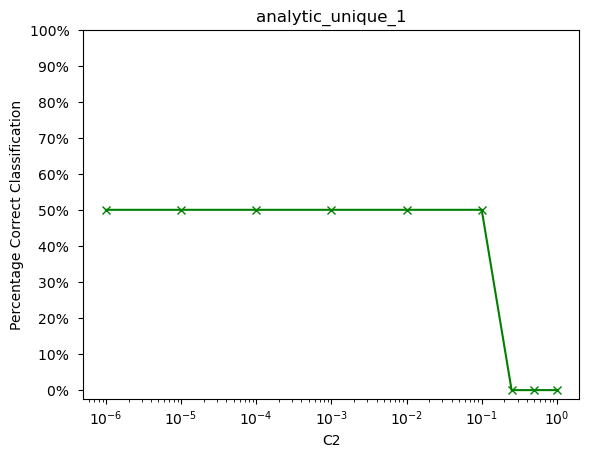

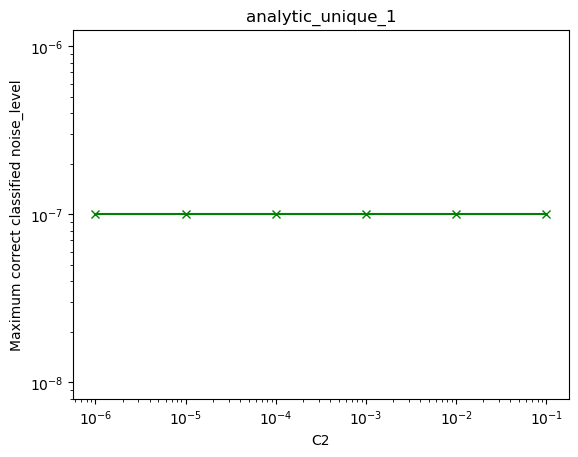

In [38]:
plot_results_C2(experiment_name,df_analysis,noise_levels)
plot_results_C2_noise_level(experiment_name,df_analysis,noise_levels)

### Do this for all expeirments

In [24]:
C2_params=[1.0,0.5,0.25,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
fd_order=8

In [25]:
dic_experiments = {'algebraic_nonunique_kdv': "non unique",
                   'algebraic_nonunique_1': "non unique",
                   'analytic_unique_1': "unique",
                   'analytic_unique_2': "unique",
                   'analytic_nonunique_1': "unique"}

In [26]:
all_results = pd.DataFrame(columns=["True_Class", "Pred_Class","C2","noise_level","fd_order","experiment"])
for experiment_name in experiment_names:
    true_class = dic_experiments[experiment_name]
    results = get_results_C2(C2_params,noise_levels,fd_order,experiment_name,true_class)
    results["experiment"] = experiment_name
    all_results = pd.concat([all_results,results])

Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8
C2 = max(1.000e+00 * sv_max,0.5*sv_min)
C2 = max(5.000e-01 * sv_max,0.5*sv_min)
C2 = max(2.500e-01 * sv_max,0.5*sv_min)
C2 = max(1.000e-01 * sv_max,0.5*sv_min)
C2 = max(1.000e-02 * sv_max,0.5*sv_min)
C2 = max(1.000e-03 * sv_max,0.5*sv_min)
C2 = max(1.000e-04 * sv_max,0.5*sv_min)
C2 = max(1.000e-05 * sv_max,0.5*sv_min)
C2 = max(1.000e-06 * sv_max,0.5*sv_min)
Performing experiment algebraic_nonunique_1 1/(t + x) with order 8
C2 = max(1.000e+00 * sv_max,0.5*sv_min)
C2 = max(5.000e-01 * sv_max,0.5*sv_min)
C2 = max(2.500e-01 * sv_max,0.5*sv_min)
C2 = max(1.000e-01 * sv_max,0.5*sv_min)
C2 = max(1.000e-02 * sv_max,0.5*sv_min)
C2 = max(1.000e-03 * sv_max,0.5*sv_min)
C2 = max(1.000e-04 * sv_max,0.5*sv_min)
C2 = max(1.000e-05 * sv_max,0.5*sv_min)
C2 = max(1.000e-06 * sv_max,0.5*sv_min)
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) wit

In [27]:
all_results.to_csv("results/all_results_plot_C2.csv")

In [28]:
all_results= pd.read_csv("results/all_results_plot_C2.csv")

In [29]:
all_results

Unnamed: 0  True_Class  Pred_Class        C2   noise_level  fd_order  \
0             0  non unique  non unique  1.000000  0.000000e+00         8   
1             1  non unique  non unique  1.000000  1.000000e-10         8   
2             2  non unique  non unique  1.000000  1.000000e-09         8   
3             3  non unique  non unique  1.000000  1.000000e-08         8   
4             4  non unique  non unique  1.000000  1.000000e-07         8   
..          ...         ...         ...       ...           ...       ...   
445          85      unique         NaN  0.000001  1.000000e-06         8   
446          86      unique         NaN  0.000001  1.000000e-05         8   
447          87      unique         NaN  0.000001  1.000000e-04         8   
448          88      unique         NaN  0.000001  1.000000e-03         8   
449          89      unique         NaN  0.000001  1.000000e-02         8   

                  experiment  Correct_Classification  
0    algebraic_nonunique_kdv                    True  
1    algebraic_nonunique_kdv                    True  
2    algebraic_nonunique_kdv                    True  
3    algebraic_nonunique_kdv                    True  
4    algebraic_nonunique_kdv                    True  
..                       ...                     ...  
445     analytic_nonunique_1                   False  
446     analytic_nonunique_1                   False  
447     analytic_nonunique_1                   False  
448     analytic_nonunique_1                   False  
449     analytic_nonunique_1                   False  

[450 rows x 8 columns]

In [30]:
def get_df_analysis_all(results):
    df_analysis = pd.DataFrame()
    df_analysis["Count_Correct_Class"] = results[["Correct_Classification","C2","experiment"]].groupby(["C2","experiment"]).sum()
    df_analysis["Count_Total_Class"] = results[["True_Class","C2","experiment"]].groupby(["C2","experiment"]).count()
    df_analysis["max_correct_noise_level"]= results[results['Correct_Classification']].groupby(["C2","experiment"])['noise_level'].max()
    df_analysis["Correct_Class_percentage"]=df_analysis["Count_Correct_Class"]/df_analysis["Count_Total_Class"]*100
    return df_analysis.reset_index("experiment")

In [31]:
df_analysis = get_df_analysis_all(all_results)

In [32]:
df_analysis

experiment  Count_Correct_Class  Count_Total_Class  \
C2                                                                          
0.000001    algebraic_nonunique_1                    1                 10   
0.000001  algebraic_nonunique_kdv                    1                 10   
0.000001     analytic_nonunique_1                    0                 10   
0.000001        analytic_unique_1                    5                 10   
0.000001        analytic_unique_2                    6                 10   
0.000010    algebraic_nonunique_1                    1                 10   
0.000010  algebraic_nonunique_kdv                    1                 10   
0.000010     analytic_nonunique_1                    0                 10   
0.000010        analytic_unique_1                    5                 10   
0.000010        analytic_unique_2                    6                 10   
0.000100    algebraic_nonunique_1                    2                 10   
0.000100  algebraic_nonunique_kdv                    2                 10   
0.000100     analytic_nonunique_1                    0                 10   
0.000100        analytic_unique_1                    5                 10   
0.000100        analytic_unique_2                    6                 10   
0.001000    algebraic_nonunique_1                    3                 10   
0.001000  algebraic_nonunique_kdv                    3                 10   
0.001000     analytic_nonunique_1                    0                 10   
0.001000        analytic_unique_1                    5                 10   
0.001000        analytic_unique_2                    6                 10   
0.010000    algebraic_nonunique_1                    4                 10   
0.010000  algebraic_nonunique_kdv                    4                 10   
0.010000     analytic_nonunique_1                    0                 10   
0.010000        analytic_unique_1                    5                 10   
0.010000        analytic_unique_2                    6                 10   
0.100000    algebraic_nonunique_1                    5                 10   
0.100000  algebraic_nonunique_kdv                    5                 10   
0.100000     analytic_nonunique_1                    0                 10   
0.100000        analytic_unique_1                    5                 10   
0.100000        analytic_unique_2                    6                 10   
0.250000    algebraic_nonunique_1                    5                 10   
0.250000  algebraic_nonunique_kdv                    6                 10   
0.250000     analytic_nonunique_1                    0                 10   
0.250000        analytic_unique_1                    0                 10   
0.250000        analytic_unique_2                    6                 10   
0.500000    algebraic_nonunique_1                    5                 10   
0.500000  algebraic_nonunique_kdv                    6                 10   
0.500000     analytic_nonunique_1                    0                 10   
0.500000        analytic_unique_1                    0                 10   
0.500000        analytic_unique_2                    6                 10   
1.000000    algebraic_nonunique_1                    6                 10   
1.000000  algebraic_nonunique_kdv                    6                 10   
1.000000     analytic_nonunique_1                    0                 10   
1.000000        analytic_unique_1                    0                 10   
1.000000        analytic_unique_2                    0                 10   

          max_correct_noise_level  Correct_Class_percentage  
C2                                                           
0.000001             0.000000e+00                      10.0  
0.000001             0.000000e+00                      10.0  
0.000001                      NaN                       0.0  
0.000001             1.000000e-07                      50.0  
0.000001             1.000000e-

In [33]:
for experiment in all_results.experiment:
    df_analysis_experiment = df_analysis[df_analysis["experiment"]==experiment]
    results = all_results[all_results["experiment"]==experiment]
    check_classification_max_correct_noise_level(df_analysis_experiment,C2_params,results)

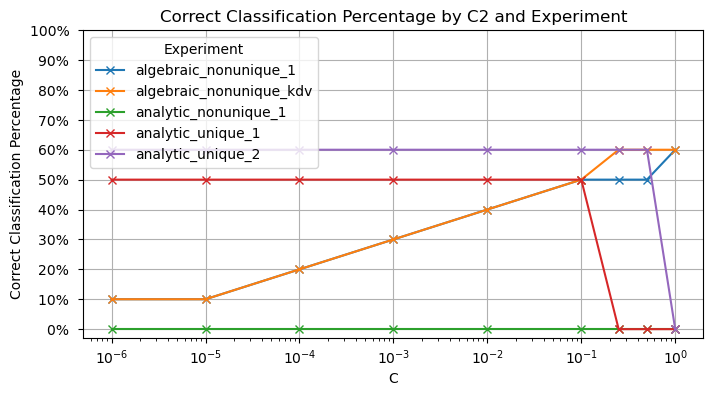

In [34]:
df_ana_plot = df_analysis.reset_index()
plt.figure(figsize=(8, 4))
ticksize = 10
for experiment in df_ana_plot.experiment.unique():
    df_ana_plot_exp = df_ana_plot[df_ana_plot["experiment"]== experiment]
    plt.plot(df_ana_plot_exp["C2"].values,df_ana_plot_exp["Correct_Class_percentage"].values,marker = 'x',label = experiment)
plt.title('Correct Classification Percentage by C2 and Experiment',)
plt.xlabel('C')
plt.ylabel('Correct Classification Percentage')
plt.xscale("log")
tick_positions = np.arange(0, 110, 10)  # Generate tick positions from 0 to 100
tick_labels = [f"{tick}% " for tick in tick_positions]  
plt.yticks(tick_positions, tick_labels)
plt.legend(title='Experiment')
plt.grid(True)
plt.savefig("Paper/C2_param_analysis.png")
plt.show()

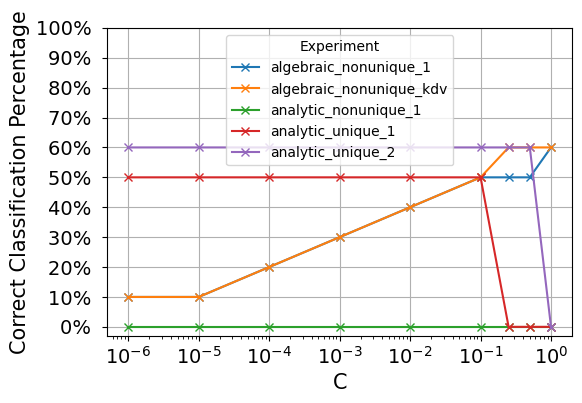

In [35]:
plt.figure(figsize=(6, 4))
ticksize = 14
titlesize = 16
labelsize = 15

# Plotting for each experiment
for experiment in df_ana_plot.experiment.unique():
    df_ana_plot_exp = df_ana_plot[df_ana_plot["experiment"] == experiment]
    plt.plot(df_ana_plot_exp["C2"].values, df_ana_plot_exp["Correct_Class_percentage"].values, marker='x', label=experiment)

# Plot settings
#plt.title('Correct Classification Percentage by C2 and Experiment', fontsize=titlesize)
plt.xlabel('C', fontsize=labelsize)
plt.ylabel('Correct Classification Percentage', fontsize=labelsize)
plt.xscale("log")

# Setting y-axis ticks and labels
tick_positions = np.arange(0, 110, 10)  # Generate tick positions from 0 to 100
tick_labels = [f"{tick}% " for tick in tick_positions]
plt.yticks(tick_positions, tick_labels)

# Adjusting tick size
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

plt.legend(title='Experiment', fontsize=ticksize-4)
plt.grid(True)
plt.savefig("Paper/C2_param_analysis.png")
plt.show()